In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt


def load_df(csv_path, nrows=None):
    USE_COLUMNS = [
        'channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'socialEngagementType', 'totals', 'trafficSource', 'visitId',
        'visitNumber', 'visitStartTime', 'customDimensions'
        #'hits'
    ]
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows, usecols=USE_COLUMNS)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [2]:
%%time
train_df = load_df(csv_path='train_v2.csv')

Loaded train_v2.csv. Shape: (1708337, 59)
CPU times: user 4min 54s, sys: 16.4 s, total: 5min 11s
Wall time: 5min 11s


In [3]:
%%time
test_df = load_df(csv_path='test_v2.csv')

Loaded test_v2.csv. Shape: (401589, 58)
CPU times: user 1min 20s, sys: 2.9 s, total: 1min 23s
Wall time: 1min 23s


In [4]:
# check the difference since the shape is not the same
print(train_df.columns.difference(test_df.columns))
print(test_df.columns.difference(train_df.columns))

Index(['trafficSource.campaignCode'], dtype='object')
Index([], dtype='object')


In [5]:
# remove this different row
train_df = train_df.drop(labels=['trafficSource.campaignCode'],axis=1)

train_df = train_df.drop(labels=['customDimensions','totals.transactionRevenue'],axis=1)
test_df = test_df.drop(labels=['customDimensions','totals.transactionRevenue','totals.totalTransactionRevenue'],axis=1)

In [6]:
# transform the date type
train_df['date']= pd.to_datetime(train_df['date'],format='%Y%m%d')
test_df['date']= pd.to_datetime(test_df['date'],format='%Y%m%d')
train_df.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2017-10-16,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,2017-10-16,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,2017-10-16,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,2017-10-16,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,2017-10-16,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [7]:
train_df['totals.totalTransactionRevenue'] = train_df['totals.totalTransactionRevenue'].astype('float')
print('Total records: ', len(train_df), 'customers doesnt contribute for revenue: ',train_df['totals.totalTransactionRevenue'].isna().sum(), \
      'customers contributing revenue: ',len(train_df) - train_df['totals.totalTransactionRevenue'].isna().sum())

Total records:  1708337 customers doesnt contribute for revenue:  1689823 customers contributing revenue:  18514


In [8]:
#Lets start with data cleaning
#Find any unique value columns
print('Features with one unique values are :')
print(train_df.columns[train_df.nunique()==1])
new_df = train_df.drop(labels=train_df.columns[train_df.nunique()==1],axis=1)
test_df = test_df.drop(labels=train_df.columns[train_df.nunique()==1],axis=1)

Features with one unique values are :
Index(['socialEngagementType', 'device.browserSize', 'device.browserVersion',
       'device.flashVersion', 'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystemVersion', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.bounces',
       'totals.newVisits', 'totals.visits',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.isTrueDirect'],
      dtype='object')


In [9]:
# Exploratory of features
geofields = ['geoNetwork.city','geoNetwork.continent','geoNetwork.country','geoNetwork.metro','geoNetwork.networkDomain','geoNetwork.region','geoNetwork.subContinent']

for fields in geofields:
    temp_df = new_df.groupby(by=fields).size().sort_values(ascending=False).head(10)
    print(temp_df)
    print('*'*30)

geoNetwork.city
not available in demo dataset    932959
Mountain View                     74110
(not set)                         65867
New York                          49460
San Francisco                     36960
Sunnyvale                         27923
London                            23622
San Jose                          20141
Los Angeles                       17038
Chicago                           15143
dtype: int64
******************************
geoNetwork.continent
Americas     877403
Asia         396719
Europe       368037
Africa        35481
Oceania       28180
(not set)      2517
dtype: int64
******************************
geoNetwork.country
United States     717217
India             105317
United Kingdom     73341
Canada             51057
Germany            38516
Japan              36637
Brazil             35432
Vietnam            34869
France             32289
Thailand           29859
dtype: int64
******************************
geoNetwork.metro
not available in demo dat

                                 visitId  totals.totalTransactionRevenue
visitId                         1.000000                        0.248262
totals.totalTransactionRevenue  0.248262                        1.000000


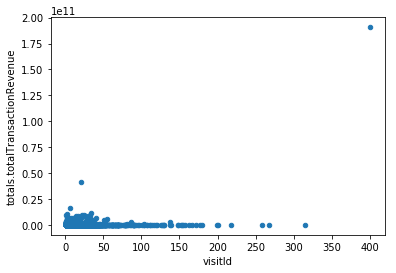

In [10]:
temp = new_df.groupby(by=['fullVisitorId']).agg({'visitId':'count','totals.totalTransactionRevenue':'sum'})
print(temp.corr())
temp.plot(kind='scatter',x='visitId',y='totals.totalTransactionRevenue')

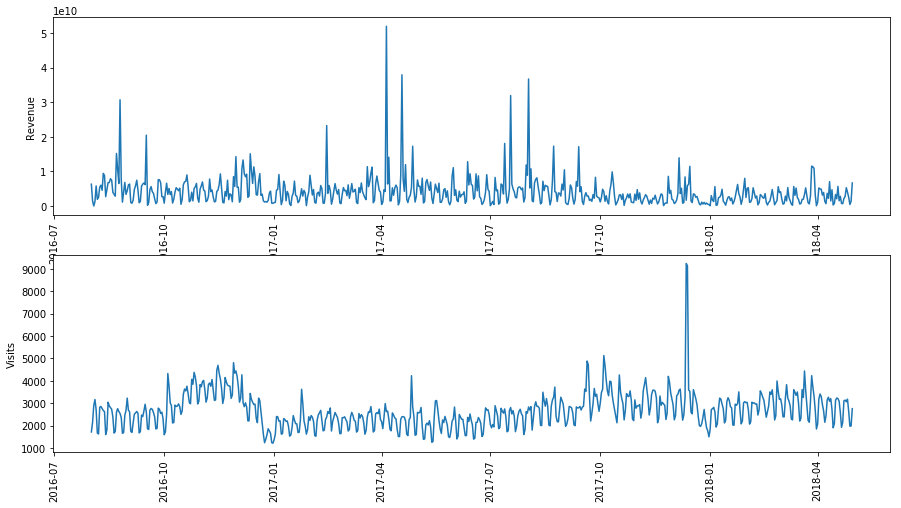

In [11]:
#Lets analyze how the visits and transactionRevenue trend with date
plot_df = new_df.groupby(by=['date']).agg({'fullVisitorId':'count','totals.totalTransactionRevenue':'sum'}).reset_index()

fig = plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(pd.to_datetime(plot_df['date']),plot_df['totals.totalTransactionRevenue'])
plt.ylabel('Revenue')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.plot(pd.to_datetime(plot_df['date']),plot_df['fullVisitorId'])
plt.ylabel('Visits')
plt.xticks(rotation=90);

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

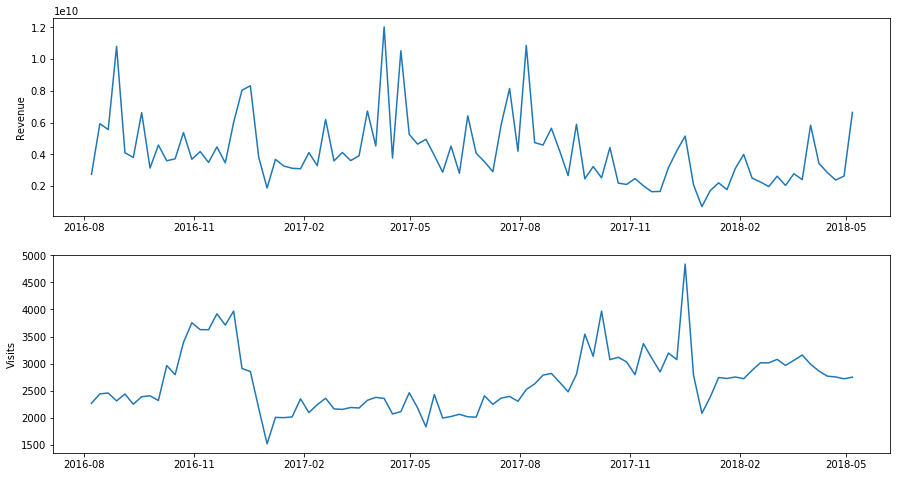

In [12]:
#Weekly pattern

plot_df = new_df.groupby(by=['date']).agg({'fullVisitorId':'count','totals.totalTransactionRevenue':'sum'})

plot_df = plot_df.resample('W').mean()

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(plot_df.index,plot_df['totals.totalTransactionRevenue'])
plt.ylabel('Revenue')

plt.subplot(2,1,2)
plt.plot(plot_df.index,plot_df['fullVisitorId'])
plt.ylabel('Visits');

(array([2.400e+01, 6.300e+02, 5.989e+03, 6.420e+03, 2.138e+03, 7.590e+02,
        1.550e+02, 2.400e+01, 1.000e+00, 1.000e+00]),
 array([13.99783295, 15.19543675, 16.39304055, 17.59064435, 18.78824815,
        19.98585196, 21.18345576, 22.38105956, 23.57866336, 24.77626716,
        25.97387096]),
 <a list of 10 Patch objects>)

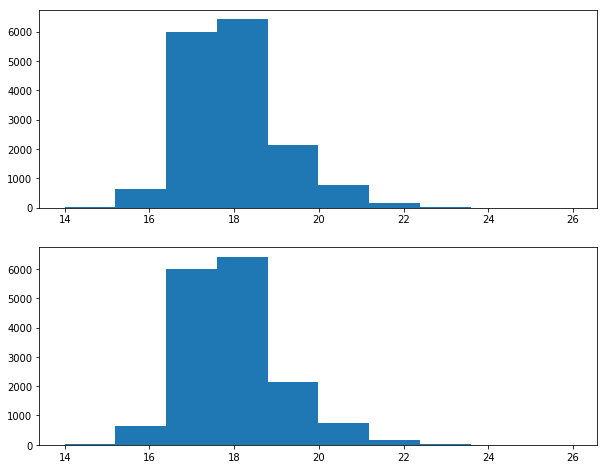

In [13]:
plot_df = new_df.groupby(by=['fullVisitorId']).agg({'channelGrouping':'count','totals.totalTransactionRevenue':'sum'})

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.hist(np.log1p(plot_df[plot_df['totals.totalTransactionRevenue']>0]['totals.totalTransactionRevenue']))

plt.subplot(2,1,2)
plt.hist(np.log1p(plot_df[plot_df['totals.totalTransactionRevenue']>0]['totals.totalTransactionRevenue']))

In [14]:
new_df.isna().sum()

channelGrouping                                       0
date                                                  0
fullVisitorId                                         0
visitId                                               0
visitNumber                                           0
visitStartTime                                        0
device.browser                                        0
device.deviceCategory                                 0
device.isMobile                                       0
device.operatingSystem                                0
geoNetwork.city                                       0
geoNetwork.continent                                  0
geoNetwork.country                                    0
geoNetwork.metro                                      0
geoNetwork.networkDomain                              0
geoNetwork.region                                     0
geoNetwork.subContinent                               0
totals.hits                                     

In [15]:
# replace na with 0 for total trascation revenue
new_df['totals.totalTransactionRevenue'].fillna(value=0,inplace=True)
transaction_df = new_df[new_df['totals.totalTransactionRevenue']>0.0]
nontransaction_df = new_df[new_df['totals.totalTransactionRevenue']<=0]
print(transaction_df.shape, nontransaction_df.shape)

(18514, 33) (1689823, 33)


In [16]:
# Exploratory of geo info
def getplot(df1, df2, groupfield):
    fig =plt.figure(figsize=(15,8))
    plt.subplot(2,1,1)
    plot_df = df1.groupby(by=[groupfield])['totals.totalTransactionRevenue'].size().reset_index()
    plot_df = plot_df.sort_values(by=['totals.totalTransactionRevenue'], ascending=False).head(10)
    plt1 = plt.bar(plot_df[groupfield],plot_df['totals.totalTransactionRevenue'])

    plt.subplot(2,1,2)
    plot_df = df2.groupby(by=[groupfield])['totals.totalTransactionRevenue'].size().reset_index()
    plot_df = plot_df.sort_values(by=['totals.totalTransactionRevenue'], ascending=False).head(10)
    plt2 = plt.bar(plot_df[groupfield],plot_df['totals.totalTransactionRevenue'])
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    #fig.tight_layout()
    return plt1, plt2

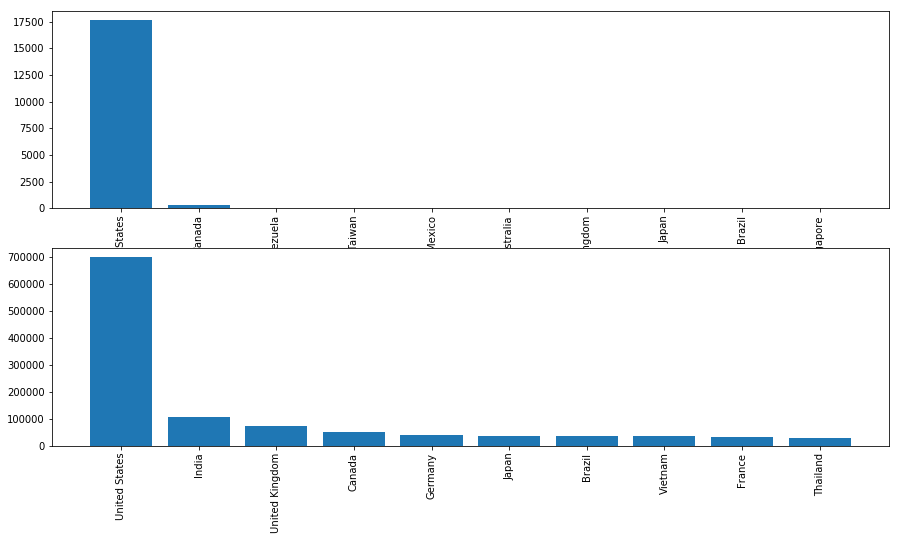

In [17]:
getplot(transaction_df,nontransaction_df,'geoNetwork.country');

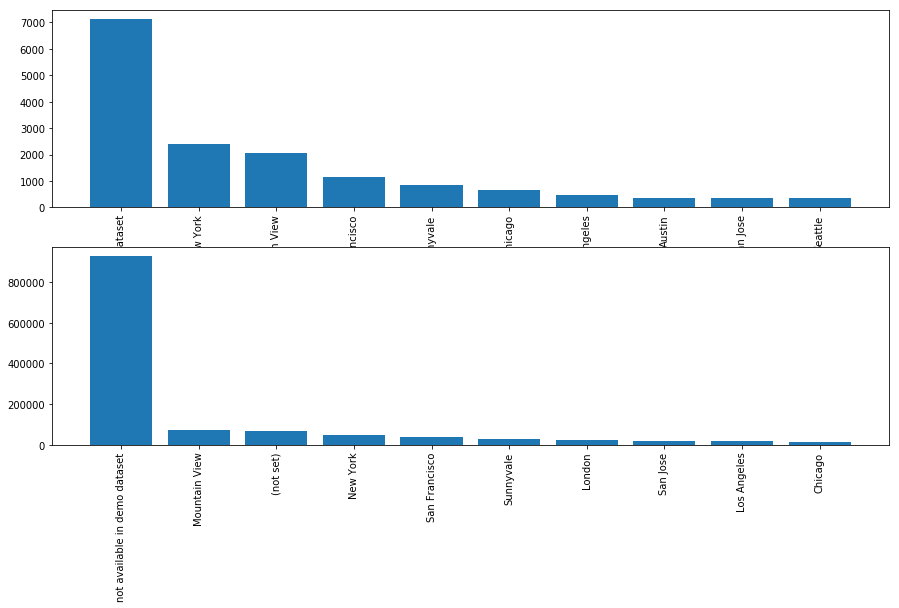

In [18]:
getplot(transaction_df,nontransaction_df,'geoNetwork.city');

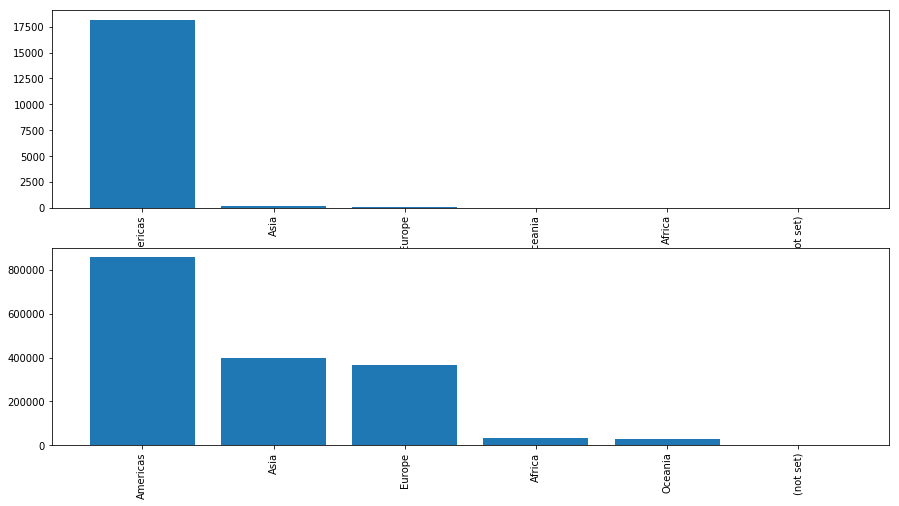

In [19]:
getplot(transaction_df,nontransaction_df,'geoNetwork.continent');

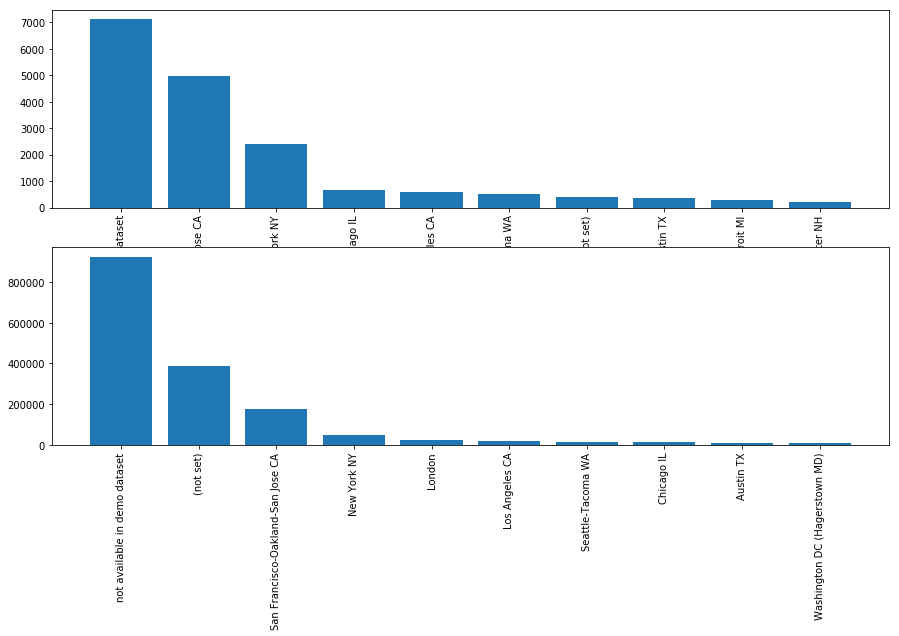

In [20]:
getplot(transaction_df,nontransaction_df,'geoNetwork.metro');

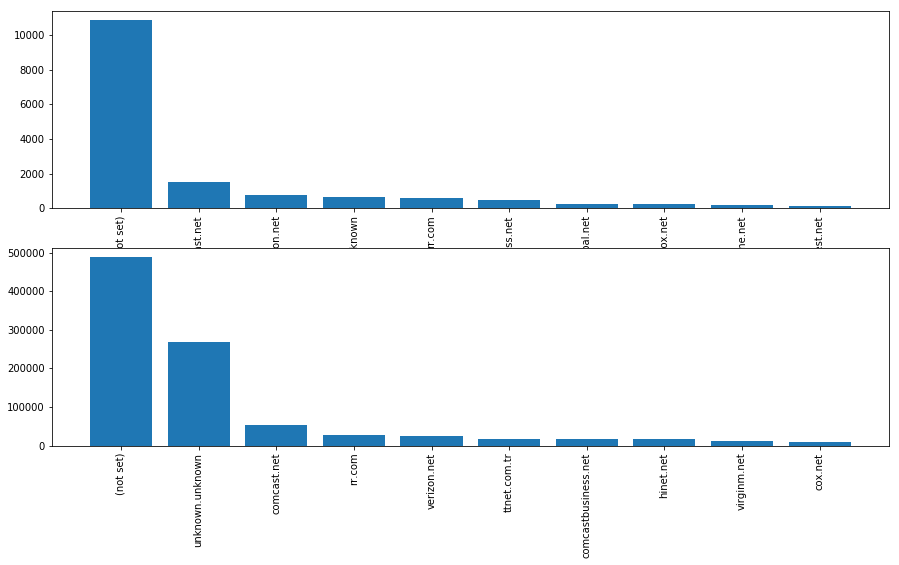

In [21]:
getplot(transaction_df,nontransaction_df,'geoNetwork.networkDomain');

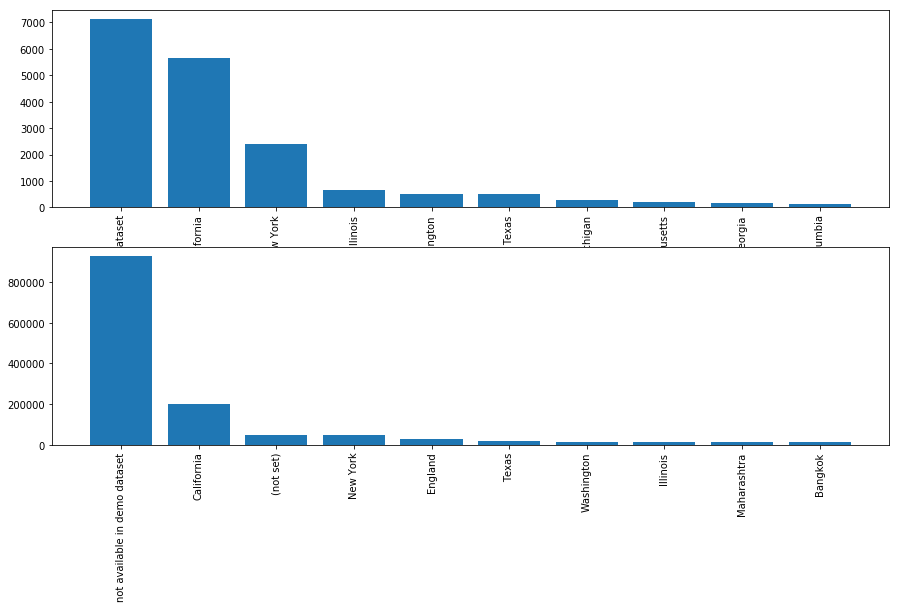

In [22]:
getplot(transaction_df,nontransaction_df,'geoNetwork.region');

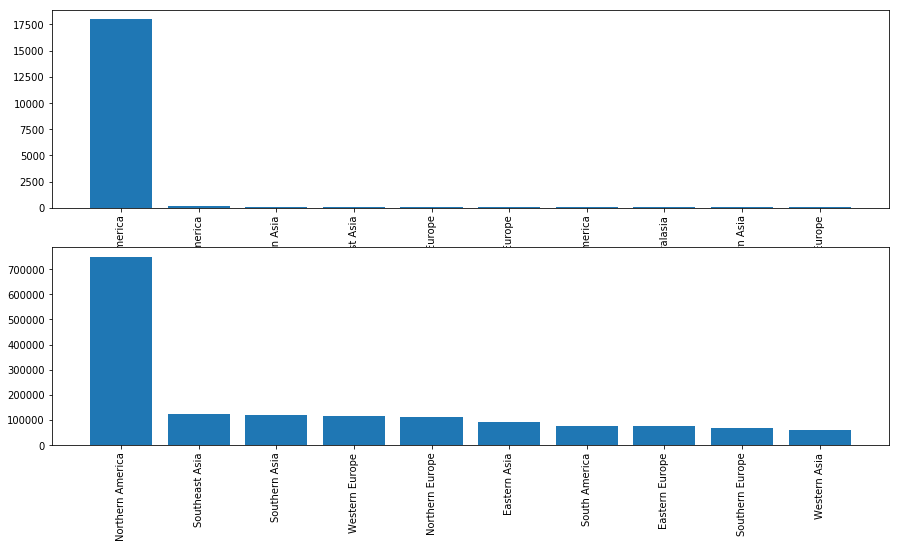

In [23]:
getplot(transaction_df,nontransaction_df,'geoNetwork.subContinent');

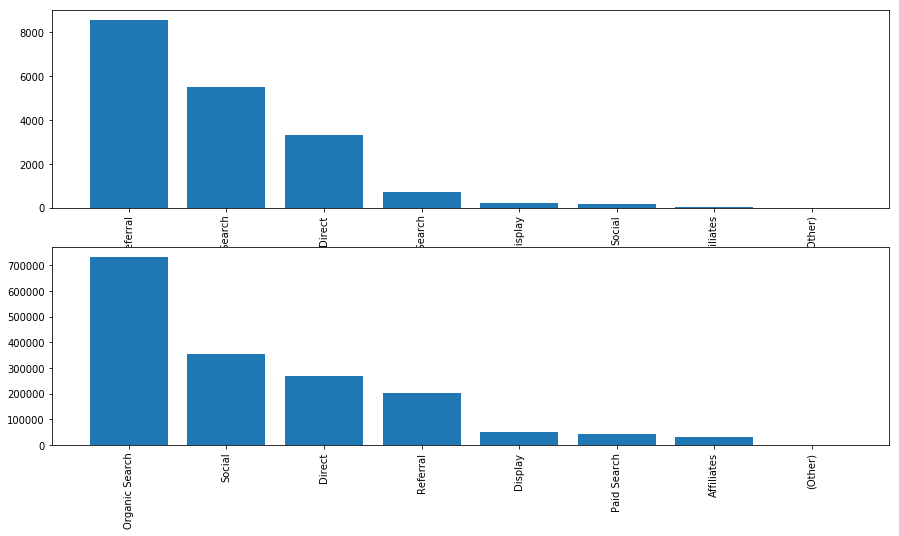

In [24]:
getplot(transaction_df,nontransaction_df,'channelGrouping');

In [25]:
# Lets drop labels other than city and subcontinent. 
# As city is the lower granular level in geo. 
# As most values in city is 'not available' lets keep another variable subcontinent as an additional field.

new_df1 = new_df.drop(labels=['geoNetwork.region','geoNetwork.networkDomain','geoNetwork.metro',
                              'geoNetwork.continent','geoNetwork.country','visitId','visitStartTime'],axis=1)
test_df1 = test_df.drop(labels=['geoNetwork.region','geoNetwork.networkDomain','geoNetwork.metro',
                                'geoNetwork.continent','geoNetwork.country','visitId','visitStartTime'],axis=1)

In [26]:
# With Date or Month we couldn't find any relation. Lets drop it. 
# device.isMobile is a duplicate variable as the detail is covered in deviceCategory

new_df1 = new_df1.drop(labels=['date','device.isMobile'], axis=1)
test_df1 = test_df1.drop(labels=['date','device.isMobile'], axis=1)

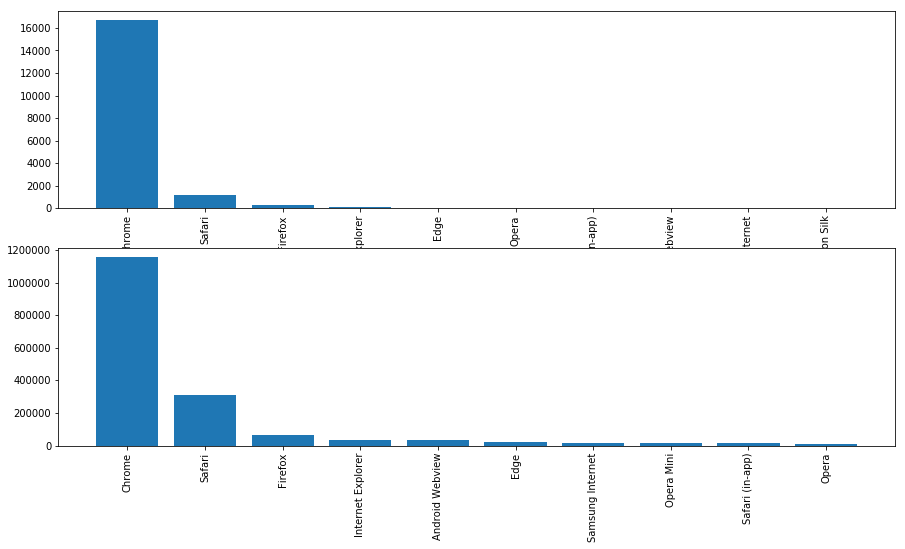

In [27]:
getplot(transaction_df,nontransaction_df,'device.browser');

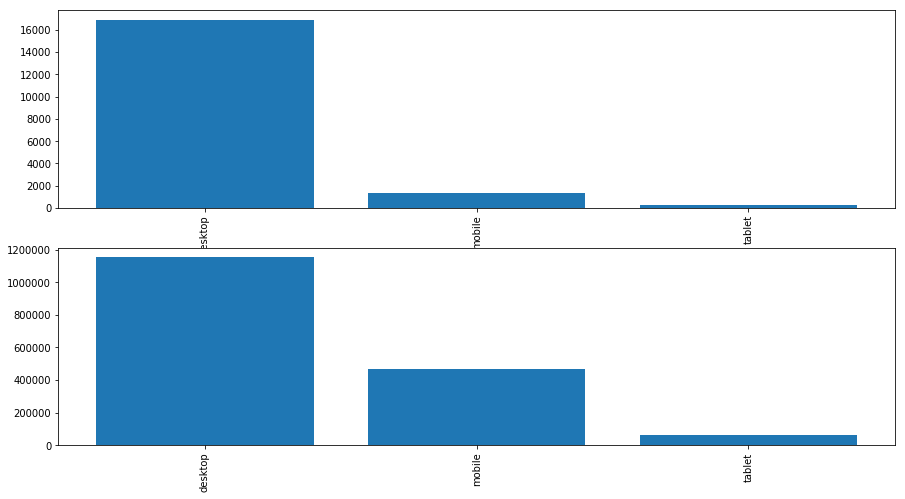

In [28]:
getplot(transaction_df,nontransaction_df,'device.deviceCategory');

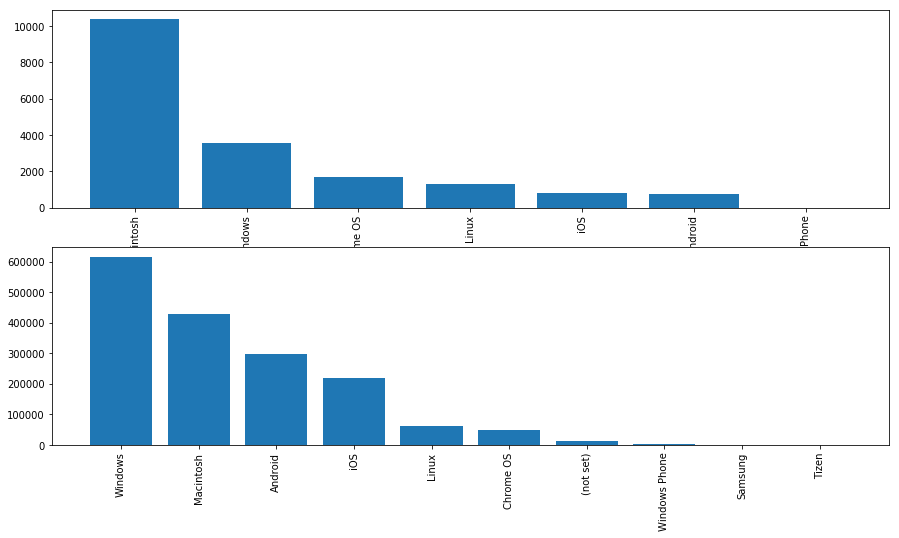

In [29]:
getplot(transaction_df,nontransaction_df,'device.operatingSystem');

/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(<BarContainer object of 10 artists>, <BarContainer object of 10 artists>)

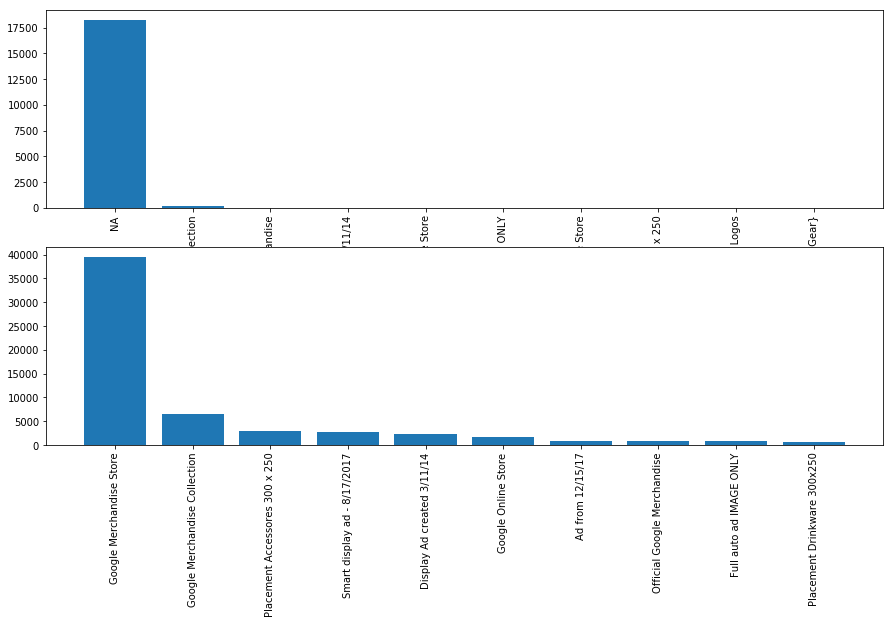

In [30]:
transaction_df['trafficSource.adContent'].fillna('NA',inplace=True)
getplot(transaction_df,nontransaction_df,'trafficSource.adContent')

(<BarContainer object of 10 artists>, <BarContainer object of 10 artists>)

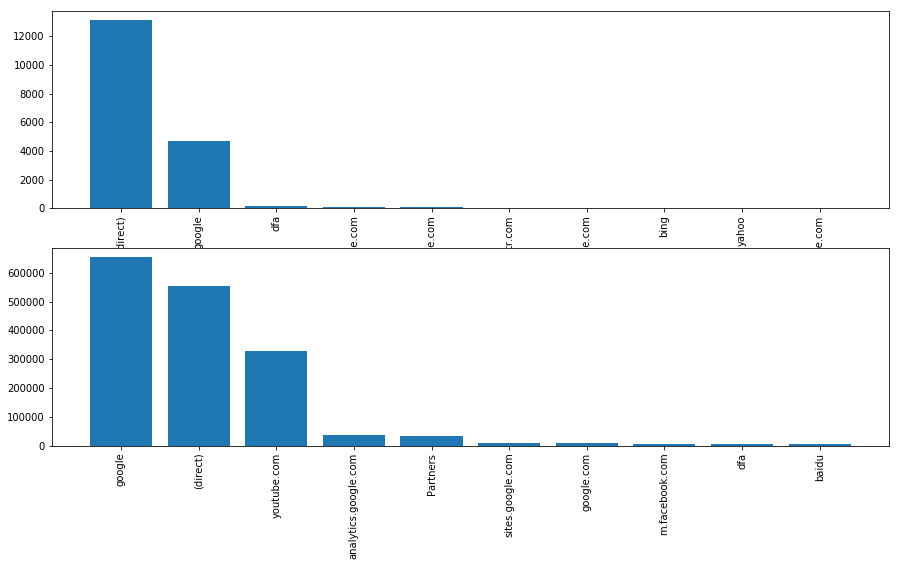

In [31]:
getplot(transaction_df,nontransaction_df,'trafficSource.source')

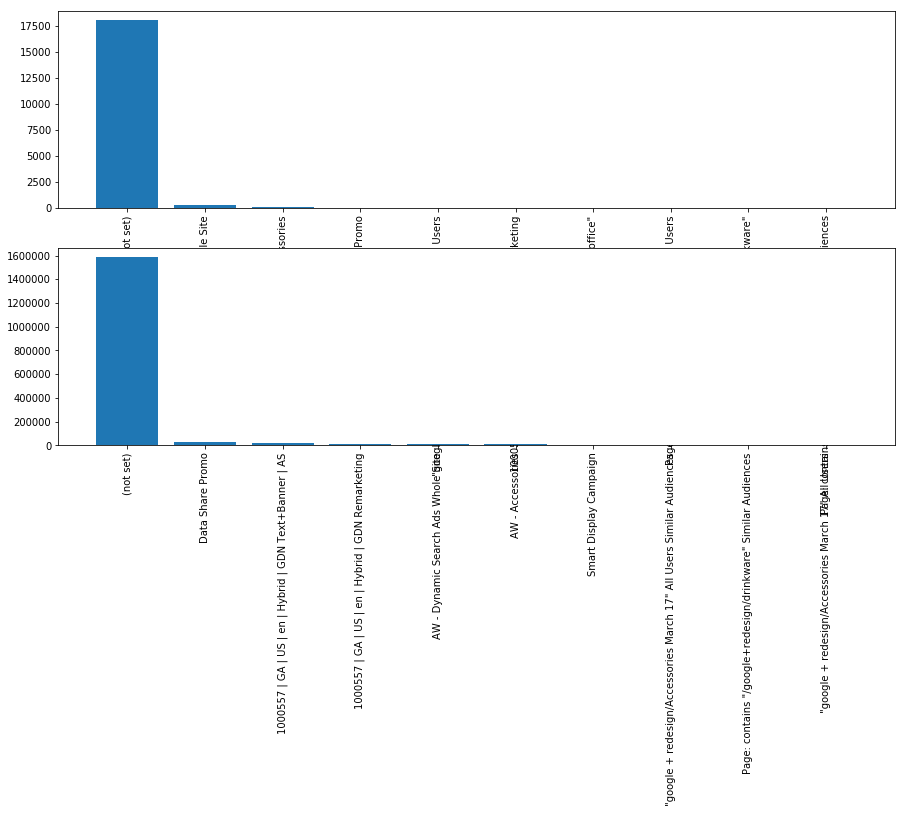

In [32]:
getplot(transaction_df,nontransaction_df,'trafficSource.campaign');

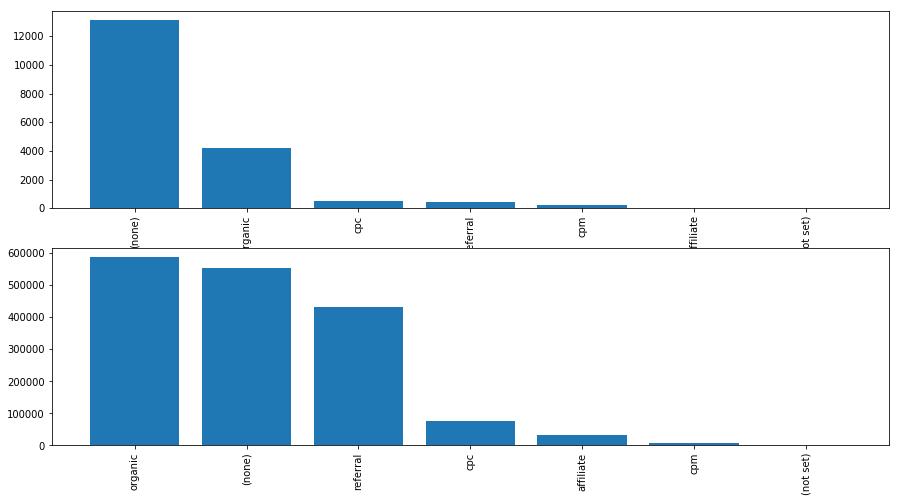

In [33]:
getplot(transaction_df,nontransaction_df,'trafficSource.medium');

/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


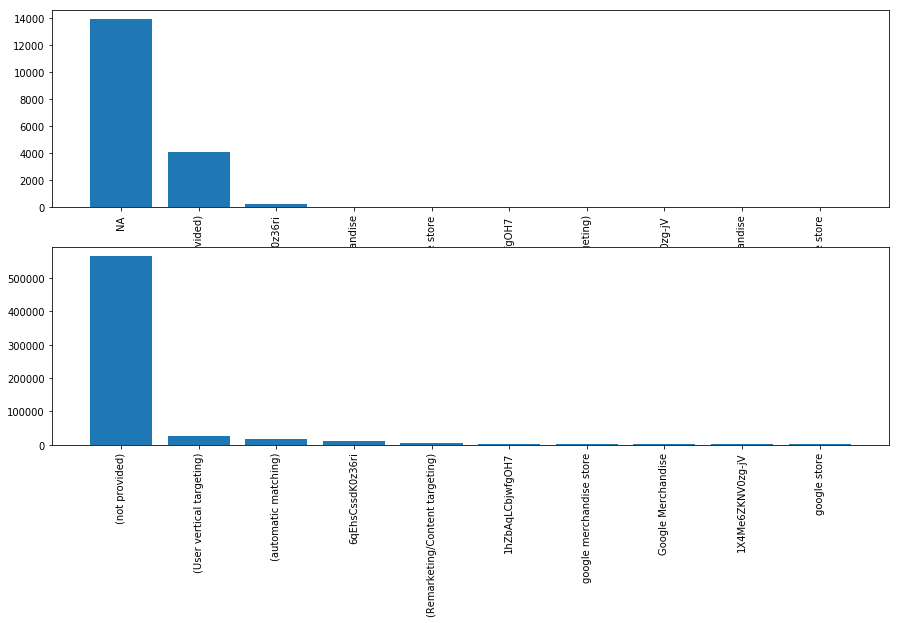

In [34]:
transaction_df['trafficSource.keyword'].fillna('NA',inplace=True)
getplot(transaction_df,nontransaction_df,'trafficSource.keyword');

/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


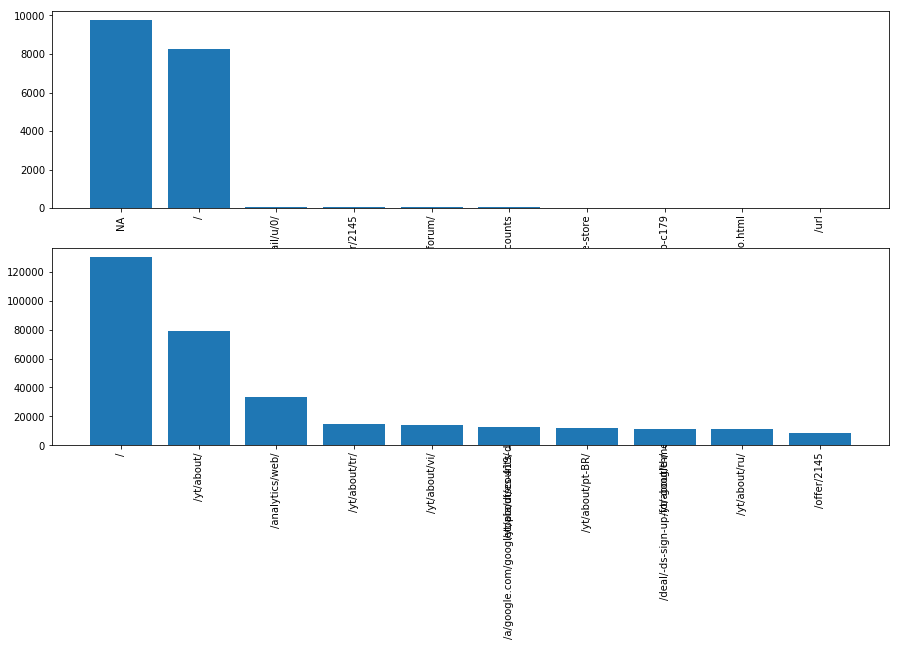

In [35]:
transaction_df['trafficSource.referralPath'].fillna('NA',inplace=True)
getplot(transaction_df,nontransaction_df,'trafficSource.referralPath');

In [36]:
# drop trafficSource.campaign, trafficSource.referralPath, and other ad features other than adcontent
new_df1 = new_df1.drop(labels=['trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 
                'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 
                                'trafficSource.referralPath'],axis=1)
test_df1 = test_df1.drop(labels=['trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 
                 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 
                                  'trafficSource.referralPath'],axis=1)
print(new_df1.shape)
new_df1.head()

(1708337, 18)


,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactions,trafficSource.adContent,trafficSource.keyword,trafficSource.medium,trafficSource.source
0,Organic Search,3162355547410993243,1,Firefox,desktop,Windows,not available in demo dataset,Western Europe,1,1,1,NaN,0.0,NaN,NaN,water bottle,organic,google
1,Referral,8934116514970143966,6,Chrome,desktop,Chrome OS,Cupertino,Northern America,2,2,2,28,0.0,NaN,NaN,NaN,referral,sites.google.com
2,Direct,7992466427990357681,1,Chrome,mobile,Android,not available in demo dataset,Northern America,2,2,1,38,0.0,NaN,NaN,NaN,(none),(direct)
3,Organic Search,9075655783635761930,1,Chrome,desktop,Windows,not available in demo dataset,Western Asia,2,2,1,1,0.0,NaN,NaN,(not provided),organic,google
4,Organic Search,6960673291025684308,1,Chrome,desktop,Windows,not available in demo dataset,Central America,2,2,1,52,0.0,NaN,NaN,(not provided),organic,google


In [37]:
new_df1.isna().sum()

channelGrouping                         0
fullVisitorId                           0
visitNumber                             0
device.browser                          0
device.deviceCategory                   0
device.operatingSystem                  0
geoNetwork.city                         0
geoNetwork.subContinent                 0
totals.hits                             0
totals.pageviews                      239
totals.sessionQualityDim           835274
totals.timeOnSite                  874294
totals.totalTransactionRevenue          0
totals.transactions               1689778
trafficSource.adContent           1643600
trafficSource.keyword             1052780
trafficSource.medium                    0
trafficSource.source                    0
dtype: int64

In [38]:
test_df1.isna().sum()

channelGrouping                  0
fullVisitorId                    0
visitNumber                      0
device.browser                   0
device.deviceCategory            0
device.operatingSystem           0
geoNetwork.city                  0
geoNetwork.subContinent          0
totals.hits                      0
totals.pageviews               101
totals.sessionQualityDim         0
totals.timeOnSite           183686
totals.transactions         395284
trafficSource.adContent          0
trafficSource.keyword        40226
trafficSource.medium             0
trafficSource.source             0
dtype: int64

In [39]:
# Impute remaining missing values
new_df1['trafficSource.adContent'].fillna('Noadcontent',inplace=True)
new_df1['trafficSource.keyword'].fillna('NA',inplace=True)
test_df1['trafficSource.adContent'].fillna('Noadcontent',inplace=True)
test_df1['trafficSource.keyword'].fillna('NA',inplace=True)

In [40]:
for columns in ['totals.pageviews','totals.sessionQualityDim','totals.timeOnSite','totals.transactions']:
    new_df1[columns].fillna('0',inplace=True)
    new_df1[columns] = new_df1[columns].astype('int')
    test_df1[columns].fillna('0',inplace=True)
    test_df1[columns] = test_df1[columns].astype('int')

In [41]:
# Load flattened hits and customdimensions
flatten_train1 = pd.read_csv('flattened_train_v2.csv')

/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,3,8,9,10,11,15,17,22,24,32,33,37,39,40,41,43,44,46,47,51,52,53,54,55,58,62,68,69,70,79,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
flatten_test1 = pd.read_csv('flattened_test_v2.csv')

/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,3,9,14,17,18,21,24,32,33,37,38,39,41,42,43,44,45,47,51,52,53,56,58,62,68,70,77,78,93,94,97,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [43]:
flatten_train1.isna().sum()

channelGrouping                                  8
date                                             0
device                                           3
fullVisitorId                                    1
geoNetwork                                       8
socialEngagementType                             0
totals                                           0
trafficSource                                    0
visitId                                          0
visitNumber                                      0
visitStartTime                                   6
customDimensions_index                      333235
customDimensions_value                      333243
hits_hitNumber                                1223
hits_time                                     1223
hits_hour                                     1215
hits_minute                                   1223
hits_isInteraction                            1223
hits_isEntrance                               5771
hits_isExit                    

In [44]:
# Find NAs that are introduced during flattening of 'hits' and 'customdimension'
flatten_train1.index[flatten_train1['channelGrouping'].isna()]

Int64Index([65781, 989560, 1190515, 1194852, 1261878, 1280822, 1357425,
            1663751],
           dtype='int64')

In [45]:
flatten_train1.index[flatten_train1['device'].isna()]

Int64Index([989560, 1261878, 1663751], dtype='int64')

In [46]:
flatten_train1.index[flatten_train1['fullVisitorId'].isna()]

Int64Index([989560], dtype='int64')

In [47]:
flatten_train1.index[flatten_train1['geoNetwork'].isna()]

Int64Index([65781, 989560, 1190515, 1194852, 1261878, 1280822, 1357425,
            1663751],
           dtype='int64')

In [48]:
flatten_train1.index[flatten_train1['visitStartTime'].isna()]

Int64Index([1190515, 1194852, 1261878, 1280822, 1357425, 1663751], dtype='int64')

In [49]:
flatten_test1.isna().sum()

channelGrouping                                 1
date                                            0
device                                          1
fullVisitorId                                   0
geoNetwork                                      0
socialEngagementType                            0
totals                                          0
trafficSource                                   0
visitId                                         1
visitNumber                                     0
visitStartTime                                  1
customDimensions_index                      60582
customDimensions_value                      60582
hits_hitNumber                                 59
hits_time                                      58
hits_hour                                      59
hits_minute                                    59
hits_isInteraction                             59
hits_eventInfo                             399622
hits_type                                      59


In [50]:
flatten_test1.index[flatten_test1['channelGrouping'].isna()]

Int64Index([139657], dtype='int64')

In [51]:
flatten_test1.index[flatten_test1['device'].isna()]

Int64Index([139657], dtype='int64')

In [52]:
flatten_test1.index[flatten_test1['visitId'].isna()]

Int64Index([139657], dtype='int64')

In [53]:
flatten_test1.index[flatten_test1['visitStartTime'].isna()]

Int64Index([139657], dtype='int64')

In [54]:
# Drop NAs
flatten_train1 = flatten_train1.drop([65781, 989560, 1190515, 1194852, 1261878, 1280822, 1357425, 1663751])
flatten_train1 = flatten_train1.reset_index()
flatten_train1 = flatten_train1.drop(['index'], axis=1)

flatten_test1 = flatten_test1.drop([139657])
flatten_test1 = flatten_test1.reset_index()
flatten_test1 = flatten_test1.drop(['index'], axis=1)

In [55]:
# Drop features other than hits and customdimension features to combine with new_df1, test_df1
flatten_train1 = flatten_train1.drop(labels=['channelGrouping','date','device','fullVisitorId','geoNetwork',
                                             'socialEngagementType','totals','trafficSource','visitId','visitNumber',
                                            'visitStartTime'],axis=1)

flatten_test1 = flatten_test1.drop(labels=['channelGrouping','date','device','fullVisitorId','geoNetwork',
                                             'socialEngagementType','totals','trafficSource','visitId','visitNumber',
                                            'visitStartTime'],axis=1)

In [56]:
print(flatten_train1.shape)
print(flatten_test1.shape)

(1708337, 90)
(401589, 90)


In [57]:
print(new_df1.shape)
print(test_df1.shape)

(1708337, 18)
(401589, 17)


In [58]:
# Impute missing values for flatten_train1, flatten_test1
# Combine train and test to process together

flatten_all = flatten_train1.append(flatten_test1,ignore_index=True)
flatten_all = flatten_all.drop(labels=flatten_all.columns[flatten_all.nunique()==1], axis=1)
col_names = list(flatten_all)
num_row = flatten_all.shape[0]
print(flatten_all.shape)

/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(2109926, 68)


In [59]:
col = list(flatten_all.columns[flatten_all.dtypes == float])
x = []
for column in col:
    a=flatten_all[column].isna().sum()
    x.append(a)
print(col)
print(x)

['hits_contentGroup_0', 'hits_eCommerceAction_step', 'hits_hitNumber', 'hits_minute', 'hits_page_0', 'hits_product_localProductPrice', 'hits_product_localProductRevenue', 'hits_product_productListPosition', 'hits_product_productPrice', 'hits_product_productQuantity', 'hits_product_productRevenue', 'hits_promotionActionInfo_0', 'hits_transaction_0']
[2109926, 1282, 1273, 1273, 2109926, 1479189, 2109911, 1479189, 1479189, 2108705, 2109911, 2109926, 2109926]


In [60]:
flatten_all.columns.to_series().groupby(flatten_all.dtypes).groups

{dtype('float64'): Index(['hits_contentGroup_0', 'hits_eCommerceAction_step', 'hits_hitNumber',
        'hits_minute', 'hits_page_0', 'hits_product_localProductPrice',
        'hits_product_localProductRevenue', 'hits_product_productListPosition',
        'hits_product_productPrice', 'hits_product_productQuantity',
        'hits_product_productRevenue', 'hits_promotionActionInfo_0',
        'hits_transaction_0'],
       dtype='object'),
 dtype('O'): Index(['customDimensions_index', 'customDimensions_value', 'hits_appInfo_0',
        'hits_appInfo_exitScreenName', 'hits_appInfo_landingScreenName',
        'hits_appInfo_screenDepth', 'hits_appInfo_screenName',
        'hits_contentGroup_contentGroup1', 'hits_contentGroup_contentGroup2',
        'hits_contentGroup_contentGroup3',
        'hits_contentGroup_contentGroupUniqueViews1',
        'hits_contentGroup_contentGroupUniqueViews2',
        'hits_contentGroup_contentGroupUniqueViews3', 'hits_dataSource',
        'hits_eCommerceAction_0

In [61]:
for columns in col_names:
    if flatten_all[columns].dtype == 'float64':
        if flatten_all[columns].isna().sum()/num_row > 0.8:
            flatten_all = flatten_all.drop(labels=[columns], axis=1)
        else:
            flatten_all[columns].fillna('0',inplace=True)
            flatten_all[columns] = flatten_all[columns].astype('float')
    else:
        flatten_all[columns].fillna('NA',inplace=True)

In [62]:
print(flatten_all.shape)

(2109926, 61)


In [63]:
# combine new_df1 with flatten_train1, and test_df1 with flatten_test1

y_train = new_df1['totals.totalTransactionRevenue']
new_df1 = new_df1.drop(labels=['totals.totalTransactionRevenue'], axis=1) 
new_df1 = new_df1.append(test_df1, ignore_index=True)
features_processed = pd.concat([new_df1.reset_index(drop=True),flatten_all.reset_index(drop=True)], axis=1)

In [64]:
print(features_processed.shape)

(2109926, 78)


In [65]:
# Check no NAs
w = list(features_processed.isna().sum())
print(w.count(0))

78


In [66]:
print(features_processed.columns[features_processed.nunique() > 1500] &
      features_processed.columns[features_processed.dtypes == object])
print(features_processed.columns[features_processed.nunique()>200] & 
      features_processed.columns[features_processed.dtypes == object])

Index(['fullVisitorId', 'trafficSource.keyword', 'hits_appInfo_exitScreenName',
       'hits_appInfo_landingScreenName', 'hits_appInfo_screenName',
       'hits_page_pagePath', 'hits_referer'],
      dtype='object')
Index(['fullVisitorId', 'geoNetwork.city', 'totals.hits',
       'trafficSource.keyword', 'trafficSource.source',
       'hits_appInfo_exitScreenName', 'hits_appInfo_landingScreenName',
       'hits_appInfo_screenName', 'hits_eventInfo', 'hits_page_pagePath',
       'hits_page_pagePathLevel3', 'hits_page_pagePathLevel4',
       'hits_page_pageTitle', 'hits_product_productSKU',
       'hits_product_v2ProductName', 'hits_referer'],
      dtype='object')


In [67]:
# Drop Id and redundant features, features too many levels for processing

features_id = features_processed['fullVisitorId']
features_processed = features_processed.drop(labels=features_processed.columns[features_processed.nunique() > 1500] & 
                                             features_processed.columns[features_processed.dtypes == object], axis=1)
features_processed = features_processed.drop(labels=['hits_eventInfo', 'hits_page_pagePathLevel3',
       'hits_page_pagePathLevel4'], axis=1)

In [68]:
features_processed.columns.to_series().groupby(features_processed.dtypes).groups

{dtype('int64'): Index(['visitNumber', 'totals.pageviews', 'totals.sessionQualityDim',
        'totals.timeOnSite', 'totals.transactions'],
       dtype='object'),
 dtype('float64'): Index(['hits_eCommerceAction_step', 'hits_hitNumber', 'hits_minute',
        'hits_product_localProductPrice', 'hits_product_productListPosition',
        'hits_product_productPrice'],
       dtype='object'),
 dtype('O'): Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
        'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.subContinent',
        'totals.hits', 'trafficSource.adContent', 'trafficSource.medium',
        'trafficSource.source', 'customDimensions_index',
        'customDimensions_value', 'hits_appInfo_0', 'hits_appInfo_screenDepth',
        'hits_contentGroup_contentGroup1', 'hits_contentGroup_contentGroup2',
        'hits_contentGroup_contentGroup3',
        'hits_contentGroup_contentGroupUniqueViews1',
        'hits_contentGroup_contentGroupUniqueViews2',
     

In [69]:
col_names1 = list(features_processed.columns[features_processed.dtypes == object])
print(len(col_names1))

57


In [70]:
# Convert categorical features into dummy

def convert_category_todummies(df,field):
    dummy_df = pd.get_dummies(df[field])
    df = pd.concat([df,dummy_df],axis=1)
    df.drop(labels=[field],axis=1,inplace=True)
    return df

def convert_category_tolevel(df,field):
    df[field],index = pd.factorize(df[field])
    return df

In [71]:
%%time
for fields in col_names1:
    if len(features_processed[fields].unique()) > 200:
        features_processed[fields] = convert_category_tolevel(features_processed,fields)
        features_processed[fields] = features_processed[fields].astype('int')
    else: 
        features_processed = convert_category_todummies(features_processed,fields)

CPU times: user 5min 44s, sys: 2min 19s, total: 8min 4s
Wall time: 8min 4s


In [72]:
features_processed.shape

(2109926, 1273)

In [113]:
features_processed1 = pd.concat([features_processed, features_id], axis=1)

In [116]:
# Group by fullVisitorId
train = features_processed1[:1708337].groupby(by=['fullVisitorId']).mean()

In [118]:
train.shape

(1323730, 1273)

In [122]:
y_train1 = pd.concat([y_train, features_id[:1708337]], axis=1)

In [126]:
y_train2 = y_train1.groupby(by=['fullVisitorId']).mean()

In [130]:
y_train2.shape

(1323730, 1)

In [131]:
# Convert Y to log(n+1)
y_train2['totals.totalTransactionRevenue'] = np.log1p(y_train2['totals.totalTransactionRevenue'])

In [134]:
test = features_processed1[1708337:].groupby(by=['fullVisitorId']).mean()

In [135]:
test.shape

(296530, 1273)

In [136]:
# Standardization
from sklearn.preprocessing import StandardScaler

In [153]:
%%time
stdsc = StandardScaler()
x_train = stdsc.fit_transform(train.values)
x_test = stdsc.transform(test.values)

CPU times: user 29.2 s, sys: 21.6 s, total: 50.8 s
Wall time: 50.8 s


In [154]:
x_train = pd.DataFrame(x_train, columns=train.columns)
x_test = pd.DataFrame(x_test, columns=train.columns)

In [192]:
# PCA
from sklearn.decomposition import PCA

In [193]:
# GB model
import lightgbm as lgb

In [194]:
n_components = []
for i in range(100):
    if 30 + i*20 < 1000:
        n = 30 + i*20
        n_components.append(n)
print(len(n_components))

49


In [202]:
y_train3 = y_train2.values

In [204]:
y_train3.shape

(1323730, 1)

In [205]:
y_train3 = pd.DataFrame(y_train3, columns=y_train2.columns)

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train3, test_size=0.3, random_state=1)

In [240]:
# Validation to find best PCA component
def func_pca_lgb(n, x_train, y_train, x_val, y_val, params, num_round):
    pca = PCA(n_components=n)
    x_train_reduced = pca.fit_transform(x_train)
    x_test_reduced = pca.transform(x_val)
    lgb_train_data = lgb.Dataset(x_train_reduced, label=y_train)
    lgb_val_data = lgb.Dataset(x_test_reduced, label=y_val)
    rmse_val = lgb.train(params, lgb_train_data, num_round, early_stopping_rounds=20, 
                         valid_sets=[lgb_train_data, lgb_val_data])
    return rmse_val

In [242]:
%%time
num_round = 500
params = {"objective" : "regression",
        "metric" : "rmse",
        #"num_leaves" : 40,
        "max_depth" : 10,
        "boosting" : "gbdt",
        "learning_rate" : 0.0025,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "seed": 42}

rmse_val1=[]
rmse_train1=[]
for n in n_components:
    rmse_val = func_pca_lgb(n, X_train, Y_train, X_val, Y_val, params, num_round)
    y_pred_train = rmse_val.predict(X_train, num_iteration=rmse_val.best_iteration)
    y_pred_val = rmse_val.predict(X_val, num_iteration=rmse_val.best_iteration)
    val_rmse = np.sqrt(mean_squared_error(Y_val, y_pred_val))
    train_rmse = np.sqrt(mean_squared_error(Y_train, y_pred_train))
    rmse_val1.append(val_rmse)
    rmse_train1.append(train_rmse)

[1]	training's rmse: 1.87185	valid_1's rmse: 1.86866
Training until validation scores don't improve for 20 rounds.
[2]	training's rmse: 1.86949	valid_1's rmse: 1.86638
[3]	training's rmse: 1.86701	valid_1's rmse: 1.86393
[4]	training's rmse: 1.86472	valid_1's rmse: 1.86182
[5]	training's rmse: 1.86222	valid_1's rmse: 1.85937
[6]	training's rmse: 1.85966	valid_1's rmse: 1.85689
[7]	training's rmse: 1.85739	valid_1's rmse: 1.85469
[8]	training's rmse: 1.85487	valid_1's rmse: 1.85218
[9]	training's rmse: 1.85262	valid_1's rmse: 1.84999
[10]	training's rmse: 1.85023	valid_1's rmse: 1.84763
[11]	training's rmse: 1.84799	valid_1's rmse: 1.84542
[12]	training's rmse: 1.84644	valid_1's rmse: 1.84406
[13]	training's rmse: 1.84443	valid_1's rmse: 1.84215
[14]	training's rmse: 1.84246	valid_1's rmse: 1.84042
[15]	training's rmse: 1.84004	valid_1's rmse: 1.83819
[16]	training's rmse: 1.83809	valid_1's rmse: 1.83651
[17]	training's rmse: 1.83567	valid_1's rmse: 1.83424
[18]	training's rmse: 1.8333	

[164]	training's rmse: 1.56354	valid_1's rmse: 1.5735
[165]	training's rmse: 1.56249	valid_1's rmse: 1.57264
[166]	training's rmse: 1.5611	valid_1's rmse: 1.5713
[167]	training's rmse: 1.55991	valid_1's rmse: 1.57032
[168]	training's rmse: 1.55846	valid_1's rmse: 1.56893
[169]	training's rmse: 1.55702	valid_1's rmse: 1.56763
[170]	training's rmse: 1.55569	valid_1's rmse: 1.56638
[171]	training's rmse: 1.5541	valid_1's rmse: 1.56484
[172]	training's rmse: 1.55276	valid_1's rmse: 1.56352
[173]	training's rmse: 1.55111	valid_1's rmse: 1.56188
[174]	training's rmse: 1.54954	valid_1's rmse: 1.56037
[175]	training's rmse: 1.54801	valid_1's rmse: 1.55889
[176]	training's rmse: 1.54646	valid_1's rmse: 1.55735
[177]	training's rmse: 1.54487	valid_1's rmse: 1.55581
[178]	training's rmse: 1.54331	valid_1's rmse: 1.55425
[179]	training's rmse: 1.54171	valid_1's rmse: 1.55266
[180]	training's rmse: 1.54032	valid_1's rmse: 1.55131
[181]	training's rmse: 1.53901	valid_1's rmse: 1.55003
[182]	training

[320]	training's rmse: 1.37397	valid_1's rmse: 1.39324
[321]	training's rmse: 1.37297	valid_1's rmse: 1.3923
[322]	training's rmse: 1.37186	valid_1's rmse: 1.39118
[323]	training's rmse: 1.37105	valid_1's rmse: 1.39047
[324]	training's rmse: 1.36999	valid_1's rmse: 1.38945
[325]	training's rmse: 1.3689	valid_1's rmse: 1.38841
[326]	training's rmse: 1.36809	valid_1's rmse: 1.3877
[327]	training's rmse: 1.36707	valid_1's rmse: 1.38672
[328]	training's rmse: 1.36629	valid_1's rmse: 1.38597
[329]	training's rmse: 1.3654	valid_1's rmse: 1.3852
[330]	training's rmse: 1.36441	valid_1's rmse: 1.38426
[331]	training's rmse: 1.36351	valid_1's rmse: 1.38344
[332]	training's rmse: 1.36255	valid_1's rmse: 1.3825
[333]	training's rmse: 1.36195	valid_1's rmse: 1.38196
[334]	training's rmse: 1.3609	valid_1's rmse: 1.38096
[335]	training's rmse: 1.36007	valid_1's rmse: 1.3802
[336]	training's rmse: 1.35905	valid_1's rmse: 1.37923
[337]	training's rmse: 1.35815	valid_1's rmse: 1.37837
[338]	training's r

[474]	training's rmse: 1.25234	valid_1's rmse: 1.27862
[475]	training's rmse: 1.25168	valid_1's rmse: 1.27799
[476]	training's rmse: 1.25106	valid_1's rmse: 1.27745
[477]	training's rmse: 1.25037	valid_1's rmse: 1.27681
[478]	training's rmse: 1.2498	valid_1's rmse: 1.2763
[479]	training's rmse: 1.24922	valid_1's rmse: 1.27574
[480]	training's rmse: 1.24862	valid_1's rmse: 1.27518
[481]	training's rmse: 1.24823	valid_1's rmse: 1.27487
[482]	training's rmse: 1.24763	valid_1's rmse: 1.27429
[483]	training's rmse: 1.24696	valid_1's rmse: 1.27367
[484]	training's rmse: 1.24649	valid_1's rmse: 1.27327
[485]	training's rmse: 1.24591	valid_1's rmse: 1.27273
[486]	training's rmse: 1.24523	valid_1's rmse: 1.27205
[487]	training's rmse: 1.24454	valid_1's rmse: 1.27141
[488]	training's rmse: 1.24389	valid_1's rmse: 1.27079
[489]	training's rmse: 1.24336	valid_1's rmse: 1.2703
[490]	training's rmse: 1.24274	valid_1's rmse: 1.26971
[491]	training's rmse: 1.2421	valid_1's rmse: 1.26907
[492]	training

[124]	training's rmse: 1.61665	valid_1's rmse: 1.64004
[125]	training's rmse: 1.61488	valid_1's rmse: 1.63833
[126]	training's rmse: 1.61307	valid_1's rmse: 1.63674
[127]	training's rmse: 1.61125	valid_1's rmse: 1.63494
[128]	training's rmse: 1.60943	valid_1's rmse: 1.63339
[129]	training's rmse: 1.60759	valid_1's rmse: 1.63181
[130]	training's rmse: 1.6059	valid_1's rmse: 1.63011
[131]	training's rmse: 1.60421	valid_1's rmse: 1.62871
[132]	training's rmse: 1.60245	valid_1's rmse: 1.6272
[133]	training's rmse: 1.60071	valid_1's rmse: 1.62569
[134]	training's rmse: 1.59896	valid_1's rmse: 1.62419
[135]	training's rmse: 1.59737	valid_1's rmse: 1.62294
[136]	training's rmse: 1.59562	valid_1's rmse: 1.62146
[137]	training's rmse: 1.59393	valid_1's rmse: 1.62003
[138]	training's rmse: 1.5922	valid_1's rmse: 1.6183
[139]	training's rmse: 1.59047	valid_1's rmse: 1.61683
[140]	training's rmse: 1.58869	valid_1's rmse: 1.61504
[141]	training's rmse: 1.58697	valid_1's rmse: 1.61356
[142]	training

[286]	training's rmse: 1.39157	valid_1's rmse: 1.43456
[287]	training's rmse: 1.3904	valid_1's rmse: 1.43364
[288]	training's rmse: 1.38939	valid_1's rmse: 1.43268
[289]	training's rmse: 1.38858	valid_1's rmse: 1.43197
[290]	training's rmse: 1.3875	valid_1's rmse: 1.43108
[291]	training's rmse: 1.3864	valid_1's rmse: 1.42996
[292]	training's rmse: 1.38527	valid_1's rmse: 1.42896
[293]	training's rmse: 1.38415	valid_1's rmse: 1.42795
[294]	training's rmse: 1.38319	valid_1's rmse: 1.42703
[295]	training's rmse: 1.38209	valid_1's rmse: 1.42613
[296]	training's rmse: 1.38096	valid_1's rmse: 1.42498
[297]	training's rmse: 1.37987	valid_1's rmse: 1.4241
[298]	training's rmse: 1.37893	valid_1's rmse: 1.42326
[299]	training's rmse: 1.37786	valid_1's rmse: 1.42233
[300]	training's rmse: 1.37677	valid_1's rmse: 1.42139
[301]	training's rmse: 1.37568	valid_1's rmse: 1.42043
[302]	training's rmse: 1.37456	valid_1's rmse: 1.41931
[303]	training's rmse: 1.37354	valid_1's rmse: 1.41846
[304]	training

[448]	training's rmse: 1.24931	valid_1's rmse: 1.30408
[449]	training's rmse: 1.24865	valid_1's rmse: 1.30346
[450]	training's rmse: 1.24797	valid_1's rmse: 1.30295
[451]	training's rmse: 1.24734	valid_1's rmse: 1.30233
[452]	training's rmse: 1.24665	valid_1's rmse: 1.30163
[453]	training's rmse: 1.24601	valid_1's rmse: 1.30109
[454]	training's rmse: 1.24521	valid_1's rmse: 1.30028
[455]	training's rmse: 1.24453	valid_1's rmse: 1.29973
[456]	training's rmse: 1.24379	valid_1's rmse: 1.29898
[457]	training's rmse: 1.24301	valid_1's rmse: 1.29819
[458]	training's rmse: 1.24227	valid_1's rmse: 1.29754
[459]	training's rmse: 1.24157	valid_1's rmse: 1.29694
[460]	training's rmse: 1.24088	valid_1's rmse: 1.29631
[461]	training's rmse: 1.24021	valid_1's rmse: 1.29563
[462]	training's rmse: 1.23958	valid_1's rmse: 1.29501
[463]	training's rmse: 1.23881	valid_1's rmse: 1.29422
[464]	training's rmse: 1.23805	valid_1's rmse: 1.29344
[465]	training's rmse: 1.23737	valid_1's rmse: 1.29277
[466]	trai

[97]	training's rmse: 1.65708	valid_1's rmse: 1.65917
[98]	training's rmse: 1.65509	valid_1's rmse: 1.6572
[99]	training's rmse: 1.6532	valid_1's rmse: 1.65538
[100]	training's rmse: 1.65118	valid_1's rmse: 1.65339
[101]	training's rmse: 1.6492	valid_1's rmse: 1.65142
[102]	training's rmse: 1.64723	valid_1's rmse: 1.64951
[103]	training's rmse: 1.64528	valid_1's rmse: 1.64757
[104]	training's rmse: 1.64331	valid_1's rmse: 1.64563
[105]	training's rmse: 1.64129	valid_1's rmse: 1.64365
[106]	training's rmse: 1.63948	valid_1's rmse: 1.64195
[107]	training's rmse: 1.63764	valid_1's rmse: 1.64011
[108]	training's rmse: 1.63573	valid_1's rmse: 1.63824
[109]	training's rmse: 1.63396	valid_1's rmse: 1.63655
[110]	training's rmse: 1.63199	valid_1's rmse: 1.63459
[111]	training's rmse: 1.63009	valid_1's rmse: 1.63273
[112]	training's rmse: 1.62835	valid_1's rmse: 1.63107
[113]	training's rmse: 1.62665	valid_1's rmse: 1.62944
[114]	training's rmse: 1.625	valid_1's rmse: 1.62786
[115]	training's r

[255]	training's rmse: 1.4083	valid_1's rmse: 1.41812
[256]	training's rmse: 1.40698	valid_1's rmse: 1.41682
[257]	training's rmse: 1.40591	valid_1's rmse: 1.41579
[258]	training's rmse: 1.40485	valid_1's rmse: 1.41479
[259]	training's rmse: 1.40352	valid_1's rmse: 1.41353
[260]	training's rmse: 1.40225	valid_1's rmse: 1.41229
[261]	training's rmse: 1.40097	valid_1's rmse: 1.41102
[262]	training's rmse: 1.39963	valid_1's rmse: 1.40975
[263]	training's rmse: 1.39837	valid_1's rmse: 1.40856
[264]	training's rmse: 1.39702	valid_1's rmse: 1.40725
[265]	training's rmse: 1.39595	valid_1's rmse: 1.40623
[266]	training's rmse: 1.39461	valid_1's rmse: 1.40493
[267]	training's rmse: 1.39336	valid_1's rmse: 1.40373
[268]	training's rmse: 1.39212	valid_1's rmse: 1.40253
[269]	training's rmse: 1.39087	valid_1's rmse: 1.40131
[270]	training's rmse: 1.3897	valid_1's rmse: 1.40019
[271]	training's rmse: 1.38849	valid_1's rmse: 1.39904
[272]	training's rmse: 1.38725	valid_1's rmse: 1.39784
[273]	traini

[410]	training's rmse: 1.25123	valid_1's rmse: 1.26636
[411]	training's rmse: 1.25045	valid_1's rmse: 1.2656
[412]	training's rmse: 1.24961	valid_1's rmse: 1.26479
[413]	training's rmse: 1.24885	valid_1's rmse: 1.26406
[414]	training's rmse: 1.24796	valid_1's rmse: 1.2632
[415]	training's rmse: 1.24713	valid_1's rmse: 1.26237
[416]	training's rmse: 1.24635	valid_1's rmse: 1.2616
[417]	training's rmse: 1.24571	valid_1's rmse: 1.26099
[418]	training's rmse: 1.24497	valid_1's rmse: 1.26028
[419]	training's rmse: 1.24435	valid_1's rmse: 1.25969
[420]	training's rmse: 1.24356	valid_1's rmse: 1.25893
[421]	training's rmse: 1.24274	valid_1's rmse: 1.25815
[422]	training's rmse: 1.24191	valid_1's rmse: 1.25734
[423]	training's rmse: 1.24111	valid_1's rmse: 1.25657
[424]	training's rmse: 1.24027	valid_1's rmse: 1.25577
[425]	training's rmse: 1.23944	valid_1's rmse: 1.25495
[426]	training's rmse: 1.23866	valid_1's rmse: 1.25417
[427]	training's rmse: 1.23793	valid_1's rmse: 1.25348
[428]	trainin

[60]	training's rmse: 1.72828	valid_1's rmse: 1.72758
[61]	training's rmse: 1.72628	valid_1's rmse: 1.72564
[62]	training's rmse: 1.72388	valid_1's rmse: 1.72327
[63]	training's rmse: 1.72154	valid_1's rmse: 1.72095
[64]	training's rmse: 1.71948	valid_1's rmse: 1.71898
[65]	training's rmse: 1.71714	valid_1's rmse: 1.71672
[66]	training's rmse: 1.71514	valid_1's rmse: 1.71482
[67]	training's rmse: 1.71276	valid_1's rmse: 1.71248
[68]	training's rmse: 1.71081	valid_1's rmse: 1.71054
[69]	training's rmse: 1.70852	valid_1's rmse: 1.70827
[70]	training's rmse: 1.70621	valid_1's rmse: 1.70598
[71]	training's rmse: 1.7039	valid_1's rmse: 1.70374
[72]	training's rmse: 1.70188	valid_1's rmse: 1.70183
[73]	training's rmse: 1.69961	valid_1's rmse: 1.69956
[74]	training's rmse: 1.6973	valid_1's rmse: 1.69727
[75]	training's rmse: 1.69501	valid_1's rmse: 1.69499
[76]	training's rmse: 1.69278	valid_1's rmse: 1.69277
[77]	training's rmse: 1.69052	valid_1's rmse: 1.69052
[78]	training's rmse: 1.68821	

[211]	training's rmse: 1.44905	valid_1's rmse: 1.45305
[212]	training's rmse: 1.44749	valid_1's rmse: 1.45153
[213]	training's rmse: 1.44591	valid_1's rmse: 1.44994
[214]	training's rmse: 1.44453	valid_1's rmse: 1.4486
[215]	training's rmse: 1.44297	valid_1's rmse: 1.44706
[216]	training's rmse: 1.44144	valid_1's rmse: 1.44553
[217]	training's rmse: 1.43991	valid_1's rmse: 1.44401
[218]	training's rmse: 1.43838	valid_1's rmse: 1.44247
[219]	training's rmse: 1.43711	valid_1's rmse: 1.44127
[220]	training's rmse: 1.43559	valid_1's rmse: 1.43976
[221]	training's rmse: 1.43428	valid_1's rmse: 1.43855
[222]	training's rmse: 1.43291	valid_1's rmse: 1.43726
[223]	training's rmse: 1.43134	valid_1's rmse: 1.43567
[224]	training's rmse: 1.42981	valid_1's rmse: 1.43416
[225]	training's rmse: 1.4283	valid_1's rmse: 1.43267
[226]	training's rmse: 1.42713	valid_1's rmse: 1.43154
[227]	training's rmse: 1.42563	valid_1's rmse: 1.43008
[228]	training's rmse: 1.42415	valid_1's rmse: 1.4286
[229]	trainin

[374]	training's rmse: 1.25633	valid_1's rmse: 1.2638
[375]	training's rmse: 1.25558	valid_1's rmse: 1.26306
[376]	training's rmse: 1.25456	valid_1's rmse: 1.26208
[377]	training's rmse: 1.25353	valid_1's rmse: 1.26104
[378]	training's rmse: 1.25253	valid_1's rmse: 1.26005
[379]	training's rmse: 1.25158	valid_1's rmse: 1.25911
[380]	training's rmse: 1.2506	valid_1's rmse: 1.25815
[381]	training's rmse: 1.24964	valid_1's rmse: 1.2572
[382]	training's rmse: 1.24866	valid_1's rmse: 1.25623
[383]	training's rmse: 1.24795	valid_1's rmse: 1.25556
[384]	training's rmse: 1.24697	valid_1's rmse: 1.2546
[385]	training's rmse: 1.24597	valid_1's rmse: 1.25359
[386]	training's rmse: 1.24503	valid_1's rmse: 1.25266
[387]	training's rmse: 1.24408	valid_1's rmse: 1.25173
[388]	training's rmse: 1.24331	valid_1's rmse: 1.25096
[389]	training's rmse: 1.24236	valid_1's rmse: 1.25002
[390]	training's rmse: 1.24143	valid_1's rmse: 1.2491
[391]	training's rmse: 1.24082	valid_1's rmse: 1.24852
[392]	training'

[23]	training's rmse: 1.81473	valid_1's rmse: 1.8113
[24]	training's rmse: 1.81207	valid_1's rmse: 1.80862
[25]	training's rmse: 1.80942	valid_1's rmse: 1.80597
[26]	training's rmse: 1.80678	valid_1's rmse: 1.80331
[27]	training's rmse: 1.80414	valid_1's rmse: 1.80064
[28]	training's rmse: 1.80186	valid_1's rmse: 1.79838
[29]	training's rmse: 1.79923	valid_1's rmse: 1.79571
[30]	training's rmse: 1.79708	valid_1's rmse: 1.7936
[31]	training's rmse: 1.79453	valid_1's rmse: 1.79106
[32]	training's rmse: 1.79198	valid_1's rmse: 1.78851
[33]	training's rmse: 1.79008	valid_1's rmse: 1.78664
[34]	training's rmse: 1.78801	valid_1's rmse: 1.78457
[35]	training's rmse: 1.78592	valid_1's rmse: 1.78248
[36]	training's rmse: 1.78332	valid_1's rmse: 1.77984
[37]	training's rmse: 1.78106	valid_1's rmse: 1.77759
[38]	training's rmse: 1.7785	valid_1's rmse: 1.77502
[39]	training's rmse: 1.77593	valid_1's rmse: 1.77241
[40]	training's rmse: 1.77336	valid_1's rmse: 1.76985
[41]	training's rmse: 1.77077	v

[175]	training's rmse: 1.50138	valid_1's rmse: 1.4981
[176]	training's rmse: 1.49971	valid_1's rmse: 1.49643
[177]	training's rmse: 1.49833	valid_1's rmse: 1.49507
[178]	training's rmse: 1.4966	valid_1's rmse: 1.49332
[179]	training's rmse: 1.49485	valid_1's rmse: 1.49158
[180]	training's rmse: 1.49313	valid_1's rmse: 1.48984
[181]	training's rmse: 1.49176	valid_1's rmse: 1.48849
[182]	training's rmse: 1.49012	valid_1's rmse: 1.48687
[183]	training's rmse: 1.48876	valid_1's rmse: 1.48553
[184]	training's rmse: 1.4871	valid_1's rmse: 1.48388
[185]	training's rmse: 1.48572	valid_1's rmse: 1.48252
[186]	training's rmse: 1.48403	valid_1's rmse: 1.48082
[187]	training's rmse: 1.48268	valid_1's rmse: 1.47948
[188]	training's rmse: 1.481	valid_1's rmse: 1.47781
[189]	training's rmse: 1.47965	valid_1's rmse: 1.4765
[190]	training's rmse: 1.47829	valid_1's rmse: 1.47515
[191]	training's rmse: 1.47663	valid_1's rmse: 1.47351
[192]	training's rmse: 1.47496	valid_1's rmse: 1.47188
[193]	training's

[328]	training's rmse: 1.30014	valid_1's rmse: 1.29886
[329]	training's rmse: 1.29911	valid_1's rmse: 1.29784
[330]	training's rmse: 1.29805	valid_1's rmse: 1.2968
[331]	training's rmse: 1.2969	valid_1's rmse: 1.29567
[332]	training's rmse: 1.29586	valid_1's rmse: 1.29464
[333]	training's rmse: 1.29496	valid_1's rmse: 1.29376
[334]	training's rmse: 1.29396	valid_1's rmse: 1.29277
[335]	training's rmse: 1.29286	valid_1's rmse: 1.29169
[336]	training's rmse: 1.29176	valid_1's rmse: 1.29061
[337]	training's rmse: 1.29075	valid_1's rmse: 1.2896
[338]	training's rmse: 1.28987	valid_1's rmse: 1.28872
[339]	training's rmse: 1.28877	valid_1's rmse: 1.28765
[340]	training's rmse: 1.28767	valid_1's rmse: 1.28654
[341]	training's rmse: 1.2866	valid_1's rmse: 1.28549
[342]	training's rmse: 1.28574	valid_1's rmse: 1.28464
[343]	training's rmse: 1.28464	valid_1's rmse: 1.28352
[344]	training's rmse: 1.28353	valid_1's rmse: 1.28244
[345]	training's rmse: 1.28257	valid_1's rmse: 1.28149
[346]	training

[481]	training's rmse: 1.1702	valid_1's rmse: 1.17153
[482]	training's rmse: 1.16948	valid_1's rmse: 1.17082
[483]	training's rmse: 1.16876	valid_1's rmse: 1.17012
[484]	training's rmse: 1.1681	valid_1's rmse: 1.16948
[485]	training's rmse: 1.16739	valid_1's rmse: 1.16879
[486]	training's rmse: 1.16681	valid_1's rmse: 1.16823
[487]	training's rmse: 1.16603	valid_1's rmse: 1.16748
[488]	training's rmse: 1.16546	valid_1's rmse: 1.16693
[489]	training's rmse: 1.16476	valid_1's rmse: 1.16625
[490]	training's rmse: 1.16407	valid_1's rmse: 1.16557
[491]	training's rmse: 1.16331	valid_1's rmse: 1.16483
[492]	training's rmse: 1.1626	valid_1's rmse: 1.16411
[493]	training's rmse: 1.16189	valid_1's rmse: 1.16343
[494]	training's rmse: 1.16134	valid_1's rmse: 1.16288
[495]	training's rmse: 1.16061	valid_1's rmse: 1.16217
[496]	training's rmse: 1.16004	valid_1's rmse: 1.16163
[497]	training's rmse: 1.15937	valid_1's rmse: 1.16099
[498]	training's rmse: 1.15862	valid_1's rmse: 1.16027
[499]	trainin

[135]	training's rmse: 1.57378	valid_1's rmse: 1.57063
[136]	training's rmse: 1.57185	valid_1's rmse: 1.56869
[137]	training's rmse: 1.57003	valid_1's rmse: 1.5669
[138]	training's rmse: 1.56816	valid_1's rmse: 1.56504
[139]	training's rmse: 1.56626	valid_1's rmse: 1.56313
[140]	training's rmse: 1.56435	valid_1's rmse: 1.56122
[141]	training's rmse: 1.56237	valid_1's rmse: 1.55925
[142]	training's rmse: 1.56047	valid_1's rmse: 1.55734
[143]	training's rmse: 1.55858	valid_1's rmse: 1.55542
[144]	training's rmse: 1.55703	valid_1's rmse: 1.55394
[145]	training's rmse: 1.55515	valid_1's rmse: 1.55206
[146]	training's rmse: 1.55321	valid_1's rmse: 1.55014
[147]	training's rmse: 1.55136	valid_1's rmse: 1.54823
[148]	training's rmse: 1.54954	valid_1's rmse: 1.54641
[149]	training's rmse: 1.54779	valid_1's rmse: 1.54469
[150]	training's rmse: 1.54603	valid_1's rmse: 1.54297
[151]	training's rmse: 1.54418	valid_1's rmse: 1.5411
[152]	training's rmse: 1.54261	valid_1's rmse: 1.5396
[153]	trainin

[288]	training's rmse: 1.34679	valid_1's rmse: 1.34559
[289]	training's rmse: 1.34558	valid_1's rmse: 1.34438
[290]	training's rmse: 1.3444	valid_1's rmse: 1.34321
[291]	training's rmse: 1.34316	valid_1's rmse: 1.34196
[292]	training's rmse: 1.34194	valid_1's rmse: 1.34073
[293]	training's rmse: 1.34072	valid_1's rmse: 1.33951
[294]	training's rmse: 1.33948	valid_1's rmse: 1.33827
[295]	training's rmse: 1.33828	valid_1's rmse: 1.3371
[296]	training's rmse: 1.33727	valid_1's rmse: 1.3361
[297]	training's rmse: 1.33606	valid_1's rmse: 1.33488
[298]	training's rmse: 1.33495	valid_1's rmse: 1.33377
[299]	training's rmse: 1.33374	valid_1's rmse: 1.33255
[300]	training's rmse: 1.33257	valid_1's rmse: 1.3314
[301]	training's rmse: 1.33139	valid_1's rmse: 1.33023
[302]	training's rmse: 1.33024	valid_1's rmse: 1.3291
[303]	training's rmse: 1.32908	valid_1's rmse: 1.32796
[304]	training's rmse: 1.32786	valid_1's rmse: 1.32675
[305]	training's rmse: 1.32669	valid_1's rmse: 1.32558
[306]	training'

[446]	training's rmse: 1.19493	valid_1's rmse: 1.1963
[447]	training's rmse: 1.19413	valid_1's rmse: 1.19552
[448]	training's rmse: 1.19332	valid_1's rmse: 1.19474
[449]	training's rmse: 1.19263	valid_1's rmse: 1.19406
[450]	training's rmse: 1.19188	valid_1's rmse: 1.19333
[451]	training's rmse: 1.19122	valid_1's rmse: 1.19272
[452]	training's rmse: 1.19044	valid_1's rmse: 1.19196
[453]	training's rmse: 1.18968	valid_1's rmse: 1.19122
[454]	training's rmse: 1.18905	valid_1's rmse: 1.19062
[455]	training's rmse: 1.1883	valid_1's rmse: 1.18989
[456]	training's rmse: 1.18752	valid_1's rmse: 1.18914
[457]	training's rmse: 1.18671	valid_1's rmse: 1.18833
[458]	training's rmse: 1.18599	valid_1's rmse: 1.18764
[459]	training's rmse: 1.18516	valid_1's rmse: 1.18681
[460]	training's rmse: 1.18438	valid_1's rmse: 1.18606
[461]	training's rmse: 1.18371	valid_1's rmse: 1.18542
[462]	training's rmse: 1.18294	valid_1's rmse: 1.18467
[463]	training's rmse: 1.18221	valid_1's rmse: 1.18398
[464]	traini

[100]	training's rmse: 1.63224	valid_1's rmse: 1.6365
[101]	training's rmse: 1.63011	valid_1's rmse: 1.63439
[102]	training's rmse: 1.62798	valid_1's rmse: 1.63231
[103]	training's rmse: 1.62583	valid_1's rmse: 1.63016
[104]	training's rmse: 1.62392	valid_1's rmse: 1.62826
[105]	training's rmse: 1.62173	valid_1's rmse: 1.62614
[106]	training's rmse: 1.61956	valid_1's rmse: 1.62406
[107]	training's rmse: 1.61764	valid_1's rmse: 1.62222
[108]	training's rmse: 1.61573	valid_1's rmse: 1.6204
[109]	training's rmse: 1.61356	valid_1's rmse: 1.61832
[110]	training's rmse: 1.61139	valid_1's rmse: 1.6162
[111]	training's rmse: 1.60925	valid_1's rmse: 1.61415
[112]	training's rmse: 1.60736	valid_1's rmse: 1.61239
[113]	training's rmse: 1.60524	valid_1's rmse: 1.61034
[114]	training's rmse: 1.60334	valid_1's rmse: 1.60853
[115]	training's rmse: 1.60151	valid_1's rmse: 1.60681
[116]	training's rmse: 1.59939	valid_1's rmse: 1.60475
[117]	training's rmse: 1.5975	valid_1's rmse: 1.60297
[118]	training

[257]	training's rmse: 1.36424	valid_1's rmse: 1.37872
[258]	training's rmse: 1.36284	valid_1's rmse: 1.3774
[259]	training's rmse: 1.3614	valid_1's rmse: 1.37598
[260]	training's rmse: 1.36019	valid_1's rmse: 1.37487
[261]	training's rmse: 1.35886	valid_1's rmse: 1.37359
[262]	training's rmse: 1.35743	valid_1's rmse: 1.37221
[263]	training's rmse: 1.35602	valid_1's rmse: 1.37089
[264]	training's rmse: 1.35462	valid_1's rmse: 1.36954
[265]	training's rmse: 1.35324	valid_1's rmse: 1.3682
[266]	training's rmse: 1.352	valid_1's rmse: 1.3671
[267]	training's rmse: 1.35059	valid_1's rmse: 1.36574
[268]	training's rmse: 1.34936	valid_1's rmse: 1.36461
[269]	training's rmse: 1.34817	valid_1's rmse: 1.36352
[270]	training's rmse: 1.34681	valid_1's rmse: 1.36222
[271]	training's rmse: 1.34544	valid_1's rmse: 1.3609
[272]	training's rmse: 1.34408	valid_1's rmse: 1.35955
[273]	training's rmse: 1.34291	valid_1's rmse: 1.35845
[274]	training's rmse: 1.34173	valid_1's rmse: 1.35734
[275]	training's 

[410]	training's rmse: 1.19667	valid_1's rmse: 1.21963
[411]	training's rmse: 1.19574	valid_1's rmse: 1.21877
[412]	training's rmse: 1.1948	valid_1's rmse: 1.21787
[413]	training's rmse: 1.19386	valid_1's rmse: 1.21697
[414]	training's rmse: 1.19294	valid_1's rmse: 1.21609
[415]	training's rmse: 1.19218	valid_1's rmse: 1.21539
[416]	training's rmse: 1.19138	valid_1's rmse: 1.21468
[417]	training's rmse: 1.19066	valid_1's rmse: 1.21401
[418]	training's rmse: 1.1898	valid_1's rmse: 1.21318
[419]	training's rmse: 1.18903	valid_1's rmse: 1.21251
[420]	training's rmse: 1.1883	valid_1's rmse: 1.21183
[421]	training's rmse: 1.18739	valid_1's rmse: 1.211
[422]	training's rmse: 1.1865	valid_1's rmse: 1.21016
[423]	training's rmse: 1.18559	valid_1's rmse: 1.20927
[424]	training's rmse: 1.18471	valid_1's rmse: 1.20844
[425]	training's rmse: 1.18394	valid_1's rmse: 1.20776
[426]	training's rmse: 1.183	valid_1's rmse: 1.20685
[427]	training's rmse: 1.18211	valid_1's rmse: 1.206
[428]	training's rms

[62]	training's rmse: 1.72079	valid_1's rmse: 1.71904
[63]	training's rmse: 1.71893	valid_1's rmse: 1.71723
[64]	training's rmse: 1.71656	valid_1's rmse: 1.71484
[65]	training's rmse: 1.7146	valid_1's rmse: 1.71292
[66]	training's rmse: 1.71234	valid_1's rmse: 1.71062
[67]	training's rmse: 1.71006	valid_1's rmse: 1.70832
[68]	training's rmse: 1.70804	valid_1's rmse: 1.70631
[69]	training's rmse: 1.70579	valid_1's rmse: 1.70409
[70]	training's rmse: 1.70399	valid_1's rmse: 1.70235
[71]	training's rmse: 1.70162	valid_1's rmse: 1.69998
[72]	training's rmse: 1.69933	valid_1's rmse: 1.69769
[73]	training's rmse: 1.6974	valid_1's rmse: 1.69582
[74]	training's rmse: 1.69517	valid_1's rmse: 1.69361
[75]	training's rmse: 1.69345	valid_1's rmse: 1.69196
[76]	training's rmse: 1.69158	valid_1's rmse: 1.69013
[77]	training's rmse: 1.68927	valid_1's rmse: 1.68784
[78]	training's rmse: 1.68697	valid_1's rmse: 1.68557
[79]	training's rmse: 1.6847	valid_1's rmse: 1.68334
[80]	training's rmse: 1.68245	v

[213]	training's rmse: 1.44115	valid_1's rmse: 1.4424
[214]	training's rmse: 1.43975	valid_1's rmse: 1.44101
[215]	training's rmse: 1.43846	valid_1's rmse: 1.43981
[216]	training's rmse: 1.43691	valid_1's rmse: 1.43827
[217]	training's rmse: 1.43536	valid_1's rmse: 1.43675
[218]	training's rmse: 1.43383	valid_1's rmse: 1.43522
[219]	training's rmse: 1.43235	valid_1's rmse: 1.43379
[220]	training's rmse: 1.43083	valid_1's rmse: 1.43228
[221]	training's rmse: 1.42932	valid_1's rmse: 1.43079
[222]	training's rmse: 1.42805	valid_1's rmse: 1.4296
[223]	training's rmse: 1.42651	valid_1's rmse: 1.42805
[224]	training's rmse: 1.4253	valid_1's rmse: 1.42687
[225]	training's rmse: 1.42375	valid_1's rmse: 1.42534
[226]	training's rmse: 1.42225	valid_1's rmse: 1.42386
[227]	training's rmse: 1.42073	valid_1's rmse: 1.42235
[228]	training's rmse: 1.41918	valid_1's rmse: 1.42081
[229]	training's rmse: 1.41796	valid_1's rmse: 1.41967
[230]	training's rmse: 1.41649	valid_1's rmse: 1.41817
[231]	trainin

[368]	training's rmse: 1.25422	valid_1's rmse: 1.25902
[369]	training's rmse: 1.2534	valid_1's rmse: 1.25824
[370]	training's rmse: 1.25238	valid_1's rmse: 1.25722
[371]	training's rmse: 1.25136	valid_1's rmse: 1.25622
[372]	training's rmse: 1.25032	valid_1's rmse: 1.25522
[373]	training's rmse: 1.24931	valid_1's rmse: 1.25423
[374]	training's rmse: 1.24835	valid_1's rmse: 1.25326
[375]	training's rmse: 1.24734	valid_1's rmse: 1.25228
[376]	training's rmse: 1.24637	valid_1's rmse: 1.25131
[377]	training's rmse: 1.24537	valid_1's rmse: 1.25032
[378]	training's rmse: 1.24439	valid_1's rmse: 1.24933
[379]	training's rmse: 1.24336	valid_1's rmse: 1.24835
[380]	training's rmse: 1.24235	valid_1's rmse: 1.24736
[381]	training's rmse: 1.24137	valid_1's rmse: 1.2464
[382]	training's rmse: 1.24038	valid_1's rmse: 1.24543
[383]	training's rmse: 1.23957	valid_1's rmse: 1.24466
[384]	training's rmse: 1.23863	valid_1's rmse: 1.24375
[385]	training's rmse: 1.23781	valid_1's rmse: 1.24296
[386]	traini

[16]	training's rmse: 1.83087	valid_1's rmse: 1.82827
[17]	training's rmse: 1.82841	valid_1's rmse: 1.8259
[18]	training's rmse: 1.82602	valid_1's rmse: 1.82363
[19]	training's rmse: 1.82333	valid_1's rmse: 1.821
[20]	training's rmse: 1.82068	valid_1's rmse: 1.81845
[21]	training's rmse: 1.81806	valid_1's rmse: 1.81591
[22]	training's rmse: 1.81583	valid_1's rmse: 1.81374
[23]	training's rmse: 1.81319	valid_1's rmse: 1.81108
[24]	training's rmse: 1.81052	valid_1's rmse: 1.80845
[25]	training's rmse: 1.8081	valid_1's rmse: 1.80611
[26]	training's rmse: 1.80576	valid_1's rmse: 1.80388
[27]	training's rmse: 1.80316	valid_1's rmse: 1.80131
[28]	training's rmse: 1.80071	valid_1's rmse: 1.79894
[29]	training's rmse: 1.79838	valid_1's rmse: 1.79672
[30]	training's rmse: 1.79579	valid_1's rmse: 1.79421
[31]	training's rmse: 1.79317	valid_1's rmse: 1.79163
[32]	training's rmse: 1.7906	valid_1's rmse: 1.78902
[33]	training's rmse: 1.78829	valid_1's rmse: 1.78679
[34]	training's rmse: 1.78571	val

[169]	training's rmse: 1.50593	valid_1's rmse: 1.51016
[170]	training's rmse: 1.50414	valid_1's rmse: 1.50843
[171]	training's rmse: 1.50262	valid_1's rmse: 1.50698
[172]	training's rmse: 1.50089	valid_1's rmse: 1.50522
[173]	training's rmse: 1.49918	valid_1's rmse: 1.50355
[174]	training's rmse: 1.49751	valid_1's rmse: 1.50186
[175]	training's rmse: 1.49574	valid_1's rmse: 1.50016
[176]	training's rmse: 1.49398	valid_1's rmse: 1.49845
[177]	training's rmse: 1.49223	valid_1's rmse: 1.49673
[178]	training's rmse: 1.49051	valid_1's rmse: 1.49504
[179]	training's rmse: 1.48885	valid_1's rmse: 1.49335
[180]	training's rmse: 1.48715	valid_1's rmse: 1.49168
[181]	training's rmse: 1.48549	valid_1's rmse: 1.49004
[182]	training's rmse: 1.48378	valid_1's rmse: 1.48836
[183]	training's rmse: 1.48213	valid_1's rmse: 1.48675
[184]	training's rmse: 1.48042	valid_1's rmse: 1.48509
[185]	training's rmse: 1.47873	valid_1's rmse: 1.48344
[186]	training's rmse: 1.47707	valid_1's rmse: 1.48184
[187]	trai

[320]	training's rmse: 1.29623	valid_1's rmse: 1.30619
[321]	training's rmse: 1.29502	valid_1's rmse: 1.305
[322]	training's rmse: 1.29399	valid_1's rmse: 1.30403
[323]	training's rmse: 1.29297	valid_1's rmse: 1.30307
[324]	training's rmse: 1.29201	valid_1's rmse: 1.30214
[325]	training's rmse: 1.29085	valid_1's rmse: 1.30101
[326]	training's rmse: 1.28983	valid_1's rmse: 1.30007
[327]	training's rmse: 1.28866	valid_1's rmse: 1.29892
[328]	training's rmse: 1.2875	valid_1's rmse: 1.2978
[329]	training's rmse: 1.28649	valid_1's rmse: 1.29684
[330]	training's rmse: 1.28537	valid_1's rmse: 1.29578
[331]	training's rmse: 1.28437	valid_1's rmse: 1.29484
[332]	training's rmse: 1.28338	valid_1's rmse: 1.29395
[333]	training's rmse: 1.28225	valid_1's rmse: 1.29283
[334]	training's rmse: 1.28114	valid_1's rmse: 1.29177
[335]	training's rmse: 1.28003	valid_1's rmse: 1.29069
[336]	training's rmse: 1.27909	valid_1's rmse: 1.28981
[337]	training's rmse: 1.27796	valid_1's rmse: 1.28873
[338]	training

[470]	training's rmse: 1.15942	valid_1's rmse: 1.17591
[471]	training's rmse: 1.15876	valid_1's rmse: 1.17531
[472]	training's rmse: 1.15809	valid_1's rmse: 1.17468
[473]	training's rmse: 1.15731	valid_1's rmse: 1.1739
[474]	training's rmse: 1.15665	valid_1's rmse: 1.17332
[475]	training's rmse: 1.15591	valid_1's rmse: 1.17263
[476]	training's rmse: 1.15515	valid_1's rmse: 1.17191
[477]	training's rmse: 1.1544	valid_1's rmse: 1.17122
[478]	training's rmse: 1.15368	valid_1's rmse: 1.17055
[479]	training's rmse: 1.15295	valid_1's rmse: 1.16989
[480]	training's rmse: 1.15229	valid_1's rmse: 1.16925
[481]	training's rmse: 1.15158	valid_1's rmse: 1.16859
[482]	training's rmse: 1.151	valid_1's rmse: 1.16807
[483]	training's rmse: 1.15023	valid_1's rmse: 1.16735
[484]	training's rmse: 1.14951	valid_1's rmse: 1.16668
[485]	training's rmse: 1.14885	valid_1's rmse: 1.16605
[486]	training's rmse: 1.14823	valid_1's rmse: 1.16548
[487]	training's rmse: 1.14748	valid_1's rmse: 1.16474
[488]	training

[124]	training's rmse: 1.59177	valid_1's rmse: 1.59146
[125]	training's rmse: 1.58983	valid_1's rmse: 1.58953
[126]	training's rmse: 1.5881	valid_1's rmse: 1.58786
[127]	training's rmse: 1.5864	valid_1's rmse: 1.58626
[128]	training's rmse: 1.58471	valid_1's rmse: 1.58464
[129]	training's rmse: 1.58293	valid_1's rmse: 1.58291
[130]	training's rmse: 1.58101	valid_1's rmse: 1.581
[131]	training's rmse: 1.57905	valid_1's rmse: 1.57905
[132]	training's rmse: 1.57712	valid_1's rmse: 1.57711
[133]	training's rmse: 1.57521	valid_1's rmse: 1.57522
[134]	training's rmse: 1.57352	valid_1's rmse: 1.57356
[135]	training's rmse: 1.57159	valid_1's rmse: 1.57163
[136]	training's rmse: 1.56989	valid_1's rmse: 1.56998
[137]	training's rmse: 1.56794	valid_1's rmse: 1.56805
[138]	training's rmse: 1.566	valid_1's rmse: 1.56613
[139]	training's rmse: 1.56409	valid_1's rmse: 1.56427
[140]	training's rmse: 1.56243	valid_1's rmse: 1.56262
[141]	training's rmse: 1.56044	valid_1's rmse: 1.56062
[142]	training's

[276]	training's rmse: 1.35385	valid_1's rmse: 1.35863
[277]	training's rmse: 1.35256	valid_1's rmse: 1.35739
[278]	training's rmse: 1.35143	valid_1's rmse: 1.35633
[279]	training's rmse: 1.35003	valid_1's rmse: 1.35493
[280]	training's rmse: 1.34888	valid_1's rmse: 1.35388
[281]	training's rmse: 1.3478	valid_1's rmse: 1.35284
[282]	training's rmse: 1.34649	valid_1's rmse: 1.35157
[283]	training's rmse: 1.34522	valid_1's rmse: 1.35035
[284]	training's rmse: 1.34414	valid_1's rmse: 1.34929
[285]	training's rmse: 1.34288	valid_1's rmse: 1.34808
[286]	training's rmse: 1.34163	valid_1's rmse: 1.34686
[287]	training's rmse: 1.34035	valid_1's rmse: 1.34565
[288]	training's rmse: 1.33904	valid_1's rmse: 1.34436
[289]	training's rmse: 1.33794	valid_1's rmse: 1.34332
[290]	training's rmse: 1.33685	valid_1's rmse: 1.34229
[291]	training's rmse: 1.33563	valid_1's rmse: 1.34112
[292]	training's rmse: 1.33433	valid_1's rmse: 1.33984
[293]	training's rmse: 1.33312	valid_1's rmse: 1.33869
[294]	train

[428]	training's rmse: 1.19687	valid_1's rmse: 1.20803
[429]	training's rmse: 1.19615	valid_1's rmse: 1.20735
[430]	training's rmse: 1.1954	valid_1's rmse: 1.20668
[431]	training's rmse: 1.19468	valid_1's rmse: 1.20603
[432]	training's rmse: 1.19386	valid_1's rmse: 1.20525
[433]	training's rmse: 1.193	valid_1's rmse: 1.20442
[434]	training's rmse: 1.19222	valid_1's rmse: 1.20372
[435]	training's rmse: 1.19139	valid_1's rmse: 1.20293
[436]	training's rmse: 1.19066	valid_1's rmse: 1.20226
[437]	training's rmse: 1.18978	valid_1's rmse: 1.20141
[438]	training's rmse: 1.18898	valid_1's rmse: 1.20066
[439]	training's rmse: 1.18807	valid_1's rmse: 1.19977
[440]	training's rmse: 1.18733	valid_1's rmse: 1.19913
[441]	training's rmse: 1.18648	valid_1's rmse: 1.19829
[442]	training's rmse: 1.18573	valid_1's rmse: 1.19758
[443]	training's rmse: 1.1849	valid_1's rmse: 1.19679
[444]	training's rmse: 1.18413	valid_1's rmse: 1.19612
[445]	training's rmse: 1.1833	valid_1's rmse: 1.1953
[446]	training's

[80]	training's rmse: 1.67368	valid_1's rmse: 1.67175
[81]	training's rmse: 1.67162	valid_1's rmse: 1.66974
[82]	training's rmse: 1.66932	valid_1's rmse: 1.66746
[83]	training's rmse: 1.66699	valid_1's rmse: 1.66514
[84]	training's rmse: 1.66468	valid_1's rmse: 1.66283
[85]	training's rmse: 1.66236	valid_1's rmse: 1.66053
[86]	training's rmse: 1.6601	valid_1's rmse: 1.65825
[87]	training's rmse: 1.65776	valid_1's rmse: 1.65593
[88]	training's rmse: 1.6555	valid_1's rmse: 1.65367
[89]	training's rmse: 1.6535	valid_1's rmse: 1.65172
[90]	training's rmse: 1.65154	valid_1's rmse: 1.64982
[91]	training's rmse: 1.64933	valid_1's rmse: 1.64758
[92]	training's rmse: 1.64707	valid_1's rmse: 1.64532
[93]	training's rmse: 1.64484	valid_1's rmse: 1.64307
[94]	training's rmse: 1.64262	valid_1's rmse: 1.64083
[95]	training's rmse: 1.6407	valid_1's rmse: 1.63896
[96]	training's rmse: 1.63842	valid_1's rmse: 1.6367
[97]	training's rmse: 1.63643	valid_1's rmse: 1.63477
[98]	training's rmse: 1.63429	val

[233]	training's rmse: 1.39501	valid_1's rmse: 1.39811
[234]	training's rmse: 1.39356	valid_1's rmse: 1.39671
[235]	training's rmse: 1.39212	valid_1's rmse: 1.39532
[236]	training's rmse: 1.39082	valid_1's rmse: 1.39407
[237]	training's rmse: 1.38952	valid_1's rmse: 1.39284
[238]	training's rmse: 1.38809	valid_1's rmse: 1.39146
[239]	training's rmse: 1.38673	valid_1's rmse: 1.39016
[240]	training's rmse: 1.38531	valid_1's rmse: 1.38879
[241]	training's rmse: 1.38392	valid_1's rmse: 1.38745
[242]	training's rmse: 1.38242	valid_1's rmse: 1.38595
[243]	training's rmse: 1.38091	valid_1's rmse: 1.38447
[244]	training's rmse: 1.37952	valid_1's rmse: 1.38313
[245]	training's rmse: 1.37818	valid_1's rmse: 1.38183
[246]	training's rmse: 1.37693	valid_1's rmse: 1.38065
[247]	training's rmse: 1.37566	valid_1's rmse: 1.37944
[248]	training's rmse: 1.37424	valid_1's rmse: 1.37804
[249]	training's rmse: 1.37278	valid_1's rmse: 1.37663
[250]	training's rmse: 1.37143	valid_1's rmse: 1.37534
[251]	trai

[386]	training's rmse: 1.21255	valid_1's rmse: 1.22296
[387]	training's rmse: 1.21168	valid_1's rmse: 1.22217
[388]	training's rmse: 1.21068	valid_1's rmse: 1.22122
[389]	training's rmse: 1.20977	valid_1's rmse: 1.22036
[390]	training's rmse: 1.2087	valid_1's rmse: 1.21933
[391]	training's rmse: 1.20762	valid_1's rmse: 1.2183
[392]	training's rmse: 1.20675	valid_1's rmse: 1.21749
[393]	training's rmse: 1.2059	valid_1's rmse: 1.2167
[394]	training's rmse: 1.20489	valid_1's rmse: 1.21575
[395]	training's rmse: 1.20399	valid_1's rmse: 1.21491
[396]	training's rmse: 1.20317	valid_1's rmse: 1.21415
[397]	training's rmse: 1.20212	valid_1's rmse: 1.21313
[398]	training's rmse: 1.20109	valid_1's rmse: 1.21212
[399]	training's rmse: 1.20024	valid_1's rmse: 1.21132
[400]	training's rmse: 1.19926	valid_1's rmse: 1.21041
[401]	training's rmse: 1.19824	valid_1's rmse: 1.20943
[402]	training's rmse: 1.19736	valid_1's rmse: 1.20861
[403]	training's rmse: 1.1964	valid_1's rmse: 1.2077
[404]	training's

[37]	training's rmse: 1.77719	valid_1's rmse: 1.7761
[38]	training's rmse: 1.77494	valid_1's rmse: 1.77398
[39]	training's rmse: 1.77246	valid_1's rmse: 1.77147
[40]	training's rmse: 1.76999	valid_1's rmse: 1.76899
[41]	training's rmse: 1.76745	valid_1's rmse: 1.76648
[42]	training's rmse: 1.76518	valid_1's rmse: 1.76436
[43]	training's rmse: 1.76295	valid_1's rmse: 1.76222
[44]	training's rmse: 1.7604	valid_1's rmse: 1.75973
[45]	training's rmse: 1.75797	valid_1's rmse: 1.7573
[46]	training's rmse: 1.75548	valid_1's rmse: 1.75481
[47]	training's rmse: 1.75296	valid_1's rmse: 1.7523
[48]	training's rmse: 1.75042	valid_1's rmse: 1.74983
[49]	training's rmse: 1.74783	valid_1's rmse: 1.74725
[50]	training's rmse: 1.74531	valid_1's rmse: 1.74476
[51]	training's rmse: 1.74283	valid_1's rmse: 1.74229
[52]	training's rmse: 1.74073	valid_1's rmse: 1.74034
[53]	training's rmse: 1.73833	valid_1's rmse: 1.73795
[54]	training's rmse: 1.73588	valid_1's rmse: 1.73558
[55]	training's rmse: 1.73342	va

[191]	training's rmse: 1.46561	valid_1's rmse: 1.47254
[192]	training's rmse: 1.46393	valid_1's rmse: 1.47093
[193]	training's rmse: 1.46246	valid_1's rmse: 1.46963
[194]	training's rmse: 1.46078	valid_1's rmse: 1.46798
[195]	training's rmse: 1.45922	valid_1's rmse: 1.46648
[196]	training's rmse: 1.45757	valid_1's rmse: 1.46487
[197]	training's rmse: 1.45589	valid_1's rmse: 1.46323
[198]	training's rmse: 1.45445	valid_1's rmse: 1.46189
[199]	training's rmse: 1.45312	valid_1's rmse: 1.46059
[200]	training's rmse: 1.45143	valid_1's rmse: 1.45895
[201]	training's rmse: 1.44976	valid_1's rmse: 1.45733
[202]	training's rmse: 1.44814	valid_1's rmse: 1.45574
[203]	training's rmse: 1.44675	valid_1's rmse: 1.45446
[204]	training's rmse: 1.44513	valid_1's rmse: 1.45289
[205]	training's rmse: 1.44352	valid_1's rmse: 1.45133
[206]	training's rmse: 1.4421	valid_1's rmse: 1.45001
[207]	training's rmse: 1.44046	valid_1's rmse: 1.44843
[208]	training's rmse: 1.43887	valid_1's rmse: 1.44691
[209]	train

[343]	training's rmse: 1.26664	valid_1's rmse: 1.28347
[344]	training's rmse: 1.2655	valid_1's rmse: 1.28239
[345]	training's rmse: 1.26439	valid_1's rmse: 1.28133
[346]	training's rmse: 1.26344	valid_1's rmse: 1.28047
[347]	training's rmse: 1.26229	valid_1's rmse: 1.27936
[348]	training's rmse: 1.26122	valid_1's rmse: 1.27833
[349]	training's rmse: 1.26031	valid_1's rmse: 1.27748
[350]	training's rmse: 1.25922	valid_1's rmse: 1.27643
[351]	training's rmse: 1.2581	valid_1's rmse: 1.27536
[352]	training's rmse: 1.25699	valid_1's rmse: 1.2743
[353]	training's rmse: 1.25603	valid_1's rmse: 1.27342
[354]	training's rmse: 1.25493	valid_1's rmse: 1.27233
[355]	training's rmse: 1.25403	valid_1's rmse: 1.27152
[356]	training's rmse: 1.25293	valid_1's rmse: 1.27046
[357]	training's rmse: 1.25184	valid_1's rmse: 1.26942
[358]	training's rmse: 1.25074	valid_1's rmse: 1.26835
[359]	training's rmse: 1.24965	valid_1's rmse: 1.26731
[360]	training's rmse: 1.24858	valid_1's rmse: 1.26629
[361]	trainin

[496]	training's rmse: 1.13346	valid_1's rmse: 1.15809
[497]	training's rmse: 1.13271	valid_1's rmse: 1.15736
[498]	training's rmse: 1.13208	valid_1's rmse: 1.15678
[499]	training's rmse: 1.13131	valid_1's rmse: 1.15605
[500]	training's rmse: 1.13072	valid_1's rmse: 1.15552
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 1.13072	valid_1's rmse: 1.15552
[1]	training's rmse: 1.87135	valid_1's rmse: 1.86801
Training until validation scores don't improve for 20 rounds.
[2]	training's rmse: 1.86845	valid_1's rmse: 1.86505
[3]	training's rmse: 1.86553	valid_1's rmse: 1.86207
[4]	training's rmse: 1.86266	valid_1's rmse: 1.85926
[5]	training's rmse: 1.86007	valid_1's rmse: 1.85674
[6]	training's rmse: 1.85724	valid_1's rmse: 1.85394
[7]	training's rmse: 1.85436	valid_1's rmse: 1.85104
[8]	training's rmse: 1.85155	valid_1's rmse: 1.84823
[9]	training's rmse: 1.84869	valid_1's rmse: 1.84534
[10]	training's rmse: 1.84583	valid_1's rmse: 1.84247
[11]	training's rmse: 1.84295

[147]	training's rmse: 1.53938	valid_1's rmse: 1.53973
[148]	training's rmse: 1.53772	valid_1's rmse: 1.53808
[149]	training's rmse: 1.53598	valid_1's rmse: 1.53642
[150]	training's rmse: 1.53408	valid_1's rmse: 1.53455
[151]	training's rmse: 1.5322	valid_1's rmse: 1.5327
[152]	training's rmse: 1.53058	valid_1's rmse: 1.5311
[153]	training's rmse: 1.52894	valid_1's rmse: 1.52956
[154]	training's rmse: 1.52704	valid_1's rmse: 1.52772
[155]	training's rmse: 1.52516	valid_1's rmse: 1.52585
[156]	training's rmse: 1.52336	valid_1's rmse: 1.52408
[157]	training's rmse: 1.52178	valid_1's rmse: 1.52257
[158]	training's rmse: 1.51979	valid_1's rmse: 1.52055
[159]	training's rmse: 1.51796	valid_1's rmse: 1.51872
[160]	training's rmse: 1.51617	valid_1's rmse: 1.51692
[161]	training's rmse: 1.51429	valid_1's rmse: 1.51507
[162]	training's rmse: 1.51244	valid_1's rmse: 1.51322
[163]	training's rmse: 1.51073	valid_1's rmse: 1.51159
[164]	training's rmse: 1.50886	valid_1's rmse: 1.50972
[165]	trainin

[301]	training's rmse: 1.30517	valid_1's rmse: 1.31066
[302]	training's rmse: 1.30391	valid_1's rmse: 1.30945
[303]	training's rmse: 1.3027	valid_1's rmse: 1.30828
[304]	training's rmse: 1.30146	valid_1's rmse: 1.30707
[305]	training's rmse: 1.3004	valid_1's rmse: 1.30605
[306]	training's rmse: 1.2993	valid_1's rmse: 1.305
[307]	training's rmse: 1.298	valid_1's rmse: 1.30372
[308]	training's rmse: 1.29685	valid_1's rmse: 1.30265
[309]	training's rmse: 1.29562	valid_1's rmse: 1.30144
[310]	training's rmse: 1.29453	valid_1's rmse: 1.30041
[311]	training's rmse: 1.29351	valid_1's rmse: 1.29945
[312]	training's rmse: 1.29225	valid_1's rmse: 1.29823
[313]	training's rmse: 1.29116	valid_1's rmse: 1.29716
[314]	training's rmse: 1.28997	valid_1's rmse: 1.29602
[315]	training's rmse: 1.28888	valid_1's rmse: 1.29501
[316]	training's rmse: 1.28771	valid_1's rmse: 1.29388
[317]	training's rmse: 1.28645	valid_1's rmse: 1.29262
[318]	training's rmse: 1.2852	valid_1's rmse: 1.29142
[319]	training's r

[452]	training's rmse: 1.15436	valid_1's rmse: 1.16693
[453]	training's rmse: 1.15351	valid_1's rmse: 1.16612
[454]	training's rmse: 1.15261	valid_1's rmse: 1.16526
[455]	training's rmse: 1.15171	valid_1's rmse: 1.16441
[456]	training's rmse: 1.15088	valid_1's rmse: 1.16363
[457]	training's rmse: 1.15006	valid_1's rmse: 1.16286
[458]	training's rmse: 1.14919	valid_1's rmse: 1.16203
[459]	training's rmse: 1.14832	valid_1's rmse: 1.1612
[460]	training's rmse: 1.1475	valid_1's rmse: 1.16041
[461]	training's rmse: 1.14665	valid_1's rmse: 1.15959
[462]	training's rmse: 1.14578	valid_1's rmse: 1.15875
[463]	training's rmse: 1.14494	valid_1's rmse: 1.15792
[464]	training's rmse: 1.14409	valid_1's rmse: 1.15712
[465]	training's rmse: 1.14325	valid_1's rmse: 1.15632
[466]	training's rmse: 1.14236	valid_1's rmse: 1.15548
[467]	training's rmse: 1.1415	valid_1's rmse: 1.15463
[468]	training's rmse: 1.14064	valid_1's rmse: 1.15383
[469]	training's rmse: 1.13992	valid_1's rmse: 1.15317
[470]	trainin

[104]	training's rmse: 1.61623	valid_1's rmse: 1.62206
[105]	training's rmse: 1.61401	valid_1's rmse: 1.61991
[106]	training's rmse: 1.61205	valid_1's rmse: 1.61809
[107]	training's rmse: 1.6098	valid_1's rmse: 1.61591
[108]	training's rmse: 1.60798	valid_1's rmse: 1.61414
[109]	training's rmse: 1.60576	valid_1's rmse: 1.612
[110]	training's rmse: 1.60364	valid_1's rmse: 1.60992
[111]	training's rmse: 1.6018	valid_1's rmse: 1.60817
[112]	training's rmse: 1.5998	valid_1's rmse: 1.60634
[113]	training's rmse: 1.59794	valid_1's rmse: 1.60461
[114]	training's rmse: 1.5961	valid_1's rmse: 1.60286
[115]	training's rmse: 1.5939	valid_1's rmse: 1.60073
[116]	training's rmse: 1.59198	valid_1's rmse: 1.59896
[117]	training's rmse: 1.59011	valid_1's rmse: 1.59723
[118]	training's rmse: 1.58801	valid_1's rmse: 1.59514
[119]	training's rmse: 1.58593	valid_1's rmse: 1.59313
[120]	training's rmse: 1.58381	valid_1's rmse: 1.59108
[121]	training's rmse: 1.58167	valid_1's rmse: 1.58905
[122]	training's 

[256]	training's rmse: 1.35304	valid_1's rmse: 1.37092
[257]	training's rmse: 1.35154	valid_1's rmse: 1.36949
[258]	training's rmse: 1.35027	valid_1's rmse: 1.36836
[259]	training's rmse: 1.34884	valid_1's rmse: 1.36694
[260]	training's rmse: 1.34744	valid_1's rmse: 1.36563
[261]	training's rmse: 1.34619	valid_1's rmse: 1.36453
[262]	training's rmse: 1.34475	valid_1's rmse: 1.36314
[263]	training's rmse: 1.34333	valid_1's rmse: 1.36178
[264]	training's rmse: 1.34189	valid_1's rmse: 1.3604
[265]	training's rmse: 1.34048	valid_1's rmse: 1.35901
[266]	training's rmse: 1.33905	valid_1's rmse: 1.35765
[267]	training's rmse: 1.33783	valid_1's rmse: 1.35658
[268]	training's rmse: 1.33662	valid_1's rmse: 1.35547
[269]	training's rmse: 1.3353	valid_1's rmse: 1.35421
[270]	training's rmse: 1.33387	valid_1's rmse: 1.35284
[271]	training's rmse: 1.33266	valid_1's rmse: 1.35172
[272]	training's rmse: 1.33143	valid_1's rmse: 1.3506
[273]	training's rmse: 1.33025	valid_1's rmse: 1.34954
[274]	trainin

[409]	training's rmse: 1.18055	valid_1's rmse: 1.21051
[410]	training's rmse: 1.17959	valid_1's rmse: 1.20962
[411]	training's rmse: 1.17871	valid_1's rmse: 1.20885
[412]	training's rmse: 1.17788	valid_1's rmse: 1.20804
[413]	training's rmse: 1.17707	valid_1's rmse: 1.20733
[414]	training's rmse: 1.17612	valid_1's rmse: 1.20644
[415]	training's rmse: 1.17521	valid_1's rmse: 1.20561
[416]	training's rmse: 1.17424	valid_1's rmse: 1.20468
[417]	training's rmse: 1.17345	valid_1's rmse: 1.20398
[418]	training's rmse: 1.17253	valid_1's rmse: 1.20313
[419]	training's rmse: 1.17171	valid_1's rmse: 1.20233
[420]	training's rmse: 1.1708	valid_1's rmse: 1.20144
[421]	training's rmse: 1.16988	valid_1's rmse: 1.20055
[422]	training's rmse: 1.16896	valid_1's rmse: 1.19967
[423]	training's rmse: 1.16805	valid_1's rmse: 1.19885
[424]	training's rmse: 1.16723	valid_1's rmse: 1.19814
[425]	training's rmse: 1.1665	valid_1's rmse: 1.19747
[426]	training's rmse: 1.16555	valid_1's rmse: 1.1966
[427]	trainin

[59]	training's rmse: 1.71131	valid_1's rmse: 1.71428
[60]	training's rmse: 1.70864	valid_1's rmse: 1.71171
[61]	training's rmse: 1.70608	valid_1's rmse: 1.70929
[62]	training's rmse: 1.70379	valid_1's rmse: 1.7071
[63]	training's rmse: 1.70111	valid_1's rmse: 1.70453
[64]	training's rmse: 1.69846	valid_1's rmse: 1.70195
[65]	training's rmse: 1.69596	valid_1's rmse: 1.69955
[66]	training's rmse: 1.69362	valid_1's rmse: 1.69733
[67]	training's rmse: 1.69127	valid_1's rmse: 1.69517
[68]	training's rmse: 1.68874	valid_1's rmse: 1.6927
[69]	training's rmse: 1.6862	valid_1's rmse: 1.69022
[70]	training's rmse: 1.68365	valid_1's rmse: 1.68777
[71]	training's rmse: 1.68105	valid_1's rmse: 1.68529
[72]	training's rmse: 1.67849	valid_1's rmse: 1.68282
[73]	training's rmse: 1.676	valid_1's rmse: 1.68041
[74]	training's rmse: 1.67359	valid_1's rmse: 1.67807
[75]	training's rmse: 1.67108	valid_1's rmse: 1.67568
[76]	training's rmse: 1.66861	valid_1's rmse: 1.67324
[77]	training's rmse: 1.6661	vali

[211]	training's rmse: 1.39511	valid_1's rmse: 1.41229
[212]	training's rmse: 1.39337	valid_1's rmse: 1.41064
[213]	training's rmse: 1.39168	valid_1's rmse: 1.40899
[214]	training's rmse: 1.39	valid_1's rmse: 1.40737
[215]	training's rmse: 1.38854	valid_1's rmse: 1.40603
[216]	training's rmse: 1.38684	valid_1's rmse: 1.40441
[217]	training's rmse: 1.38529	valid_1's rmse: 1.40295
[218]	training's rmse: 1.3836	valid_1's rmse: 1.40136
[219]	training's rmse: 1.38213	valid_1's rmse: 1.39996
[220]	training's rmse: 1.38045	valid_1's rmse: 1.39836
[221]	training's rmse: 1.37878	valid_1's rmse: 1.39678
[222]	training's rmse: 1.3771	valid_1's rmse: 1.39518
[223]	training's rmse: 1.37548	valid_1's rmse: 1.39362
[224]	training's rmse: 1.37384	valid_1's rmse: 1.39201
[225]	training's rmse: 1.37222	valid_1's rmse: 1.39044
[226]	training's rmse: 1.37058	valid_1's rmse: 1.38885
[227]	training's rmse: 1.36911	valid_1's rmse: 1.38749
[228]	training's rmse: 1.3675	valid_1's rmse: 1.38594
[229]	training's

[361]	training's rmse: 1.19159	valid_1's rmse: 1.22129
[362]	training's rmse: 1.19042	valid_1's rmse: 1.22021
[363]	training's rmse: 1.18937	valid_1's rmse: 1.21925
[364]	training's rmse: 1.1883	valid_1's rmse: 1.21825
[365]	training's rmse: 1.18714	valid_1's rmse: 1.21714
[366]	training's rmse: 1.18596	valid_1's rmse: 1.21602
[367]	training's rmse: 1.18496	valid_1's rmse: 1.21513
[368]	training's rmse: 1.18387	valid_1's rmse: 1.21411
[369]	training's rmse: 1.18287	valid_1's rmse: 1.21321
[370]	training's rmse: 1.1817	valid_1's rmse: 1.21213
[371]	training's rmse: 1.18062	valid_1's rmse: 1.21117
[372]	training's rmse: 1.17956	valid_1's rmse: 1.21019
[373]	training's rmse: 1.17843	valid_1's rmse: 1.20908
[374]	training's rmse: 1.17732	valid_1's rmse: 1.208
[375]	training's rmse: 1.17625	valid_1's rmse: 1.20699
[376]	training's rmse: 1.17509	valid_1's rmse: 1.20591
[377]	training's rmse: 1.17393	valid_1's rmse: 1.20484
[378]	training's rmse: 1.17295	valid_1's rmse: 1.20397
[379]	training

[9]	training's rmse: 1.84939	valid_1's rmse: 1.8474
[10]	training's rmse: 1.84671	valid_1's rmse: 1.84483
[11]	training's rmse: 1.84387	valid_1's rmse: 1.84203
[12]	training's rmse: 1.84133	valid_1's rmse: 1.83971
[13]	training's rmse: 1.83868	valid_1's rmse: 1.83717
[14]	training's rmse: 1.83584	valid_1's rmse: 1.83439
[15]	training's rmse: 1.83304	valid_1's rmse: 1.83168
[16]	training's rmse: 1.8305	valid_1's rmse: 1.82928
[17]	training's rmse: 1.8277	valid_1's rmse: 1.82655
[18]	training's rmse: 1.82493	valid_1's rmse: 1.82388
[19]	training's rmse: 1.82206	valid_1's rmse: 1.82108
[20]	training's rmse: 1.81922	valid_1's rmse: 1.81825
[21]	training's rmse: 1.81637	valid_1's rmse: 1.81548
[22]	training's rmse: 1.81359	valid_1's rmse: 1.81277
[23]	training's rmse: 1.81101	valid_1's rmse: 1.81037
[24]	training's rmse: 1.80825	valid_1's rmse: 1.80766
[25]	training's rmse: 1.8055	valid_1's rmse: 1.805
[26]	training's rmse: 1.8028	valid_1's rmse: 1.80233
[27]	training's rmse: 1.80005	valid_

[164]	training's rmse: 1.49535	valid_1's rmse: 1.5076
[165]	training's rmse: 1.49348	valid_1's rmse: 1.50578
[166]	training's rmse: 1.49175	valid_1's rmse: 1.50415
[167]	training's rmse: 1.48987	valid_1's rmse: 1.50231
[168]	training's rmse: 1.48795	valid_1's rmse: 1.50047
[169]	training's rmse: 1.48632	valid_1's rmse: 1.49898
[170]	training's rmse: 1.48441	valid_1's rmse: 1.49716
[171]	training's rmse: 1.48254	valid_1's rmse: 1.49535
[172]	training's rmse: 1.48065	valid_1's rmse: 1.49354
[173]	training's rmse: 1.47878	valid_1's rmse: 1.49178
[174]	training's rmse: 1.47714	valid_1's rmse: 1.49026
[175]	training's rmse: 1.47532	valid_1's rmse: 1.48854
[176]	training's rmse: 1.4735	valid_1's rmse: 1.48682
[177]	training's rmse: 1.47166	valid_1's rmse: 1.48505
[178]	training's rmse: 1.46979	valid_1's rmse: 1.48326
[179]	training's rmse: 1.46811	valid_1's rmse: 1.48169
[180]	training's rmse: 1.46621	valid_1's rmse: 1.47985
[181]	training's rmse: 1.46438	valid_1's rmse: 1.47808
[182]	traini

[315]	training's rmse: 1.26708	valid_1's rmse: 1.29048
[316]	training's rmse: 1.26584	valid_1's rmse: 1.28929
[317]	training's rmse: 1.26474	valid_1's rmse: 1.28826
[318]	training's rmse: 1.26352	valid_1's rmse: 1.28711
[319]	training's rmse: 1.26245	valid_1's rmse: 1.28616
[320]	training's rmse: 1.26122	valid_1's rmse: 1.28504
[321]	training's rmse: 1.25994	valid_1's rmse: 1.28381
[322]	training's rmse: 1.25888	valid_1's rmse: 1.28285
[323]	training's rmse: 1.25762	valid_1's rmse: 1.28165
[324]	training's rmse: 1.25646	valid_1's rmse: 1.28055
[325]	training's rmse: 1.25526	valid_1's rmse: 1.27939
[326]	training's rmse: 1.25416	valid_1's rmse: 1.27839
[327]	training's rmse: 1.25307	valid_1's rmse: 1.27736
[328]	training's rmse: 1.25183	valid_1's rmse: 1.27621
[329]	training's rmse: 1.25073	valid_1's rmse: 1.27519
[330]	training's rmse: 1.24954	valid_1's rmse: 1.27407
[331]	training's rmse: 1.24845	valid_1's rmse: 1.27307
[332]	training's rmse: 1.24736	valid_1's rmse: 1.27205
[333]	trai

[466]	training's rmse: 1.11778	valid_1's rmse: 1.15094
[467]	training's rmse: 1.11697	valid_1's rmse: 1.1502
[468]	training's rmse: 1.11614	valid_1's rmse: 1.14941
[469]	training's rmse: 1.11535	valid_1's rmse: 1.14866
[470]	training's rmse: 1.11464	valid_1's rmse: 1.14802
[471]	training's rmse: 1.11382	valid_1's rmse: 1.14726
[472]	training's rmse: 1.11311	valid_1's rmse: 1.14663
[473]	training's rmse: 1.11227	valid_1's rmse: 1.14583
[474]	training's rmse: 1.11142	valid_1's rmse: 1.14504
[475]	training's rmse: 1.11064	valid_1's rmse: 1.14429
[476]	training's rmse: 1.10985	valid_1's rmse: 1.14355
[477]	training's rmse: 1.1091	valid_1's rmse: 1.14288
[478]	training's rmse: 1.10834	valid_1's rmse: 1.14218
[479]	training's rmse: 1.10761	valid_1's rmse: 1.14154
[480]	training's rmse: 1.10675	valid_1's rmse: 1.14072
[481]	training's rmse: 1.10592	valid_1's rmse: 1.13994
[482]	training's rmse: 1.10506	valid_1's rmse: 1.13912
[483]	training's rmse: 1.10429	valid_1's rmse: 1.13841
[484]	traini

[115]	training's rmse: 1.59309	valid_1's rmse: 1.60015
[116]	training's rmse: 1.59097	valid_1's rmse: 1.59808
[117]	training's rmse: 1.58876	valid_1's rmse: 1.59596
[118]	training's rmse: 1.58682	valid_1's rmse: 1.59416
[119]	training's rmse: 1.58466	valid_1's rmse: 1.59203
[120]	training's rmse: 1.58248	valid_1's rmse: 1.58994
[121]	training's rmse: 1.58046	valid_1's rmse: 1.58806
[122]	training's rmse: 1.57851	valid_1's rmse: 1.58628
[123]	training's rmse: 1.57644	valid_1's rmse: 1.58426
[124]	training's rmse: 1.57455	valid_1's rmse: 1.58256
[125]	training's rmse: 1.57247	valid_1's rmse: 1.58056
[126]	training's rmse: 1.5704	valid_1's rmse: 1.57855
[127]	training's rmse: 1.56836	valid_1's rmse: 1.57659
[128]	training's rmse: 1.5664	valid_1's rmse: 1.57478
[129]	training's rmse: 1.5643	valid_1's rmse: 1.57276
[130]	training's rmse: 1.56233	valid_1's rmse: 1.57092
[131]	training's rmse: 1.56028	valid_1's rmse: 1.56895
[132]	training's rmse: 1.55846	valid_1's rmse: 1.56727
[133]	trainin

[266]	training's rmse: 1.33436	valid_1's rmse: 1.35409
[267]	training's rmse: 1.33291	valid_1's rmse: 1.35272
[268]	training's rmse: 1.33149	valid_1's rmse: 1.35135
[269]	training's rmse: 1.33002	valid_1's rmse: 1.34995
[270]	training's rmse: 1.3286	valid_1's rmse: 1.34862
[271]	training's rmse: 1.32738	valid_1's rmse: 1.34752
[272]	training's rmse: 1.32608	valid_1's rmse: 1.34636
[273]	training's rmse: 1.32464	valid_1's rmse: 1.345
[274]	training's rmse: 1.32319	valid_1's rmse: 1.3436
[275]	training's rmse: 1.32197	valid_1's rmse: 1.34249
[276]	training's rmse: 1.32056	valid_1's rmse: 1.34112
[277]	training's rmse: 1.31916	valid_1's rmse: 1.3398
[278]	training's rmse: 1.31775	valid_1's rmse: 1.33842
[279]	training's rmse: 1.31633	valid_1's rmse: 1.33705
[280]	training's rmse: 1.31497	valid_1's rmse: 1.33575
[281]	training's rmse: 1.31362	valid_1's rmse: 1.33449
[282]	training's rmse: 1.31219	valid_1's rmse: 1.33313
[283]	training's rmse: 1.31077	valid_1's rmse: 1.33181
[284]	training'

[418]	training's rmse: 1.15905	valid_1's rmse: 1.19126
[419]	training's rmse: 1.15829	valid_1's rmse: 1.19055
[420]	training's rmse: 1.1573	valid_1's rmse: 1.18962
[421]	training's rmse: 1.15648	valid_1's rmse: 1.18892
[422]	training's rmse: 1.15564	valid_1's rmse: 1.18818
[423]	training's rmse: 1.15483	valid_1's rmse: 1.18745
[424]	training's rmse: 1.15395	valid_1's rmse: 1.18662
[425]	training's rmse: 1.15297	valid_1's rmse: 1.18573
[426]	training's rmse: 1.15199	valid_1's rmse: 1.18484
[427]	training's rmse: 1.15118	valid_1's rmse: 1.18409
[428]	training's rmse: 1.15021	valid_1's rmse: 1.1832
[429]	training's rmse: 1.14943	valid_1's rmse: 1.18248
[430]	training's rmse: 1.14862	valid_1's rmse: 1.18176
[431]	training's rmse: 1.14771	valid_1's rmse: 1.18093
[432]	training's rmse: 1.14693	valid_1's rmse: 1.18021
[433]	training's rmse: 1.14613	valid_1's rmse: 1.17952
[434]	training's rmse: 1.1452	valid_1's rmse: 1.17868
[435]	training's rmse: 1.14432	valid_1's rmse: 1.17785
[436]	trainin

[66]	training's rmse: 1.70236	valid_1's rmse: 1.70455
[67]	training's rmse: 1.70004	valid_1's rmse: 1.70239
[68]	training's rmse: 1.69787	valid_1's rmse: 1.70035
[69]	training's rmse: 1.69538	valid_1's rmse: 1.69799
[70]	training's rmse: 1.69287	valid_1's rmse: 1.69561
[71]	training's rmse: 1.69067	valid_1's rmse: 1.69353
[72]	training's rmse: 1.68818	valid_1's rmse: 1.69112
[73]	training's rmse: 1.68579	valid_1's rmse: 1.68877
[74]	training's rmse: 1.68368	valid_1's rmse: 1.68678
[75]	training's rmse: 1.6813	valid_1's rmse: 1.68447
[76]	training's rmse: 1.67893	valid_1's rmse: 1.68214
[77]	training's rmse: 1.67659	valid_1's rmse: 1.67982
[78]	training's rmse: 1.67442	valid_1's rmse: 1.67772
[79]	training's rmse: 1.67205	valid_1's rmse: 1.67542
[80]	training's rmse: 1.66963	valid_1's rmse: 1.67309
[81]	training's rmse: 1.66753	valid_1's rmse: 1.67107
[82]	training's rmse: 1.66517	valid_1's rmse: 1.66877
[83]	training's rmse: 1.66283	valid_1's rmse: 1.6665
[84]	training's rmse: 1.66051	

[219]	training's rmse: 1.40408	valid_1's rmse: 1.41741
[220]	training's rmse: 1.40266	valid_1's rmse: 1.41607
[221]	training's rmse: 1.40108	valid_1's rmse: 1.41455
[222]	training's rmse: 1.39973	valid_1's rmse: 1.41332
[223]	training's rmse: 1.39807	valid_1's rmse: 1.41174
[224]	training's rmse: 1.39667	valid_1's rmse: 1.41041
[225]	training's rmse: 1.39508	valid_1's rmse: 1.4089
[226]	training's rmse: 1.39377	valid_1's rmse: 1.40768
[227]	training's rmse: 1.39219	valid_1's rmse: 1.40612
[228]	training's rmse: 1.39075	valid_1's rmse: 1.40481
[229]	training's rmse: 1.38943	valid_1's rmse: 1.40355
[230]	training's rmse: 1.38782	valid_1's rmse: 1.40198
[231]	training's rmse: 1.38624	valid_1's rmse: 1.40044
[232]	training's rmse: 1.38474	valid_1's rmse: 1.399
[233]	training's rmse: 1.38315	valid_1's rmse: 1.39749
[234]	training's rmse: 1.38164	valid_1's rmse: 1.39599
[235]	training's rmse: 1.38029	valid_1's rmse: 1.39472
[236]	training's rmse: 1.37871	valid_1's rmse: 1.39316
[237]	trainin

[371]	training's rmse: 1.21031	valid_1's rmse: 1.23499
[372]	training's rmse: 1.2092	valid_1's rmse: 1.23399
[373]	training's rmse: 1.2081	valid_1's rmse: 1.23296
[374]	training's rmse: 1.20699	valid_1's rmse: 1.23192
[375]	training's rmse: 1.20607	valid_1's rmse: 1.2311
[376]	training's rmse: 1.20512	valid_1's rmse: 1.23019
[377]	training's rmse: 1.20401	valid_1's rmse: 1.22913
[378]	training's rmse: 1.20295	valid_1's rmse: 1.22812
[379]	training's rmse: 1.20189	valid_1's rmse: 1.22713
[380]	training's rmse: 1.20083	valid_1's rmse: 1.22616
[381]	training's rmse: 1.19977	valid_1's rmse: 1.22516
[382]	training's rmse: 1.19868	valid_1's rmse: 1.22416
[383]	training's rmse: 1.19762	valid_1's rmse: 1.22316
[384]	training's rmse: 1.19672	valid_1's rmse: 1.2223
[385]	training's rmse: 1.19582	valid_1's rmse: 1.22149
[386]	training's rmse: 1.19491	valid_1's rmse: 1.22065
[387]	training's rmse: 1.19405	valid_1's rmse: 1.21991
[388]	training's rmse: 1.19311	valid_1's rmse: 1.21901
[389]	training

[18]	training's rmse: 1.824	valid_1's rmse: 1.82323
[19]	training's rmse: 1.82113	valid_1's rmse: 1.82045
[20]	training's rmse: 1.81825	valid_1's rmse: 1.81762
[21]	training's rmse: 1.81542	valid_1's rmse: 1.81486
[22]	training's rmse: 1.81297	valid_1's rmse: 1.81252
[23]	training's rmse: 1.81013	valid_1's rmse: 1.80979
[24]	training's rmse: 1.80735	valid_1's rmse: 1.80708
[25]	training's rmse: 1.80482	valid_1's rmse: 1.80475
[26]	training's rmse: 1.80206	valid_1's rmse: 1.80214
[27]	training's rmse: 1.79932	valid_1's rmse: 1.79946
[28]	training's rmse: 1.79658	valid_1's rmse: 1.79691
[29]	training's rmse: 1.79409	valid_1's rmse: 1.79451
[30]	training's rmse: 1.79132	valid_1's rmse: 1.79184
[31]	training's rmse: 1.78858	valid_1's rmse: 1.78916
[32]	training's rmse: 1.7859	valid_1's rmse: 1.78656
[33]	training's rmse: 1.78317	valid_1's rmse: 1.78389
[34]	training's rmse: 1.78045	valid_1's rmse: 1.7813
[35]	training's rmse: 1.77765	valid_1's rmse: 1.77866
[36]	training's rmse: 1.77486	va

[170]	training's rmse: 1.47949	valid_1's rmse: 1.49523
[171]	training's rmse: 1.47764	valid_1's rmse: 1.49344
[172]	training's rmse: 1.47575	valid_1's rmse: 1.49167
[173]	training's rmse: 1.47388	valid_1's rmse: 1.48989
[174]	training's rmse: 1.47225	valid_1's rmse: 1.48835
[175]	training's rmse: 1.47035	valid_1's rmse: 1.48656
[176]	training's rmse: 1.46847	valid_1's rmse: 1.48471
[177]	training's rmse: 1.46657	valid_1's rmse: 1.48288
[178]	training's rmse: 1.46471	valid_1's rmse: 1.48111
[179]	training's rmse: 1.46302	valid_1's rmse: 1.47954
[180]	training's rmse: 1.46119	valid_1's rmse: 1.47782
[181]	training's rmse: 1.45949	valid_1's rmse: 1.47624
[182]	training's rmse: 1.45777	valid_1's rmse: 1.47467
[183]	training's rmse: 1.45588	valid_1's rmse: 1.47288
[184]	training's rmse: 1.45425	valid_1's rmse: 1.47134
[185]	training's rmse: 1.45262	valid_1's rmse: 1.46984
[186]	training's rmse: 1.45107	valid_1's rmse: 1.4684
[187]	training's rmse: 1.44915	valid_1's rmse: 1.46657
[188]	train

[320]	training's rmse: 1.25306	valid_1's rmse: 1.28181
[321]	training's rmse: 1.25185	valid_1's rmse: 1.28066
[322]	training's rmse: 1.25068	valid_1's rmse: 1.27957
[323]	training's rmse: 1.24955	valid_1's rmse: 1.27857
[324]	training's rmse: 1.24826	valid_1's rmse: 1.27737
[325]	training's rmse: 1.24719	valid_1's rmse: 1.2764
[326]	training's rmse: 1.24593	valid_1's rmse: 1.27523
[327]	training's rmse: 1.24464	valid_1's rmse: 1.27402
[328]	training's rmse: 1.24346	valid_1's rmse: 1.27291
[329]	training's rmse: 1.24221	valid_1's rmse: 1.27171
[330]	training's rmse: 1.24098	valid_1's rmse: 1.2705
[331]	training's rmse: 1.23986	valid_1's rmse: 1.26948
[332]	training's rmse: 1.23858	valid_1's rmse: 1.26825
[333]	training's rmse: 1.23752	valid_1's rmse: 1.26729
[334]	training's rmse: 1.23648	valid_1's rmse: 1.26631
[335]	training's rmse: 1.2354	valid_1's rmse: 1.26534
[336]	training's rmse: 1.23413	valid_1's rmse: 1.26416
[337]	training's rmse: 1.23311	valid_1's rmse: 1.2632
[338]	training

[473]	training's rmse: 1.09919	valid_1's rmse: 1.139
[474]	training's rmse: 1.09849	valid_1's rmse: 1.13838
[475]	training's rmse: 1.09776	valid_1's rmse: 1.13772
[476]	training's rmse: 1.09691	valid_1's rmse: 1.13694
[477]	training's rmse: 1.09603	valid_1's rmse: 1.13611
[478]	training's rmse: 1.09526	valid_1's rmse: 1.1354
[479]	training's rmse: 1.0944	valid_1's rmse: 1.13458
[480]	training's rmse: 1.09349	valid_1's rmse: 1.13371
[481]	training's rmse: 1.09261	valid_1's rmse: 1.1329
[482]	training's rmse: 1.09177	valid_1's rmse: 1.13214
[483]	training's rmse: 1.09106	valid_1's rmse: 1.13155
[484]	training's rmse: 1.09036	valid_1's rmse: 1.13093
[485]	training's rmse: 1.08967	valid_1's rmse: 1.13031
[486]	training's rmse: 1.08881	valid_1's rmse: 1.1295
[487]	training's rmse: 1.08804	valid_1's rmse: 1.12878
[488]	training's rmse: 1.08721	valid_1's rmse: 1.128
[489]	training's rmse: 1.08642	valid_1's rmse: 1.12728
[490]	training's rmse: 1.0857	valid_1's rmse: 1.12662
[491]	training's rm

[122]	training's rmse: 1.56792	valid_1's rmse: 1.57813
[123]	training's rmse: 1.56604	valid_1's rmse: 1.57635
[124]	training's rmse: 1.56389	valid_1's rmse: 1.57427
[125]	training's rmse: 1.5618	valid_1's rmse: 1.57233
[126]	training's rmse: 1.55983	valid_1's rmse: 1.57048
[127]	training's rmse: 1.55762	valid_1's rmse: 1.56838
[128]	training's rmse: 1.55551	valid_1's rmse: 1.56634
[129]	training's rmse: 1.5534	valid_1's rmse: 1.56432
[130]	training's rmse: 1.55135	valid_1's rmse: 1.56233
[131]	training's rmse: 1.54919	valid_1's rmse: 1.56027
[132]	training's rmse: 1.54697	valid_1's rmse: 1.55811
[133]	training's rmse: 1.54478	valid_1's rmse: 1.556
[134]	training's rmse: 1.54269	valid_1's rmse: 1.55398
[135]	training's rmse: 1.54064	valid_1's rmse: 1.55199
[136]	training's rmse: 1.53857	valid_1's rmse: 1.54996
[137]	training's rmse: 1.53645	valid_1's rmse: 1.54794
[138]	training's rmse: 1.5343	valid_1's rmse: 1.5459
[139]	training's rmse: 1.53251	valid_1's rmse: 1.54424
[140]	training's

[274]	training's rmse: 1.30262	valid_1's rmse: 1.32633
[275]	training's rmse: 1.30115	valid_1's rmse: 1.3249
[276]	training's rmse: 1.29967	valid_1's rmse: 1.32347
[277]	training's rmse: 1.29842	valid_1's rmse: 1.32228
[278]	training's rmse: 1.29697	valid_1's rmse: 1.32089
[279]	training's rmse: 1.29565	valid_1's rmse: 1.31964
[280]	training's rmse: 1.29419	valid_1's rmse: 1.31828
[281]	training's rmse: 1.29281	valid_1's rmse: 1.31697
[282]	training's rmse: 1.29136	valid_1's rmse: 1.31559
[283]	training's rmse: 1.29009	valid_1's rmse: 1.31441
[284]	training's rmse: 1.28875	valid_1's rmse: 1.31316
[285]	training's rmse: 1.28734	valid_1's rmse: 1.31182
[286]	training's rmse: 1.28592	valid_1's rmse: 1.31042
[287]	training's rmse: 1.28457	valid_1's rmse: 1.30914
[288]	training's rmse: 1.28315	valid_1's rmse: 1.3078
[289]	training's rmse: 1.28173	valid_1's rmse: 1.30642
[290]	training's rmse: 1.28042	valid_1's rmse: 1.30521
[291]	training's rmse: 1.27913	valid_1's rmse: 1.30402
[292]	traini

[425]	training's rmse: 1.12781	valid_1's rmse: 1.16255
[426]	training's rmse: 1.12694	valid_1's rmse: 1.16176
[427]	training's rmse: 1.12606	valid_1's rmse: 1.16093
[428]	training's rmse: 1.12514	valid_1's rmse: 1.16002
[429]	training's rmse: 1.12427	valid_1's rmse: 1.15925
[430]	training's rmse: 1.12336	valid_1's rmse: 1.15843
[431]	training's rmse: 1.12238	valid_1's rmse: 1.15753
[432]	training's rmse: 1.12158	valid_1's rmse: 1.15681
[433]	training's rmse: 1.12068	valid_1's rmse: 1.156
[434]	training's rmse: 1.11973	valid_1's rmse: 1.15512
[435]	training's rmse: 1.11886	valid_1's rmse: 1.15432
[436]	training's rmse: 1.11807	valid_1's rmse: 1.15356
[437]	training's rmse: 1.11711	valid_1's rmse: 1.15269
[438]	training's rmse: 1.11616	valid_1's rmse: 1.15179
[439]	training's rmse: 1.11533	valid_1's rmse: 1.15102
[440]	training's rmse: 1.1145	valid_1's rmse: 1.15027
[441]	training's rmse: 1.11363	valid_1's rmse: 1.14947
[442]	training's rmse: 1.11289	valid_1's rmse: 1.14877
[443]	trainin

[74]	training's rmse: 1.67609	valid_1's rmse: 1.6815
[75]	training's rmse: 1.67358	valid_1's rmse: 1.67903
[76]	training's rmse: 1.6711	valid_1's rmse: 1.67663
[77]	training's rmse: 1.66864	valid_1's rmse: 1.67421
[78]	training's rmse: 1.66615	valid_1's rmse: 1.67187
[79]	training's rmse: 1.6637	valid_1's rmse: 1.66948
[80]	training's rmse: 1.66149	valid_1's rmse: 1.66736
[81]	training's rmse: 1.65908	valid_1's rmse: 1.66502
[82]	training's rmse: 1.65686	valid_1's rmse: 1.66301
[83]	training's rmse: 1.65445	valid_1's rmse: 1.66065
[84]	training's rmse: 1.6523	valid_1's rmse: 1.65869
[85]	training's rmse: 1.64992	valid_1's rmse: 1.65644
[86]	training's rmse: 1.64751	valid_1's rmse: 1.65413
[87]	training's rmse: 1.64513	valid_1's rmse: 1.65182
[88]	training's rmse: 1.64268	valid_1's rmse: 1.64945
[89]	training's rmse: 1.6403	valid_1's rmse: 1.64715
[90]	training's rmse: 1.63789	valid_1's rmse: 1.64483
[91]	training's rmse: 1.63562	valid_1's rmse: 1.6427
[92]	training's rmse: 1.63329	vali

[225]	training's rmse: 1.37896	valid_1's rmse: 1.39716
[226]	training's rmse: 1.37727	valid_1's rmse: 1.3955
[227]	training's rmse: 1.37573	valid_1's rmse: 1.39414
[228]	training's rmse: 1.37412	valid_1's rmse: 1.39257
[229]	training's rmse: 1.37247	valid_1's rmse: 1.39095
[230]	training's rmse: 1.37086	valid_1's rmse: 1.38948
[231]	training's rmse: 1.36927	valid_1's rmse: 1.38801
[232]	training's rmse: 1.36762	valid_1's rmse: 1.38638
[233]	training's rmse: 1.36614	valid_1's rmse: 1.38497
[234]	training's rmse: 1.36455	valid_1's rmse: 1.38346
[235]	training's rmse: 1.36289	valid_1's rmse: 1.38189
[236]	training's rmse: 1.36136	valid_1's rmse: 1.38048
[237]	training's rmse: 1.35989	valid_1's rmse: 1.37903
[238]	training's rmse: 1.35853	valid_1's rmse: 1.37779
[239]	training's rmse: 1.35693	valid_1's rmse: 1.37624
[240]	training's rmse: 1.35553	valid_1's rmse: 1.37493
[241]	training's rmse: 1.35399	valid_1's rmse: 1.37346
[242]	training's rmse: 1.35257	valid_1's rmse: 1.37216
[243]	train

[375]	training's rmse: 1.18164	valid_1's rmse: 1.21216
[376]	training's rmse: 1.18073	valid_1's rmse: 1.21135
[377]	training's rmse: 1.17962	valid_1's rmse: 1.21026
[378]	training's rmse: 1.17866	valid_1's rmse: 1.20937
[379]	training's rmse: 1.17768	valid_1's rmse: 1.20847
[380]	training's rmse: 1.17668	valid_1's rmse: 1.20761
[381]	training's rmse: 1.17575	valid_1's rmse: 1.20679
[382]	training's rmse: 1.17468	valid_1's rmse: 1.20578
[383]	training's rmse: 1.17354	valid_1's rmse: 1.20471
[384]	training's rmse: 1.17252	valid_1's rmse: 1.20381
[385]	training's rmse: 1.17141	valid_1's rmse: 1.2028
[386]	training's rmse: 1.17038	valid_1's rmse: 1.20185
[387]	training's rmse: 1.16941	valid_1's rmse: 1.20094
[388]	training's rmse: 1.16828	valid_1's rmse: 1.1999
[389]	training's rmse: 1.16714	valid_1's rmse: 1.19883
[390]	training's rmse: 1.16618	valid_1's rmse: 1.19796
[391]	training's rmse: 1.16509	valid_1's rmse: 1.19693
[392]	training's rmse: 1.16418	valid_1's rmse: 1.19613
[393]	traini

[24]	training's rmse: 1.8038	valid_1's rmse: 1.80293
[25]	training's rmse: 1.80091	valid_1's rmse: 1.8001
[26]	training's rmse: 1.79805	valid_1's rmse: 1.79732
[27]	training's rmse: 1.79514	valid_1's rmse: 1.79445
[28]	training's rmse: 1.79272	valid_1's rmse: 1.79221
[29]	training's rmse: 1.78978	valid_1's rmse: 1.78935
[30]	training's rmse: 1.78705	valid_1's rmse: 1.78677
[31]	training's rmse: 1.78419	valid_1's rmse: 1.78402
[32]	training's rmse: 1.78136	valid_1's rmse: 1.78127
[33]	training's rmse: 1.7786	valid_1's rmse: 1.77865
[34]	training's rmse: 1.77598	valid_1's rmse: 1.77623
[35]	training's rmse: 1.77314	valid_1's rmse: 1.77344
[36]	training's rmse: 1.77033	valid_1's rmse: 1.77072
[37]	training's rmse: 1.76747	valid_1's rmse: 1.76796
[38]	training's rmse: 1.76479	valid_1's rmse: 1.76533
[39]	training's rmse: 1.76214	valid_1's rmse: 1.76285
[40]	training's rmse: 1.75933	valid_1's rmse: 1.7601
[41]	training's rmse: 1.75646	valid_1's rmse: 1.75729
[42]	training's rmse: 1.75366	va

[175]	training's rmse: 1.45073	valid_1's rmse: 1.46368
[176]	training's rmse: 1.44888	valid_1's rmse: 1.46202
[177]	training's rmse: 1.44695	valid_1's rmse: 1.46016
[178]	training's rmse: 1.44501	valid_1's rmse: 1.45831
[179]	training's rmse: 1.44312	valid_1's rmse: 1.45654
[180]	training's rmse: 1.44131	valid_1's rmse: 1.45491
[181]	training's rmse: 1.43964	valid_1's rmse: 1.45333
[182]	training's rmse: 1.43801	valid_1's rmse: 1.4518
[183]	training's rmse: 1.43607	valid_1's rmse: 1.44992
[184]	training's rmse: 1.43434	valid_1's rmse: 1.4483
[185]	training's rmse: 1.43235	valid_1's rmse: 1.44638
[186]	training's rmse: 1.43055	valid_1's rmse: 1.44468
[187]	training's rmse: 1.42893	valid_1's rmse: 1.44317
[188]	training's rmse: 1.42699	valid_1's rmse: 1.4413
[189]	training's rmse: 1.4251	valid_1's rmse: 1.4395
[190]	training's rmse: 1.42317	valid_1's rmse: 1.43765
[191]	training's rmse: 1.42135	valid_1's rmse: 1.43595
[192]	training's rmse: 1.41956	valid_1's rmse: 1.43423
[193]	training'

[326]	training's rmse: 1.21359	valid_1's rmse: 1.23915
[327]	training's rmse: 1.21239	valid_1's rmse: 1.23803
[328]	training's rmse: 1.21111	valid_1's rmse: 1.23681
[329]	training's rmse: 1.20973	valid_1's rmse: 1.23549
[330]	training's rmse: 1.2084	valid_1's rmse: 1.23419
[331]	training's rmse: 1.20706	valid_1's rmse: 1.23293
[332]	training's rmse: 1.20595	valid_1's rmse: 1.2319
[333]	training's rmse: 1.20476	valid_1's rmse: 1.23077
[334]	training's rmse: 1.2037	valid_1's rmse: 1.22976
[335]	training's rmse: 1.20248	valid_1's rmse: 1.22862
[336]	training's rmse: 1.2013	valid_1's rmse: 1.22751
[337]	training's rmse: 1.20006	valid_1's rmse: 1.22639
[338]	training's rmse: 1.19879	valid_1's rmse: 1.22522
[339]	training's rmse: 1.19757	valid_1's rmse: 1.22402
[340]	training's rmse: 1.19628	valid_1's rmse: 1.22283
[341]	training's rmse: 1.195	valid_1's rmse: 1.22163
[342]	training's rmse: 1.1938	valid_1's rmse: 1.22048
[343]	training's rmse: 1.19255	valid_1's rmse: 1.21931
[344]	training's 

[478]	training's rmse: 1.0529	valid_1's rmse: 1.08895
[479]	training's rmse: 1.05209	valid_1's rmse: 1.08819
[480]	training's rmse: 1.05121	valid_1's rmse: 1.08735
[481]	training's rmse: 1.0504	valid_1's rmse: 1.08659
[482]	training's rmse: 1.04954	valid_1's rmse: 1.08576
[483]	training's rmse: 1.04874	valid_1's rmse: 1.085
[484]	training's rmse: 1.04795	valid_1's rmse: 1.08428
[485]	training's rmse: 1.04716	valid_1's rmse: 1.08357
[486]	training's rmse: 1.04634	valid_1's rmse: 1.08283
[487]	training's rmse: 1.04551	valid_1's rmse: 1.08206
[488]	training's rmse: 1.04464	valid_1's rmse: 1.08124
[489]	training's rmse: 1.04383	valid_1's rmse: 1.08054
[490]	training's rmse: 1.04306	valid_1's rmse: 1.07984
[491]	training's rmse: 1.0422	valid_1's rmse: 1.07901
[492]	training's rmse: 1.04147	valid_1's rmse: 1.0784
[493]	training's rmse: 1.04064	valid_1's rmse: 1.07764
[494]	training's rmse: 1.03986	valid_1's rmse: 1.07692
[495]	training's rmse: 1.03903	valid_1's rmse: 1.07615
[496]	training's

[127]	training's rmse: 1.55482	valid_1's rmse: 1.56569
[128]	training's rmse: 1.55253	valid_1's rmse: 1.56345
[129]	training's rmse: 1.55052	valid_1's rmse: 1.56151
[130]	training's rmse: 1.54836	valid_1's rmse: 1.5594
[131]	training's rmse: 1.54613	valid_1's rmse: 1.55724
[132]	training's rmse: 1.54423	valid_1's rmse: 1.55545
[133]	training's rmse: 1.54234	valid_1's rmse: 1.5537
[134]	training's rmse: 1.54015	valid_1's rmse: 1.55158
[135]	training's rmse: 1.53794	valid_1's rmse: 1.54942
[136]	training's rmse: 1.53581	valid_1's rmse: 1.54733
[137]	training's rmse: 1.53373	valid_1's rmse: 1.54531
[138]	training's rmse: 1.53189	valid_1's rmse: 1.54369
[139]	training's rmse: 1.52978	valid_1's rmse: 1.54165
[140]	training's rmse: 1.52765	valid_1's rmse: 1.53965
[141]	training's rmse: 1.52546	valid_1's rmse: 1.53756
[142]	training's rmse: 1.52338	valid_1's rmse: 1.5355
[143]	training's rmse: 1.52125	valid_1's rmse: 1.53342
[144]	training's rmse: 1.51919	valid_1's rmse: 1.53146
[145]	trainin

[277]	training's rmse: 1.29144	valid_1's rmse: 1.31557
[278]	training's rmse: 1.29006	valid_1's rmse: 1.31428
[279]	training's rmse: 1.28879	valid_1's rmse: 1.3131
[280]	training's rmse: 1.28733	valid_1's rmse: 1.31171
[281]	training's rmse: 1.28598	valid_1's rmse: 1.31045
[282]	training's rmse: 1.28455	valid_1's rmse: 1.30912
[283]	training's rmse: 1.28304	valid_1's rmse: 1.30766
[284]	training's rmse: 1.28159	valid_1's rmse: 1.30626
[285]	training's rmse: 1.28037	valid_1's rmse: 1.30515
[286]	training's rmse: 1.27889	valid_1's rmse: 1.30375
[287]	training's rmse: 1.27746	valid_1's rmse: 1.30239
[288]	training's rmse: 1.27603	valid_1's rmse: 1.30105
[289]	training's rmse: 1.27456	valid_1's rmse: 1.29964
[290]	training's rmse: 1.2731	valid_1's rmse: 1.29825
[291]	training's rmse: 1.27164	valid_1's rmse: 1.29689
[292]	training's rmse: 1.27019	valid_1's rmse: 1.29549
[293]	training's rmse: 1.26869	valid_1's rmse: 1.29403
[294]	training's rmse: 1.26738	valid_1's rmse: 1.29277
[295]	traini

[428]	training's rmse: 1.11085	valid_1's rmse: 1.14754
[429]	training's rmse: 1.10997	valid_1's rmse: 1.14675
[430]	training's rmse: 1.1091	valid_1's rmse: 1.14594
[431]	training's rmse: 1.10823	valid_1's rmse: 1.14521
[432]	training's rmse: 1.10722	valid_1's rmse: 1.14431
[433]	training's rmse: 1.1063	valid_1's rmse: 1.14352
[434]	training's rmse: 1.10543	valid_1's rmse: 1.14276
[435]	training's rmse: 1.10462	valid_1's rmse: 1.14204
[436]	training's rmse: 1.10371	valid_1's rmse: 1.14124
[437]	training's rmse: 1.10273	valid_1's rmse: 1.14033
[438]	training's rmse: 1.10187	valid_1's rmse: 1.13954
[439]	training's rmse: 1.10105	valid_1's rmse: 1.1388
[440]	training's rmse: 1.10022	valid_1's rmse: 1.13801
[441]	training's rmse: 1.09926	valid_1's rmse: 1.13709
[442]	training's rmse: 1.09827	valid_1's rmse: 1.13616
[443]	training's rmse: 1.09731	valid_1's rmse: 1.13528
[444]	training's rmse: 1.09647	valid_1's rmse: 1.13452
[445]	training's rmse: 1.09552	valid_1's rmse: 1.13364
[446]	trainin

[79]	training's rmse: 1.65525	valid_1's rmse: 1.66021
[80]	training's rmse: 1.65263	valid_1's rmse: 1.6577
[81]	training's rmse: 1.65	valid_1's rmse: 1.65518
[82]	training's rmse: 1.64756	valid_1's rmse: 1.65292
[83]	training's rmse: 1.64499	valid_1's rmse: 1.65045
[84]	training's rmse: 1.64239	valid_1's rmse: 1.64795
[85]	training's rmse: 1.63977	valid_1's rmse: 1.64542
[86]	training's rmse: 1.63717	valid_1's rmse: 1.64292
[87]	training's rmse: 1.63462	valid_1's rmse: 1.64045
[88]	training's rmse: 1.63228	valid_1's rmse: 1.63823
[89]	training's rmse: 1.62967	valid_1's rmse: 1.6357
[90]	training's rmse: 1.62714	valid_1's rmse: 1.63326
[91]	training's rmse: 1.62466	valid_1's rmse: 1.63086
[92]	training's rmse: 1.62235	valid_1's rmse: 1.62871
[93]	training's rmse: 1.61985	valid_1's rmse: 1.6263
[94]	training's rmse: 1.61733	valid_1's rmse: 1.62387
[95]	training's rmse: 1.61506	valid_1's rmse: 1.62169
[96]	training's rmse: 1.6125	valid_1's rmse: 1.61924
[97]	training's rmse: 1.61003	valid

[231]	training's rmse: 1.33991	valid_1's rmse: 1.35876
[232]	training's rmse: 1.3382	valid_1's rmse: 1.35711
[233]	training's rmse: 1.33669	valid_1's rmse: 1.3557
[234]	training's rmse: 1.33494	valid_1's rmse: 1.35401
[235]	training's rmse: 1.33321	valid_1's rmse: 1.35233
[236]	training's rmse: 1.33156	valid_1's rmse: 1.35081
[237]	training's rmse: 1.32983	valid_1's rmse: 1.34916
[238]	training's rmse: 1.32807	valid_1's rmse: 1.34747
[239]	training's rmse: 1.32635	valid_1's rmse: 1.34583
[240]	training's rmse: 1.32466	valid_1's rmse: 1.3442
[241]	training's rmse: 1.32294	valid_1's rmse: 1.34256
[242]	training's rmse: 1.32133	valid_1's rmse: 1.34107
[243]	training's rmse: 1.31961	valid_1's rmse: 1.33943
[244]	training's rmse: 1.31792	valid_1's rmse: 1.33783
[245]	training's rmse: 1.31632	valid_1's rmse: 1.33633
[246]	training's rmse: 1.31476	valid_1's rmse: 1.33486
[247]	training's rmse: 1.3132	valid_1's rmse: 1.33345
[248]	training's rmse: 1.31177	valid_1's rmse: 1.33215
[249]	training

[381]	training's rmse: 1.13163	valid_1's rmse: 1.16289
[382]	training's rmse: 1.13055	valid_1's rmse: 1.16188
[383]	training's rmse: 1.12941	valid_1's rmse: 1.16079
[384]	training's rmse: 1.12825	valid_1's rmse: 1.15969
[385]	training's rmse: 1.12706	valid_1's rmse: 1.15857
[386]	training's rmse: 1.12599	valid_1's rmse: 1.15758
[387]	training's rmse: 1.12498	valid_1's rmse: 1.15664
[388]	training's rmse: 1.12396	valid_1's rmse: 1.15572
[389]	training's rmse: 1.12287	valid_1's rmse: 1.1547
[390]	training's rmse: 1.12176	valid_1's rmse: 1.15371
[391]	training's rmse: 1.12075	valid_1's rmse: 1.15278
[392]	training's rmse: 1.11968	valid_1's rmse: 1.15176
[393]	training's rmse: 1.11856	valid_1's rmse: 1.15069
[394]	training's rmse: 1.11741	valid_1's rmse: 1.14961
[395]	training's rmse: 1.1165	valid_1's rmse: 1.14877
[396]	training's rmse: 1.11536	valid_1's rmse: 1.14767
[397]	training's rmse: 1.11431	valid_1's rmse: 1.14669
[398]	training's rmse: 1.11317	valid_1's rmse: 1.14563
[399]	traini

[29]	training's rmse: 1.78895	valid_1's rmse: 1.7881
[30]	training's rmse: 1.78612	valid_1's rmse: 1.78531
[31]	training's rmse: 1.78321	valid_1's rmse: 1.78251
[32]	training's rmse: 1.78059	valid_1's rmse: 1.77996
[33]	training's rmse: 1.77773	valid_1's rmse: 1.77723
[34]	training's rmse: 1.77481	valid_1's rmse: 1.77437
[35]	training's rmse: 1.77228	valid_1's rmse: 1.77194
[36]	training's rmse: 1.76949	valid_1's rmse: 1.76923
[37]	training's rmse: 1.76666	valid_1's rmse: 1.76645
[38]	training's rmse: 1.7641	valid_1's rmse: 1.76396
[39]	training's rmse: 1.76127	valid_1's rmse: 1.76117
[40]	training's rmse: 1.75868	valid_1's rmse: 1.75868
[41]	training's rmse: 1.75585	valid_1's rmse: 1.75591
[42]	training's rmse: 1.75298	valid_1's rmse: 1.75313
[43]	training's rmse: 1.75013	valid_1's rmse: 1.75035
[44]	training's rmse: 1.74729	valid_1's rmse: 1.74755
[45]	training's rmse: 1.74444	valid_1's rmse: 1.74476
[46]	training's rmse: 1.74168	valid_1's rmse: 1.74208
[47]	training's rmse: 1.7389	v

[180]	training's rmse: 1.43785	valid_1's rmse: 1.44931
[181]	training's rmse: 1.4361	valid_1's rmse: 1.44765
[182]	training's rmse: 1.43416	valid_1's rmse: 1.44579
[183]	training's rmse: 1.43219	valid_1's rmse: 1.44387
[184]	training's rmse: 1.43025	valid_1's rmse: 1.44203
[185]	training's rmse: 1.42826	valid_1's rmse: 1.44012
[186]	training's rmse: 1.42626	valid_1's rmse: 1.43822
[187]	training's rmse: 1.42437	valid_1's rmse: 1.43636
[188]	training's rmse: 1.42268	valid_1's rmse: 1.43473
[189]	training's rmse: 1.42076	valid_1's rmse: 1.43291
[190]	training's rmse: 1.41885	valid_1's rmse: 1.43109
[191]	training's rmse: 1.41697	valid_1's rmse: 1.42929
[192]	training's rmse: 1.41513	valid_1's rmse: 1.42752
[193]	training's rmse: 1.41316	valid_1's rmse: 1.42556
[194]	training's rmse: 1.41126	valid_1's rmse: 1.42374
[195]	training's rmse: 1.4095	valid_1's rmse: 1.42205
[196]	training's rmse: 1.40783	valid_1's rmse: 1.42046
[197]	training's rmse: 1.40618	valid_1's rmse: 1.4189
[198]	trainin

[330]	training's rmse: 1.20125	valid_1's rmse: 1.22436
[331]	training's rmse: 1.19997	valid_1's rmse: 1.22311
[332]	training's rmse: 1.19861	valid_1's rmse: 1.22183
[333]	training's rmse: 1.19745	valid_1's rmse: 1.22075
[334]	training's rmse: 1.19615	valid_1's rmse: 1.21951
[335]	training's rmse: 1.19497	valid_1's rmse: 1.21839
[336]	training's rmse: 1.19369	valid_1's rmse: 1.21718
[337]	training's rmse: 1.19237	valid_1's rmse: 1.21594
[338]	training's rmse: 1.19114	valid_1's rmse: 1.21478
[339]	training's rmse: 1.18987	valid_1's rmse: 1.21355
[340]	training's rmse: 1.18856	valid_1's rmse: 1.2123
[341]	training's rmse: 1.18728	valid_1's rmse: 1.21109
[342]	training's rmse: 1.186	valid_1's rmse: 1.20988
[343]	training's rmse: 1.18475	valid_1's rmse: 1.20872
[344]	training's rmse: 1.18355	valid_1's rmse: 1.20762
[345]	training's rmse: 1.18244	valid_1's rmse: 1.20659
[346]	training's rmse: 1.18139	valid_1's rmse: 1.2056
[347]	training's rmse: 1.1803	valid_1's rmse: 1.2046
[348]	training's

[482]	training's rmse: 1.04126	valid_1's rmse: 1.075
[483]	training's rmse: 1.04048	valid_1's rmse: 1.07431
[484]	training's rmse: 1.03969	valid_1's rmse: 1.07362
[485]	training's rmse: 1.03876	valid_1's rmse: 1.07273
[486]	training's rmse: 1.03792	valid_1's rmse: 1.07195
[487]	training's rmse: 1.03713	valid_1's rmse: 1.07121
[488]	training's rmse: 1.03637	valid_1's rmse: 1.07051
[489]	training's rmse: 1.03556	valid_1's rmse: 1.06979
[490]	training's rmse: 1.03482	valid_1's rmse: 1.06912
[491]	training's rmse: 1.03397	valid_1's rmse: 1.06837
[492]	training's rmse: 1.03316	valid_1's rmse: 1.06763
[493]	training's rmse: 1.03235	valid_1's rmse: 1.0669
[494]	training's rmse: 1.03167	valid_1's rmse: 1.0663
[495]	training's rmse: 1.03079	valid_1's rmse: 1.0655
[496]	training's rmse: 1.03004	valid_1's rmse: 1.06482
[497]	training's rmse: 1.02921	valid_1's rmse: 1.06402
[498]	training's rmse: 1.02833	valid_1's rmse: 1.06321
[499]	training's rmse: 1.02751	valid_1's rmse: 1.06245
[500]	training'

[132]	training's rmse: 1.52973	valid_1's rmse: 1.5355
[133]	training's rmse: 1.5276	valid_1's rmse: 1.53347
[134]	training's rmse: 1.52531	valid_1's rmse: 1.53123
[135]	training's rmse: 1.52321	valid_1's rmse: 1.52922
[136]	training's rmse: 1.521	valid_1's rmse: 1.52711
[137]	training's rmse: 1.51892	valid_1's rmse: 1.52514
[138]	training's rmse: 1.51674	valid_1's rmse: 1.52304
[139]	training's rmse: 1.51473	valid_1's rmse: 1.52113
[140]	training's rmse: 1.51255	valid_1's rmse: 1.519
[141]	training's rmse: 1.51069	valid_1's rmse: 1.51723
[142]	training's rmse: 1.50858	valid_1's rmse: 1.51513
[143]	training's rmse: 1.50639	valid_1's rmse: 1.51301
[144]	training's rmse: 1.50423	valid_1's rmse: 1.51092
[145]	training's rmse: 1.50209	valid_1's rmse: 1.50885
[146]	training's rmse: 1.49992	valid_1's rmse: 1.50674
[147]	training's rmse: 1.49769	valid_1's rmse: 1.5046
[148]	training's rmse: 1.49556	valid_1's rmse: 1.50251
[149]	training's rmse: 1.49339	valid_1's rmse: 1.50036
[150]	training's 

[282]	training's rmse: 1.26149	valid_1's rmse: 1.27674
[283]	training's rmse: 1.25995	valid_1's rmse: 1.27521
[284]	training's rmse: 1.25856	valid_1's rmse: 1.27386
[285]	training's rmse: 1.25723	valid_1's rmse: 1.27259
[286]	training's rmse: 1.25594	valid_1's rmse: 1.27139
[287]	training's rmse: 1.25443	valid_1's rmse: 1.26995
[288]	training's rmse: 1.25311	valid_1's rmse: 1.2687
[289]	training's rmse: 1.25164	valid_1's rmse: 1.26727
[290]	training's rmse: 1.25015	valid_1's rmse: 1.26585
[291]	training's rmse: 1.24879	valid_1's rmse: 1.26457
[292]	training's rmse: 1.2473	valid_1's rmse: 1.26314
[293]	training's rmse: 1.24593	valid_1's rmse: 1.26183
[294]	training's rmse: 1.24444	valid_1's rmse: 1.26043
[295]	training's rmse: 1.24312	valid_1's rmse: 1.25917
[296]	training's rmse: 1.24185	valid_1's rmse: 1.25798
[297]	training's rmse: 1.24036	valid_1's rmse: 1.25653
[298]	training's rmse: 1.23892	valid_1's rmse: 1.25514
[299]	training's rmse: 1.23743	valid_1's rmse: 1.2537
[300]	trainin

[434]	training's rmse: 1.07835	valid_1's rmse: 1.10305
[435]	training's rmse: 1.07737	valid_1's rmse: 1.1021
[436]	training's rmse: 1.07647	valid_1's rmse: 1.10126
[437]	training's rmse: 1.07558	valid_1's rmse: 1.10044
[438]	training's rmse: 1.07458	valid_1's rmse: 1.09947
[439]	training's rmse: 1.07364	valid_1's rmse: 1.09861
[440]	training's rmse: 1.07258	valid_1's rmse: 1.09761
[441]	training's rmse: 1.07168	valid_1's rmse: 1.0968
[442]	training's rmse: 1.07069	valid_1's rmse: 1.09588
[443]	training's rmse: 1.06978	valid_1's rmse: 1.09504
[444]	training's rmse: 1.06889	valid_1's rmse: 1.09422
[445]	training's rmse: 1.06798	valid_1's rmse: 1.09335
[446]	training's rmse: 1.06711	valid_1's rmse: 1.09254
[447]	training's rmse: 1.06606	valid_1's rmse: 1.09154
[448]	training's rmse: 1.06503	valid_1's rmse: 1.09054
[449]	training's rmse: 1.06413	valid_1's rmse: 1.0897
[450]	training's rmse: 1.06312	valid_1's rmse: 1.08873
[451]	training's rmse: 1.0621	valid_1's rmse: 1.08776
[452]	training

[83]	training's rmse: 1.63393	valid_1's rmse: 1.63525
[84]	training's rmse: 1.63125	valid_1's rmse: 1.63263
[85]	training's rmse: 1.62868	valid_1's rmse: 1.63015
[86]	training's rmse: 1.62608	valid_1's rmse: 1.62767
[87]	training's rmse: 1.62356	valid_1's rmse: 1.62522
[88]	training's rmse: 1.62092	valid_1's rmse: 1.62263
[89]	training's rmse: 1.61824	valid_1's rmse: 1.61998
[90]	training's rmse: 1.61583	valid_1's rmse: 1.6177
[91]	training's rmse: 1.6135	valid_1's rmse: 1.61544
[92]	training's rmse: 1.61095	valid_1's rmse: 1.61294
[93]	training's rmse: 1.60843	valid_1's rmse: 1.61055
[94]	training's rmse: 1.60578	valid_1's rmse: 1.60794
[95]	training's rmse: 1.60325	valid_1's rmse: 1.60556
[96]	training's rmse: 1.60061	valid_1's rmse: 1.60297
[97]	training's rmse: 1.59814	valid_1's rmse: 1.6006
[98]	training's rmse: 1.59582	valid_1's rmse: 1.59836
[99]	training's rmse: 1.59329	valid_1's rmse: 1.59586
[100]	training's rmse: 1.5909	valid_1's rmse: 1.59357
[101]	training's rmse: 1.5886	v

[234]	training's rmse: 1.30599	valid_1's rmse: 1.3165
[235]	training's rmse: 1.3043	valid_1's rmse: 1.31491
[236]	training's rmse: 1.3027	valid_1's rmse: 1.31336
[237]	training's rmse: 1.30104	valid_1's rmse: 1.31175
[238]	training's rmse: 1.29923	valid_1's rmse: 1.31001
[239]	training's rmse: 1.29745	valid_1's rmse: 1.30827
[240]	training's rmse: 1.29585	valid_1's rmse: 1.30676
[241]	training's rmse: 1.29407	valid_1's rmse: 1.30503
[242]	training's rmse: 1.29227	valid_1's rmse: 1.30329
[243]	training's rmse: 1.29057	valid_1's rmse: 1.30168
[244]	training's rmse: 1.28883	valid_1's rmse: 1.30001
[245]	training's rmse: 1.28703	valid_1's rmse: 1.29828
[246]	training's rmse: 1.28548	valid_1's rmse: 1.29678
[247]	training's rmse: 1.28392	valid_1's rmse: 1.2953
[248]	training's rmse: 1.28219	valid_1's rmse: 1.2936
[249]	training's rmse: 1.28043	valid_1's rmse: 1.29189
[250]	training's rmse: 1.27868	valid_1's rmse: 1.29021
[251]	training's rmse: 1.27694	valid_1's rmse: 1.28853
[252]	training'

[385]	training's rmse: 1.08621	valid_1's rmse: 1.10598
[386]	training's rmse: 1.0851	valid_1's rmse: 1.10496
[387]	training's rmse: 1.08384	valid_1's rmse: 1.10376
[388]	training's rmse: 1.08264	valid_1's rmse: 1.10263
[389]	training's rmse: 1.08153	valid_1's rmse: 1.10158
[390]	training's rmse: 1.08044	valid_1's rmse: 1.10054
[391]	training's rmse: 1.07915	valid_1's rmse: 1.0993
[392]	training's rmse: 1.07805	valid_1's rmse: 1.09827
[393]	training's rmse: 1.0769	valid_1's rmse: 1.09719
[394]	training's rmse: 1.07578	valid_1's rmse: 1.09615
[395]	training's rmse: 1.07455	valid_1's rmse: 1.09499
[396]	training's rmse: 1.07331	valid_1's rmse: 1.09382
[397]	training's rmse: 1.07214	valid_1's rmse: 1.09272
[398]	training's rmse: 1.07092	valid_1's rmse: 1.09157
[399]	training's rmse: 1.06985	valid_1's rmse: 1.09059
[400]	training's rmse: 1.06872	valid_1's rmse: 1.08949
[401]	training's rmse: 1.06758	valid_1's rmse: 1.08838
[402]	training's rmse: 1.06649	valid_1's rmse: 1.08735
[403]	trainin

[32]	training's rmse: 1.76923	valid_1's rmse: 1.76662
[33]	training's rmse: 1.76604	valid_1's rmse: 1.76344
[34]	training's rmse: 1.76281	valid_1's rmse: 1.76025
[35]	training's rmse: 1.75954	valid_1's rmse: 1.75698
[36]	training's rmse: 1.75629	valid_1's rmse: 1.75374
[37]	training's rmse: 1.75314	valid_1's rmse: 1.75062
[38]	training's rmse: 1.74998	valid_1's rmse: 1.74748
[39]	training's rmse: 1.74705	valid_1's rmse: 1.74458
[40]	training's rmse: 1.7438	valid_1's rmse: 1.74134
[41]	training's rmse: 1.74072	valid_1's rmse: 1.73828
[42]	training's rmse: 1.73766	valid_1's rmse: 1.73521
[43]	training's rmse: 1.73474	valid_1's rmse: 1.73233
[44]	training's rmse: 1.73154	valid_1's rmse: 1.72916
[45]	training's rmse: 1.72858	valid_1's rmse: 1.7262
[46]	training's rmse: 1.72587	valid_1's rmse: 1.72353
[47]	training's rmse: 1.72265	valid_1's rmse: 1.72031
[48]	training's rmse: 1.71959	valid_1's rmse: 1.71727
[49]	training's rmse: 1.71647	valid_1's rmse: 1.71414
[50]	training's rmse: 1.71367	

[185]	training's rmse: 1.37012	valid_1's rmse: 1.37168
[186]	training's rmse: 1.36803	valid_1's rmse: 1.3696
[187]	training's rmse: 1.36603	valid_1's rmse: 1.36763
[188]	training's rmse: 1.3639	valid_1's rmse: 1.36555
[189]	training's rmse: 1.36192	valid_1's rmse: 1.36361
[190]	training's rmse: 1.35979	valid_1's rmse: 1.3615
[191]	training's rmse: 1.35758	valid_1's rmse: 1.35932
[192]	training's rmse: 1.35529	valid_1's rmse: 1.35706
[193]	training's rmse: 1.35335	valid_1's rmse: 1.3552
[194]	training's rmse: 1.35112	valid_1's rmse: 1.35299
[195]	training's rmse: 1.34912	valid_1's rmse: 1.35103
[196]	training's rmse: 1.34716	valid_1's rmse: 1.34913
[197]	training's rmse: 1.34506	valid_1's rmse: 1.34706
[198]	training's rmse: 1.34297	valid_1's rmse: 1.345
[199]	training's rmse: 1.34103	valid_1's rmse: 1.34312
[200]	training's rmse: 1.33893	valid_1's rmse: 1.34106
[201]	training's rmse: 1.33695	valid_1's rmse: 1.33908
[202]	training's rmse: 1.33479	valid_1's rmse: 1.33695
[203]	training's

[335]	training's rmse: 1.10576	valid_1's rmse: 1.11202
[336]	training's rmse: 1.10428	valid_1's rmse: 1.11057
[337]	training's rmse: 1.1028	valid_1's rmse: 1.10911
[338]	training's rmse: 1.10146	valid_1's rmse: 1.10784
[339]	training's rmse: 1.1	valid_1's rmse: 1.10643
[340]	training's rmse: 1.09854	valid_1's rmse: 1.10502
[341]	training's rmse: 1.097	valid_1's rmse: 1.1035
[342]	training's rmse: 1.09571	valid_1's rmse: 1.10224
[343]	training's rmse: 1.09434	valid_1's rmse: 1.1009
[344]	training's rmse: 1.093	valid_1's rmse: 1.09957
[345]	training's rmse: 1.09146	valid_1's rmse: 1.09805
[346]	training's rmse: 1.0901	valid_1's rmse: 1.09674
[347]	training's rmse: 1.0887	valid_1's rmse: 1.09537
[348]	training's rmse: 1.08735	valid_1's rmse: 1.09406
[349]	training's rmse: 1.08595	valid_1's rmse: 1.09272
[350]	training's rmse: 1.08455	valid_1's rmse: 1.09135
[351]	training's rmse: 1.08332	valid_1's rmse: 1.09016
[352]	training's rmse: 1.08184	valid_1's rmse: 1.08869
[353]	training's rmse: 

[483]	training's rmse: 0.930772	valid_1's rmse: 0.942209
[484]	training's rmse: 0.929869	valid_1's rmse: 0.941334
[485]	training's rmse: 0.928924	valid_1's rmse: 0.940432
[486]	training's rmse: 0.927869	valid_1's rmse: 0.939401
[487]	training's rmse: 0.926933	valid_1's rmse: 0.938509
[488]	training's rmse: 0.926023	valid_1's rmse: 0.937616
[489]	training's rmse: 0.925093	valid_1's rmse: 0.936738
[490]	training's rmse: 0.924125	valid_1's rmse: 0.935795
[491]	training's rmse: 0.923301	valid_1's rmse: 0.934998
[492]	training's rmse: 0.922358	valid_1's rmse: 0.934073
[493]	training's rmse: 0.921318	valid_1's rmse: 0.933056
[494]	training's rmse: 0.920435	valid_1's rmse: 0.932205
[495]	training's rmse: 0.919533	valid_1's rmse: 0.931331
[496]	training's rmse: 0.918649	valid_1's rmse: 0.930477
[497]	training's rmse: 0.917771	valid_1's rmse: 0.929633
[498]	training's rmse: 0.91691	valid_1's rmse: 0.928807
[499]	training's rmse: 0.916083	valid_1's rmse: 0.928016
[500]	training's rmse: 0.915202	

[132]	training's rmse: 1.45709	valid_1's rmse: 1.45845
[133]	training's rmse: 1.45475	valid_1's rmse: 1.45611
[134]	training's rmse: 1.45195	valid_1's rmse: 1.45335
[135]	training's rmse: 1.44945	valid_1's rmse: 1.45087
[136]	training's rmse: 1.4467	valid_1's rmse: 1.44814
[137]	training's rmse: 1.44394	valid_1's rmse: 1.44542
[138]	training's rmse: 1.44124	valid_1's rmse: 1.44278
[139]	training's rmse: 1.43847	valid_1's rmse: 1.44006
[140]	training's rmse: 1.43627	valid_1's rmse: 1.43795
[141]	training's rmse: 1.43352	valid_1's rmse: 1.43526
[142]	training's rmse: 1.43078	valid_1's rmse: 1.43254
[143]	training's rmse: 1.42851	valid_1's rmse: 1.4303
[144]	training's rmse: 1.42581	valid_1's rmse: 1.42764
[145]	training's rmse: 1.42314	valid_1's rmse: 1.42499
[146]	training's rmse: 1.42042	valid_1's rmse: 1.42231
[147]	training's rmse: 1.41779	valid_1's rmse: 1.41975
[148]	training's rmse: 1.41508	valid_1's rmse: 1.41709
[149]	training's rmse: 1.41242	valid_1's rmse: 1.41448
[150]	traini

[282]	training's rmse: 1.12529	valid_1's rmse: 1.13155
[283]	training's rmse: 1.12366	valid_1's rmse: 1.12993
[284]	training's rmse: 1.12177	valid_1's rmse: 1.12807
[285]	training's rmse: 1.12016	valid_1's rmse: 1.12652
[286]	training's rmse: 1.11829	valid_1's rmse: 1.12469
[287]	training's rmse: 1.11661	valid_1's rmse: 1.12301
[288]	training's rmse: 1.1147	valid_1's rmse: 1.12115
[289]	training's rmse: 1.11281	valid_1's rmse: 1.11928
[290]	training's rmse: 1.11095	valid_1's rmse: 1.11747
[291]	training's rmse: 1.1091	valid_1's rmse: 1.11567
[292]	training's rmse: 1.10724	valid_1's rmse: 1.11383
[293]	training's rmse: 1.10551	valid_1's rmse: 1.11212
[294]	training's rmse: 1.10365	valid_1's rmse: 1.11029
[295]	training's rmse: 1.10189	valid_1's rmse: 1.10858
[296]	training's rmse: 1.10007	valid_1's rmse: 1.10679
[297]	training's rmse: 1.09857	valid_1's rmse: 1.10533
[298]	training's rmse: 1.09681	valid_1's rmse: 1.1036
[299]	training's rmse: 1.095	valid_1's rmse: 1.10183
[300]	training'

[431]	training's rmse: 0.903335	valid_1's rmse: 0.914136
[432]	training's rmse: 0.902091	valid_1's rmse: 0.91293
[433]	training's rmse: 0.900808	valid_1's rmse: 0.911677
[434]	training's rmse: 0.899507	valid_1's rmse: 0.91041
[435]	training's rmse: 0.898302	valid_1's rmse: 0.909245
[436]	training's rmse: 0.896994	valid_1's rmse: 0.907974
[437]	training's rmse: 0.895718	valid_1's rmse: 0.906734
[438]	training's rmse: 0.894416	valid_1's rmse: 0.905459
[439]	training's rmse: 0.89321	valid_1's rmse: 0.904276
[440]	training's rmse: 0.892159	valid_1's rmse: 0.903272
[441]	training's rmse: 0.890973	valid_1's rmse: 0.902123
[442]	training's rmse: 0.889839	valid_1's rmse: 0.901
[443]	training's rmse: 0.888595	valid_1's rmse: 0.899783
[444]	training's rmse: 0.887582	valid_1's rmse: 0.898814
[445]	training's rmse: 0.886393	valid_1's rmse: 0.897676
[446]	training's rmse: 0.885125	valid_1's rmse: 0.896446
[447]	training's rmse: 0.883962	valid_1's rmse: 0.89533
[448]	training's rmse: 0.882735	valid_

[77]	training's rmse: 1.60813	valid_1's rmse: 1.60658
[78]	training's rmse: 1.60491	valid_1's rmse: 1.60338
[79]	training's rmse: 1.60179	valid_1's rmse: 1.60028
[80]	training's rmse: 1.59863	valid_1's rmse: 1.59715
[81]	training's rmse: 1.59544	valid_1's rmse: 1.59398
[82]	training's rmse: 1.59236	valid_1's rmse: 1.59094
[83]	training's rmse: 1.58919	valid_1's rmse: 1.58781
[84]	training's rmse: 1.58602	valid_1's rmse: 1.58467
[85]	training's rmse: 1.58284	valid_1's rmse: 1.5815
[86]	training's rmse: 1.57971	valid_1's rmse: 1.57839
[87]	training's rmse: 1.57703	valid_1's rmse: 1.57572
[88]	training's rmse: 1.57389	valid_1's rmse: 1.57262
[89]	training's rmse: 1.57076	valid_1's rmse: 1.56952
[90]	training's rmse: 1.56774	valid_1's rmse: 1.56653
[91]	training's rmse: 1.56463	valid_1's rmse: 1.56341
[92]	training's rmse: 1.56152	valid_1's rmse: 1.56033
[93]	training's rmse: 1.55838	valid_1's rmse: 1.55719
[94]	training's rmse: 1.55533	valid_1's rmse: 1.55415
[95]	training's rmse: 1.55225

[229]	training's rmse: 1.20963	valid_1's rmse: 1.21135
[230]	training's rmse: 1.20745	valid_1's rmse: 1.20919
[231]	training's rmse: 1.20533	valid_1's rmse: 1.20711
[232]	training's rmse: 1.20315	valid_1's rmse: 1.20497
[233]	training's rmse: 1.20097	valid_1's rmse: 1.20282
[234]	training's rmse: 1.19883	valid_1's rmse: 1.20071
[235]	training's rmse: 1.19675	valid_1's rmse: 1.19865
[236]	training's rmse: 1.19462	valid_1's rmse: 1.19653
[237]	training's rmse: 1.19248	valid_1's rmse: 1.19439
[238]	training's rmse: 1.19036	valid_1's rmse: 1.19232
[239]	training's rmse: 1.18828	valid_1's rmse: 1.19025
[240]	training's rmse: 1.18615	valid_1's rmse: 1.18813
[241]	training's rmse: 1.18406	valid_1's rmse: 1.18604
[242]	training's rmse: 1.18224	valid_1's rmse: 1.18424
[243]	training's rmse: 1.18013	valid_1's rmse: 1.18213
[244]	training's rmse: 1.1781	valid_1's rmse: 1.18017
[245]	training's rmse: 1.17598	valid_1's rmse: 1.17807
[246]	training's rmse: 1.17385	valid_1's rmse: 1.17596
[247]	train

[379]	training's rmse: 0.945112	valid_1's rmse: 0.950374
[380]	training's rmse: 0.943652	valid_1's rmse: 0.948942
[381]	training's rmse: 0.942258	valid_1's rmse: 0.947596
[382]	training's rmse: 0.940814	valid_1's rmse: 0.94618
[383]	training's rmse: 0.939423	valid_1's rmse: 0.944815
[384]	training's rmse: 0.937996	valid_1's rmse: 0.943409
[385]	training's rmse: 0.936528	valid_1's rmse: 0.941959
[386]	training's rmse: 0.935121	valid_1's rmse: 0.940568
[387]	training's rmse: 0.933927	valid_1's rmse: 0.93941
[388]	training's rmse: 0.932514	valid_1's rmse: 0.938026
[389]	training's rmse: 0.931149	valid_1's rmse: 0.936678
[390]	training's rmse: 0.929742	valid_1's rmse: 0.935295
[391]	training's rmse: 0.928551	valid_1's rmse: 0.934123
[392]	training's rmse: 0.927152	valid_1's rmse: 0.93276
[393]	training's rmse: 0.925836	valid_1's rmse: 0.931467
[394]	training's rmse: 0.924435	valid_1's rmse: 0.930125
[395]	training's rmse: 0.923097	valid_1's rmse: 0.928817
[396]	training's rmse: 0.921649	va

[24]	training's rmse: 1.78282	valid_1's rmse: 1.78022
[25]	training's rmse: 1.77902	valid_1's rmse: 1.77645
[26]	training's rmse: 1.77523	valid_1's rmse: 1.77268
[27]	training's rmse: 1.7716	valid_1's rmse: 1.7691
[28]	training's rmse: 1.76809	valid_1's rmse: 1.76562
[29]	training's rmse: 1.76444	valid_1's rmse: 1.76201
[30]	training's rmse: 1.76077	valid_1's rmse: 1.7584
[31]	training's rmse: 1.75711	valid_1's rmse: 1.75479
[32]	training's rmse: 1.75351	valid_1's rmse: 1.75119
[33]	training's rmse: 1.74985	valid_1's rmse: 1.74754
[34]	training's rmse: 1.74618	valid_1's rmse: 1.74389
[35]	training's rmse: 1.74257	valid_1's rmse: 1.74033
[36]	training's rmse: 1.73895	valid_1's rmse: 1.73673
[37]	training's rmse: 1.73609	valid_1's rmse: 1.73398
[38]	training's rmse: 1.73246	valid_1's rmse: 1.73036
[39]	training's rmse: 1.72887	valid_1's rmse: 1.72679
[40]	training's rmse: 1.72527	valid_1's rmse: 1.72321
[41]	training's rmse: 1.72163	valid_1's rmse: 1.7196
[42]	training's rmse: 1.71805	va

[175]	training's rmse: 1.32007	valid_1's rmse: 1.32176
[176]	training's rmse: 1.31802	valid_1's rmse: 1.31977
[177]	training's rmse: 1.31557	valid_1's rmse: 1.31736
[178]	training's rmse: 1.31314	valid_1's rmse: 1.31496
[179]	training's rmse: 1.3107	valid_1's rmse: 1.31255
[180]	training's rmse: 1.30818	valid_1's rmse: 1.31004
[181]	training's rmse: 1.30572	valid_1's rmse: 1.30761
[182]	training's rmse: 1.30316	valid_1's rmse: 1.30509
[183]	training's rmse: 1.30075	valid_1's rmse: 1.30272
[184]	training's rmse: 1.29829	valid_1's rmse: 1.30026
[185]	training's rmse: 1.29616	valid_1's rmse: 1.29814
[186]	training's rmse: 1.29372	valid_1's rmse: 1.29573
[187]	training's rmse: 1.29125	valid_1's rmse: 1.29328
[188]	training's rmse: 1.28882	valid_1's rmse: 1.29087
[189]	training's rmse: 1.28635	valid_1's rmse: 1.28842
[190]	training's rmse: 1.28395	valid_1's rmse: 1.28604
[191]	training's rmse: 1.28153	valid_1's rmse: 1.28367
[192]	training's rmse: 1.27909	valid_1's rmse: 1.28124
[193]	train

[325]	training's rmse: 1.01244	valid_1's rmse: 1.01831
[326]	training's rmse: 1.01099	valid_1's rmse: 1.0169
[327]	training's rmse: 1.0093	valid_1's rmse: 1.01524
[328]	training's rmse: 1.0078	valid_1's rmse: 1.01375
[329]	training's rmse: 1.00612	valid_1's rmse: 1.01213
[330]	training's rmse: 1.00449	valid_1's rmse: 1.01052
[331]	training's rmse: 1.0028	valid_1's rmse: 1.00888
[332]	training's rmse: 1.00112	valid_1's rmse: 1.00724
[333]	training's rmse: 0.99955	valid_1's rmse: 1.0057
[334]	training's rmse: 0.997943	valid_1's rmse: 1.00413
[335]	training's rmse: 0.996285	valid_1's rmse: 1.0025
[336]	training's rmse: 0.994674	valid_1's rmse: 1.00093
[337]	training's rmse: 0.993004	valid_1's rmse: 0.999301
[338]	training's rmse: 0.991336	valid_1's rmse: 0.99766
[339]	training's rmse: 0.989933	valid_1's rmse: 0.996284
[340]	training's rmse: 0.988348	valid_1's rmse: 0.99472
[341]	training's rmse: 0.986722	valid_1's rmse: 0.99313
[342]	training's rmse: 0.985237	valid_1's rmse: 0.991657
[343

[471]	training's rmse: 0.81304	valid_1's rmse: 0.823712
[472]	training's rmse: 0.811945	valid_1's rmse: 0.822636
[473]	training's rmse: 0.810795	valid_1's rmse: 0.821545
[474]	training's rmse: 0.809713	valid_1's rmse: 0.82049
[475]	training's rmse: 0.808634	valid_1's rmse: 0.819444
[476]	training's rmse: 0.807562	valid_1's rmse: 0.818396
[477]	training's rmse: 0.806486	valid_1's rmse: 0.81735
[478]	training's rmse: 0.805401	valid_1's rmse: 0.816303
[479]	training's rmse: 0.80432	valid_1's rmse: 0.815243
[480]	training's rmse: 0.803229	valid_1's rmse: 0.814182
[481]	training's rmse: 0.80217	valid_1's rmse: 0.813144
[482]	training's rmse: 0.801354	valid_1's rmse: 0.812375
[483]	training's rmse: 0.800288	valid_1's rmse: 0.81134
[484]	training's rmse: 0.799217	valid_1's rmse: 0.810316
[485]	training's rmse: 0.798157	valid_1's rmse: 0.809299
[486]	training's rmse: 0.797109	valid_1's rmse: 0.808272
[487]	training's rmse: 0.796177	valid_1's rmse: 0.807372
[488]	training's rmse: 0.795098	valid

[120]	training's rmse: 1.47029	valid_1's rmse: 1.4706
[121]	training's rmse: 1.46735	valid_1's rmse: 1.46767
[122]	training's rmse: 1.46437	valid_1's rmse: 1.46472
[123]	training's rmse: 1.46151	valid_1's rmse: 1.46192
[124]	training's rmse: 1.45856	valid_1's rmse: 1.45898
[125]	training's rmse: 1.45618	valid_1's rmse: 1.45665
[126]	training's rmse: 1.45334	valid_1's rmse: 1.45386
[127]	training's rmse: 1.45086	valid_1's rmse: 1.45141
[128]	training's rmse: 1.44799	valid_1's rmse: 1.44858
[129]	training's rmse: 1.44511	valid_1's rmse: 1.44571
[130]	training's rmse: 1.44226	valid_1's rmse: 1.44289
[131]	training's rmse: 1.43941	valid_1's rmse: 1.44004
[132]	training's rmse: 1.43653	valid_1's rmse: 1.43718
[133]	training's rmse: 1.43373	valid_1's rmse: 1.43442
[134]	training's rmse: 1.4313	valid_1's rmse: 1.43203
[135]	training's rmse: 1.42857	valid_1's rmse: 1.42931
[136]	training's rmse: 1.42574	valid_1's rmse: 1.42651
[137]	training's rmse: 1.423	valid_1's rmse: 1.4238
[138]	training'

[270]	training's rmse: 1.11425	valid_1's rmse: 1.11904
[271]	training's rmse: 1.11226	valid_1's rmse: 1.11707
[272]	training's rmse: 1.11035	valid_1's rmse: 1.11522
[273]	training's rmse: 1.10845	valid_1's rmse: 1.11334
[274]	training's rmse: 1.10651	valid_1's rmse: 1.11144
[275]	training's rmse: 1.10479	valid_1's rmse: 1.10974
[276]	training's rmse: 1.10284	valid_1's rmse: 1.10783
[277]	training's rmse: 1.10117	valid_1's rmse: 1.10617
[278]	training's rmse: 1.09925	valid_1's rmse: 1.10427
[279]	training's rmse: 1.09733	valid_1's rmse: 1.10239
[280]	training's rmse: 1.09544	valid_1's rmse: 1.10054
[281]	training's rmse: 1.09352	valid_1's rmse: 1.09863
[282]	training's rmse: 1.09163	valid_1's rmse: 1.09677
[283]	training's rmse: 1.08969	valid_1's rmse: 1.09486
[284]	training's rmse: 1.08776	valid_1's rmse: 1.09294
[285]	training's rmse: 1.0859	valid_1's rmse: 1.0911
[286]	training's rmse: 1.084	valid_1's rmse: 1.08923
[287]	training's rmse: 1.08216	valid_1's rmse: 1.08742
[288]	training

[418]	training's rmse: 0.878581	valid_1's rmse: 0.888586
[419]	training's rmse: 0.877287	valid_1's rmse: 0.887316
[420]	training's rmse: 0.875969	valid_1's rmse: 0.886022
[421]	training's rmse: 0.874673	valid_1's rmse: 0.884759
[422]	training's rmse: 0.873424	valid_1's rmse: 0.883528
[423]	training's rmse: 0.872147	valid_1's rmse: 0.882295
[424]	training's rmse: 0.871142	valid_1's rmse: 0.88132
[425]	training's rmse: 0.869944	valid_1's rmse: 0.880134
[426]	training's rmse: 0.868647	valid_1's rmse: 0.878873
[427]	training's rmse: 0.867554	valid_1's rmse: 0.877819
[428]	training's rmse: 0.866276	valid_1's rmse: 0.876573
[429]	training's rmse: 0.86502	valid_1's rmse: 0.875362
[430]	training's rmse: 0.86391	valid_1's rmse: 0.87428
[431]	training's rmse: 0.862601	valid_1's rmse: 0.873006
[432]	training's rmse: 0.861301	valid_1's rmse: 0.871727
[433]	training's rmse: 0.860061	valid_1's rmse: 0.870529
[434]	training's rmse: 0.858795	valid_1's rmse: 0.869301
[435]	training's rmse: 0.857572	val

[63]	training's rmse: 1.64649	valid_1's rmse: 1.6446
[64]	training's rmse: 1.64307	valid_1's rmse: 1.6412
[65]	training's rmse: 1.63971	valid_1's rmse: 1.63788
[66]	training's rmse: 1.63645	valid_1's rmse: 1.63463
[67]	training's rmse: 1.63306	valid_1's rmse: 1.63126
[68]	training's rmse: 1.62978	valid_1's rmse: 1.62799
[69]	training's rmse: 1.62654	valid_1's rmse: 1.62477
[70]	training's rmse: 1.62319	valid_1's rmse: 1.62141
[71]	training's rmse: 1.61981	valid_1's rmse: 1.61804
[72]	training's rmse: 1.61645	valid_1's rmse: 1.6147
[73]	training's rmse: 1.61314	valid_1's rmse: 1.61139
[74]	training's rmse: 1.60986	valid_1's rmse: 1.60814
[75]	training's rmse: 1.6066	valid_1's rmse: 1.60489
[76]	training's rmse: 1.60327	valid_1's rmse: 1.60158
[77]	training's rmse: 1.60002	valid_1's rmse: 1.59836
[78]	training's rmse: 1.59672	valid_1's rmse: 1.59508
[79]	training's rmse: 1.59346	valid_1's rmse: 1.59184
[80]	training's rmse: 1.59015	valid_1's rmse: 1.58853
[81]	training's rmse: 1.58697	va

[214]	training's rmse: 1.22987	valid_1's rmse: 1.23214
[215]	training's rmse: 1.22762	valid_1's rmse: 1.22992
[216]	training's rmse: 1.22534	valid_1's rmse: 1.22766
[217]	training's rmse: 1.22318	valid_1's rmse: 1.22554
[218]	training's rmse: 1.22123	valid_1's rmse: 1.22359
[219]	training's rmse: 1.21901	valid_1's rmse: 1.22141
[220]	training's rmse: 1.2168	valid_1's rmse: 1.21923
[221]	training's rmse: 1.21455	valid_1's rmse: 1.21699
[222]	training's rmse: 1.21237	valid_1's rmse: 1.21485
[223]	training's rmse: 1.21013	valid_1's rmse: 1.21263
[224]	training's rmse: 1.20792	valid_1's rmse: 1.21044
[225]	training's rmse: 1.20567	valid_1's rmse: 1.20822
[226]	training's rmse: 1.2035	valid_1's rmse: 1.20608
[227]	training's rmse: 1.20138	valid_1's rmse: 1.20399
[228]	training's rmse: 1.19922	valid_1's rmse: 1.20186
[229]	training's rmse: 1.19706	valid_1's rmse: 1.19972
[230]	training's rmse: 1.19487	valid_1's rmse: 1.19755
[231]	training's rmse: 1.19268	valid_1's rmse: 1.19537
[232]	traini

[363]	training's rmse: 0.952868	valid_1's rmse: 0.959447
[364]	training's rmse: 0.951392	valid_1's rmse: 0.958014
[365]	training's rmse: 0.950097	valid_1's rmse: 0.956775
[366]	training's rmse: 0.948562	valid_1's rmse: 0.955278
[367]	training's rmse: 0.947023	valid_1's rmse: 0.953774
[368]	training's rmse: 0.945755	valid_1's rmse: 0.952545
[369]	training's rmse: 0.944249	valid_1's rmse: 0.951067
[370]	training's rmse: 0.942771	valid_1's rmse: 0.949625
[371]	training's rmse: 0.941309	valid_1's rmse: 0.948203
[372]	training's rmse: 0.939809	valid_1's rmse: 0.946745
[373]	training's rmse: 0.938308	valid_1's rmse: 0.94528
[374]	training's rmse: 0.936819	valid_1's rmse: 0.943829
[375]	training's rmse: 0.935363	valid_1's rmse: 0.942402
[376]	training's rmse: 0.933978	valid_1's rmse: 0.941055
[377]	training's rmse: 0.932483	valid_1's rmse: 0.93958
[378]	training's rmse: 0.931039	valid_1's rmse: 0.938177
[379]	training's rmse: 0.929611	valid_1's rmse: 0.936765
[380]	training's rmse: 0.928384	v

[5]	training's rmse: 1.85451	valid_1's rmse: 1.85136
[6]	training's rmse: 1.85053	valid_1's rmse: 1.84738
[7]	training's rmse: 1.84658	valid_1's rmse: 1.84346
[8]	training's rmse: 1.84264	valid_1's rmse: 1.83953
[9]	training's rmse: 1.83873	valid_1's rmse: 1.83563
[10]	training's rmse: 1.8348	valid_1's rmse: 1.83171
[11]	training's rmse: 1.83092	valid_1's rmse: 1.82786
[12]	training's rmse: 1.82702	valid_1's rmse: 1.82398
[13]	training's rmse: 1.82325	valid_1's rmse: 1.82024
[14]	training's rmse: 1.81936	valid_1's rmse: 1.81637
[15]	training's rmse: 1.81558	valid_1's rmse: 1.81261
[16]	training's rmse: 1.81183	valid_1's rmse: 1.8089
[17]	training's rmse: 1.80803	valid_1's rmse: 1.80511
[18]	training's rmse: 1.80435	valid_1's rmse: 1.80148
[19]	training's rmse: 1.8005	valid_1's rmse: 1.79764
[20]	training's rmse: 1.79667	valid_1's rmse: 1.79383
[21]	training's rmse: 1.79283	valid_1's rmse: 1.79
[22]	training's rmse: 1.78909	valid_1's rmse: 1.78627
[23]	training's rmse: 1.78536	valid_1's

[158]	training's rmse: 1.36486	valid_1's rmse: 1.36531
[159]	training's rmse: 1.36222	valid_1's rmse: 1.36268
[160]	training's rmse: 1.35963	valid_1's rmse: 1.36012
[161]	training's rmse: 1.357	valid_1's rmse: 1.35751
[162]	training's rmse: 1.35441	valid_1's rmse: 1.35496
[163]	training's rmse: 1.35186	valid_1's rmse: 1.35244
[164]	training's rmse: 1.34927	valid_1's rmse: 1.34988
[165]	training's rmse: 1.34682	valid_1's rmse: 1.34745
[166]	training's rmse: 1.3442	valid_1's rmse: 1.34485
[167]	training's rmse: 1.34168	valid_1's rmse: 1.34237
[168]	training's rmse: 1.33909	valid_1's rmse: 1.33982
[169]	training's rmse: 1.33683	valid_1's rmse: 1.33755
[170]	training's rmse: 1.33426	valid_1's rmse: 1.33501
[171]	training's rmse: 1.33177	valid_1's rmse: 1.33254
[172]	training's rmse: 1.32923	valid_1's rmse: 1.33001
[173]	training's rmse: 1.32668	valid_1's rmse: 1.32749
[174]	training's rmse: 1.32419	valid_1's rmse: 1.32504
[175]	training's rmse: 1.32171	valid_1's rmse: 1.3226
[176]	training

[308]	training's rmse: 1.04313	valid_1's rmse: 1.04784
[309]	training's rmse: 1.04146	valid_1's rmse: 1.0462
[310]	training's rmse: 1.03982	valid_1's rmse: 1.04458
[311]	training's rmse: 1.03801	valid_1's rmse: 1.04281
[312]	training's rmse: 1.03623	valid_1's rmse: 1.04107
[313]	training's rmse: 1.03444	valid_1's rmse: 1.03932
[314]	training's rmse: 1.0327	valid_1's rmse: 1.03759
[315]	training's rmse: 1.03103	valid_1's rmse: 1.03596
[316]	training's rmse: 1.02936	valid_1's rmse: 1.03434
[317]	training's rmse: 1.02762	valid_1's rmse: 1.03263
[318]	training's rmse: 1.02591	valid_1's rmse: 1.03096
[319]	training's rmse: 1.02421	valid_1's rmse: 1.02931
[320]	training's rmse: 1.02271	valid_1's rmse: 1.02782
[321]	training's rmse: 1.02095	valid_1's rmse: 1.0261
[322]	training's rmse: 1.01924	valid_1's rmse: 1.02442
[323]	training's rmse: 1.01761	valid_1's rmse: 1.02283
[324]	training's rmse: 1.01587	valid_1's rmse: 1.02114
[325]	training's rmse: 1.0142	valid_1's rmse: 1.0195
[326]	training'

[454]	training's rmse: 0.833414	valid_1's rmse: 0.84343
[455]	training's rmse: 0.832397	valid_1's rmse: 0.842455
[456]	training's rmse: 0.831216	valid_1's rmse: 0.841304
[457]	training's rmse: 0.830172	valid_1's rmse: 0.840273
[458]	training's rmse: 0.829019	valid_1's rmse: 0.839167
[459]	training's rmse: 0.82787	valid_1's rmse: 0.838058
[460]	training's rmse: 0.826742	valid_1's rmse: 0.836956
[461]	training's rmse: 0.825598	valid_1's rmse: 0.835842
[462]	training's rmse: 0.824474	valid_1's rmse: 0.834761
[463]	training's rmse: 0.823502	valid_1's rmse: 0.833824
[464]	training's rmse: 0.82248	valid_1's rmse: 0.832825
[465]	training's rmse: 0.821349	valid_1's rmse: 0.831721
[466]	training's rmse: 0.820258	valid_1's rmse: 0.830667
[467]	training's rmse: 0.819179	valid_1's rmse: 0.829633
[468]	training's rmse: 0.817999	valid_1's rmse: 0.828492
[469]	training's rmse: 0.816878	valid_1's rmse: 0.827391
[470]	training's rmse: 0.81576	valid_1's rmse: 0.826316
[471]	training's rmse: 0.814783	val

[103]	training's rmse: 1.52023	valid_1's rmse: 1.51932
[104]	training's rmse: 1.51715	valid_1's rmse: 1.51625
[105]	training's rmse: 1.51415	valid_1's rmse: 1.51328
[106]	training's rmse: 1.51116	valid_1's rmse: 1.51032
[107]	training's rmse: 1.5081	valid_1's rmse: 1.50726
[108]	training's rmse: 1.50502	valid_1's rmse: 1.50419
[109]	training's rmse: 1.50209	valid_1's rmse: 1.50128
[110]	training's rmse: 1.4991	valid_1's rmse: 1.49833
[111]	training's rmse: 1.49659	valid_1's rmse: 1.49585
[112]	training's rmse: 1.49358	valid_1's rmse: 1.49287
[113]	training's rmse: 1.49057	valid_1's rmse: 1.48989
[114]	training's rmse: 1.48757	valid_1's rmse: 1.4869
[115]	training's rmse: 1.4852	valid_1's rmse: 1.48459
[116]	training's rmse: 1.48221	valid_1's rmse: 1.48161
[117]	training's rmse: 1.47929	valid_1's rmse: 1.47869
[118]	training's rmse: 1.47653	valid_1's rmse: 1.47594
[119]	training's rmse: 1.47409	valid_1's rmse: 1.47357
[120]	training's rmse: 1.47115	valid_1's rmse: 1.47064
[121]	training

[254]	training's rmse: 1.14632	valid_1's rmse: 1.14973
[255]	training's rmse: 1.14461	valid_1's rmse: 1.14808
[256]	training's rmse: 1.14262	valid_1's rmse: 1.14611
[257]	training's rmse: 1.14059	valid_1's rmse: 1.14413
[258]	training's rmse: 1.13857	valid_1's rmse: 1.14214
[259]	training's rmse: 1.13654	valid_1's rmse: 1.14012
[260]	training's rmse: 1.13452	valid_1's rmse: 1.13813
[261]	training's rmse: 1.13252	valid_1's rmse: 1.13614
[262]	training's rmse: 1.1305	valid_1's rmse: 1.13415
[263]	training's rmse: 1.12852	valid_1's rmse: 1.1322
[264]	training's rmse: 1.12683	valid_1's rmse: 1.13056
[265]	training's rmse: 1.12484	valid_1's rmse: 1.1286
[266]	training's rmse: 1.12316	valid_1's rmse: 1.12694
[267]	training's rmse: 1.12115	valid_1's rmse: 1.12496
[268]	training's rmse: 1.11913	valid_1's rmse: 1.12295
[269]	training's rmse: 1.11716	valid_1's rmse: 1.12101
[270]	training's rmse: 1.11517	valid_1's rmse: 1.11902
[271]	training's rmse: 1.11317	valid_1's rmse: 1.11705
[272]	trainin

[403]	training's rmse: 0.897268	valid_1's rmse: 0.905581
[404]	training's rmse: 0.895923	valid_1's rmse: 0.90427
[405]	training's rmse: 0.894582	valid_1's rmse: 0.90298
[406]	training's rmse: 0.893196	valid_1's rmse: 0.901628
[407]	training's rmse: 0.89182	valid_1's rmse: 0.900294
[408]	training's rmse: 0.89074	valid_1's rmse: 0.899253
[409]	training's rmse: 0.889445	valid_1's rmse: 0.89799
[410]	training's rmse: 0.888069	valid_1's rmse: 0.896637
[411]	training's rmse: 0.88669	valid_1's rmse: 0.89529
[412]	training's rmse: 0.885318	valid_1's rmse: 0.893941
[413]	training's rmse: 0.883937	valid_1's rmse: 0.892602
[414]	training's rmse: 0.882681	valid_1's rmse: 0.891412
[415]	training's rmse: 0.881373	valid_1's rmse: 0.890141
[416]	training's rmse: 0.880037	valid_1's rmse: 0.888836
[417]	training's rmse: 0.878722	valid_1's rmse: 0.88755
[418]	training's rmse: 0.877375	valid_1's rmse: 0.88623
[419]	training's rmse: 0.876023	valid_1's rmse: 0.88493
[420]	training's rmse: 0.874717	valid_1's

[48]	training's rmse: 1.69705	valid_1's rmse: 1.6951
[49]	training's rmse: 1.69362	valid_1's rmse: 1.6917
[50]	training's rmse: 1.69005	valid_1's rmse: 1.68814
[51]	training's rmse: 1.68667	valid_1's rmse: 1.68477
[52]	training's rmse: 1.68314	valid_1's rmse: 1.68126
[53]	training's rmse: 1.67962	valid_1's rmse: 1.67777
[54]	training's rmse: 1.67618	valid_1's rmse: 1.67437
[55]	training's rmse: 1.67272	valid_1's rmse: 1.67093
[56]	training's rmse: 1.6693	valid_1's rmse: 1.66753
[57]	training's rmse: 1.66583	valid_1's rmse: 1.66407
[58]	training's rmse: 1.66239	valid_1's rmse: 1.66065
[59]	training's rmse: 1.65896	valid_1's rmse: 1.65724
[60]	training's rmse: 1.65551	valid_1's rmse: 1.65381
[61]	training's rmse: 1.65216	valid_1's rmse: 1.6505
[62]	training's rmse: 1.64885	valid_1's rmse: 1.64724
[63]	training's rmse: 1.64542	valid_1's rmse: 1.64384
[64]	training's rmse: 1.64213	valid_1's rmse: 1.64058
[65]	training's rmse: 1.63873	valid_1's rmse: 1.6372
[66]	training's rmse: 1.63539	val

[200]	training's rmse: 1.26226	valid_1's rmse: 1.26414
[201]	training's rmse: 1.2599	valid_1's rmse: 1.26185
[202]	training's rmse: 1.25757	valid_1's rmse: 1.25955
[203]	training's rmse: 1.25524	valid_1's rmse: 1.25726
[204]	training's rmse: 1.25291	valid_1's rmse: 1.25495
[205]	training's rmse: 1.25054	valid_1's rmse: 1.25259
[206]	training's rmse: 1.24826	valid_1's rmse: 1.25035
[207]	training's rmse: 1.24592	valid_1's rmse: 1.24804
[208]	training's rmse: 1.24372	valid_1's rmse: 1.24589
[209]	training's rmse: 1.24147	valid_1's rmse: 1.24367
[210]	training's rmse: 1.2393	valid_1's rmse: 1.2415
[211]	training's rmse: 1.23702	valid_1's rmse: 1.23925
[212]	training's rmse: 1.23474	valid_1's rmse: 1.23697
[213]	training's rmse: 1.23254	valid_1's rmse: 1.2348
[214]	training's rmse: 1.23034	valid_1's rmse: 1.23263
[215]	training's rmse: 1.22805	valid_1's rmse: 1.23037
[216]	training's rmse: 1.22577	valid_1's rmse: 1.22811
[217]	training's rmse: 1.22353	valid_1's rmse: 1.22589
[218]	training

[349]	training's rmse: 0.975412	valid_1's rmse: 0.981788
[350]	training's rmse: 0.974062	valid_1's rmse: 0.980477
[351]	training's rmse: 0.972468	valid_1's rmse: 0.978937
[352]	training's rmse: 0.970885	valid_1's rmse: 0.97739
[353]	training's rmse: 0.969305	valid_1's rmse: 0.975859
[354]	training's rmse: 0.967691	valid_1's rmse: 0.974267
[355]	training's rmse: 0.966128	valid_1's rmse: 0.972743
[356]	training's rmse: 0.964566	valid_1's rmse: 0.971223
[357]	training's rmse: 0.96297	valid_1's rmse: 0.969666
[358]	training's rmse: 0.961438	valid_1's rmse: 0.968183
[359]	training's rmse: 0.959909	valid_1's rmse: 0.966698
[360]	training's rmse: 0.958418	valid_1's rmse: 0.965253
[361]	training's rmse: 0.956913	valid_1's rmse: 0.963773
[362]	training's rmse: 0.955347	valid_1's rmse: 0.962235
[363]	training's rmse: 0.953826	valid_1's rmse: 0.960758
[364]	training's rmse: 0.952304	valid_1's rmse: 0.959273
[365]	training's rmse: 0.950798	valid_1's rmse: 0.957797
[366]	training's rmse: 0.94939	va

[494]	training's rmse: 0.790448	valid_1's rmse: 0.802137
[495]	training's rmse: 0.789586	valid_1's rmse: 0.801292
[496]	training's rmse: 0.788561	valid_1's rmse: 0.800315
[497]	training's rmse: 0.787524	valid_1's rmse: 0.799311
[498]	training's rmse: 0.786503	valid_1's rmse: 0.79833
[499]	training's rmse: 0.785396	valid_1's rmse: 0.797248
[500]	training's rmse: 0.784383	valid_1's rmse: 0.796259
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.784383	valid_1's rmse: 0.796259
[1]	training's rmse: 1.87035	valid_1's rmse: 1.86712
Training until validation scores don't improve for 20 rounds.
[2]	training's rmse: 1.86641	valid_1's rmse: 1.86321
[3]	training's rmse: 1.86247	valid_1's rmse: 1.8593
[4]	training's rmse: 1.85845	valid_1's rmse: 1.85528
[5]	training's rmse: 1.85457	valid_1's rmse: 1.85145
[6]	training's rmse: 1.85058	valid_1's rmse: 1.84747
[7]	training's rmse: 1.84663	valid_1's rmse: 1.84354
[8]	training's rmse: 1.84265	valid_1's rmse: 1.83957
[9]	training

[143]	training's rmse: 1.40456	valid_1's rmse: 1.40465
[144]	training's rmse: 1.40186	valid_1's rmse: 1.40198
[145]	training's rmse: 1.39911	valid_1's rmse: 1.39923
[146]	training's rmse: 1.39642	valid_1's rmse: 1.3966
[147]	training's rmse: 1.39376	valid_1's rmse: 1.39397
[148]	training's rmse: 1.39151	valid_1's rmse: 1.39177
[149]	training's rmse: 1.38886	valid_1's rmse: 1.38916
[150]	training's rmse: 1.38669	valid_1's rmse: 1.38703
[151]	training's rmse: 1.384	valid_1's rmse: 1.38436
[152]	training's rmse: 1.38132	valid_1's rmse: 1.38173
[153]	training's rmse: 1.37865	valid_1's rmse: 1.37908
[154]	training's rmse: 1.37601	valid_1's rmse: 1.37649
[155]	training's rmse: 1.37336	valid_1's rmse: 1.37386
[156]	training's rmse: 1.37065	valid_1's rmse: 1.37117
[157]	training's rmse: 1.36836	valid_1's rmse: 1.36888
[158]	training's rmse: 1.36621	valid_1's rmse: 1.36676
[159]	training's rmse: 1.36357	valid_1's rmse: 1.36412
[160]	training's rmse: 1.36093	valid_1's rmse: 1.3615
[161]	training

[294]	training's rmse: 1.06865	valid_1's rmse: 1.07294
[295]	training's rmse: 1.0668	valid_1's rmse: 1.07112
[296]	training's rmse: 1.06516	valid_1's rmse: 1.06949
[297]	training's rmse: 1.06334	valid_1's rmse: 1.06771
[298]	training's rmse: 1.06178	valid_1's rmse: 1.06618
[299]	training's rmse: 1.05998	valid_1's rmse: 1.06441
[300]	training's rmse: 1.05817	valid_1's rmse: 1.06262
[301]	training's rmse: 1.05631	valid_1's rmse: 1.06079
[302]	training's rmse: 1.05449	valid_1's rmse: 1.05902
[303]	training's rmse: 1.05276	valid_1's rmse: 1.05734
[304]	training's rmse: 1.05097	valid_1's rmse: 1.05558
[305]	training's rmse: 1.04918	valid_1's rmse: 1.05383
[306]	training's rmse: 1.04741	valid_1's rmse: 1.0521
[307]	training's rmse: 1.04562	valid_1's rmse: 1.05036
[308]	training's rmse: 1.04386	valid_1's rmse: 1.04863
[309]	training's rmse: 1.04206	valid_1's rmse: 1.04687
[310]	training's rmse: 1.04029	valid_1's rmse: 1.04514
[311]	training's rmse: 1.03854	valid_1's rmse: 1.04343
[312]	traini

[440]	training's rmse: 0.850773	valid_1's rmse: 0.859971
[441]	training's rmse: 0.849504	valid_1's rmse: 0.858739
[442]	training's rmse: 0.848306	valid_1's rmse: 0.857573
[443]	training's rmse: 0.847058	valid_1's rmse: 0.856358
[444]	training's rmse: 0.845831	valid_1's rmse: 0.855185
[445]	training's rmse: 0.844635	valid_1's rmse: 0.854033
[446]	training's rmse: 0.843417	valid_1's rmse: 0.852856
[447]	training's rmse: 0.842185	valid_1's rmse: 0.851654
[448]	training's rmse: 0.841029	valid_1's rmse: 0.850523
[449]	training's rmse: 0.839826	valid_1's rmse: 0.849356
[450]	training's rmse: 0.83858	valid_1's rmse: 0.84816
[451]	training's rmse: 0.837363	valid_1's rmse: 0.846976
[452]	training's rmse: 0.836225	valid_1's rmse: 0.845877
[453]	training's rmse: 0.835085	valid_1's rmse: 0.84476
[454]	training's rmse: 0.833923	valid_1's rmse: 0.843634
[455]	training's rmse: 0.832761	valid_1's rmse: 0.842515
[456]	training's rmse: 0.831577	valid_1's rmse: 0.841356
[457]	training's rmse: 0.830405	va

[87]	training's rmse: 1.56651	valid_1's rmse: 1.56526
[88]	training's rmse: 1.56328	valid_1's rmse: 1.56205
[89]	training's rmse: 1.5602	valid_1's rmse: 1.559
[90]	training's rmse: 1.55701	valid_1's rmse: 1.55582
[91]	training's rmse: 1.55398	valid_1's rmse: 1.55283
[92]	training's rmse: 1.55123	valid_1's rmse: 1.55013
[93]	training's rmse: 1.54811	valid_1's rmse: 1.54707
[94]	training's rmse: 1.54504	valid_1's rmse: 1.54403
[95]	training's rmse: 1.54185	valid_1's rmse: 1.54086
[96]	training's rmse: 1.53873	valid_1's rmse: 1.53774
[97]	training's rmse: 1.53612	valid_1's rmse: 1.53519
[98]	training's rmse: 1.53301	valid_1's rmse: 1.5321
[99]	training's rmse: 1.52991	valid_1's rmse: 1.52903
[100]	training's rmse: 1.52685	valid_1's rmse: 1.526
[101]	training's rmse: 1.52372	valid_1's rmse: 1.5229
[102]	training's rmse: 1.52068	valid_1's rmse: 1.51994
[103]	training's rmse: 1.5177	valid_1's rmse: 1.51698
[104]	training's rmse: 1.51474	valid_1's rmse: 1.51404
[105]	training's rmse: 1.51165	

[237]	training's rmse: 1.17713	valid_1's rmse: 1.17986
[238]	training's rmse: 1.17503	valid_1's rmse: 1.17779
[239]	training's rmse: 1.17289	valid_1's rmse: 1.17567
[240]	training's rmse: 1.17078	valid_1's rmse: 1.17361
[241]	training's rmse: 1.16873	valid_1's rmse: 1.1716
[242]	training's rmse: 1.16664	valid_1's rmse: 1.16953
[243]	training's rmse: 1.16453	valid_1's rmse: 1.16744
[244]	training's rmse: 1.16243	valid_1's rmse: 1.16537
[245]	training's rmse: 1.16035	valid_1's rmse: 1.16332
[246]	training's rmse: 1.15854	valid_1's rmse: 1.16152
[247]	training's rmse: 1.15653	valid_1's rmse: 1.15955
[248]	training's rmse: 1.15451	valid_1's rmse: 1.15758
[249]	training's rmse: 1.15245	valid_1's rmse: 1.15555
[250]	training's rmse: 1.15036	valid_1's rmse: 1.15348
[251]	training's rmse: 1.14856	valid_1's rmse: 1.15168
[252]	training's rmse: 1.14645	valid_1's rmse: 1.1496
[253]	training's rmse: 1.14439	valid_1's rmse: 1.14757
[254]	training's rmse: 1.14244	valid_1's rmse: 1.14564
[255]	traini

[385]	training's rmse: 0.919622	valid_1's rmse: 0.927223
[386]	training's rmse: 0.918209	valid_1's rmse: 0.92584
[387]	training's rmse: 0.91679	valid_1's rmse: 0.92446
[388]	training's rmse: 0.915397	valid_1's rmse: 0.923107
[389]	training's rmse: 0.913993	valid_1's rmse: 0.921737
[390]	training's rmse: 0.91259	valid_1's rmse: 0.92038
[391]	training's rmse: 0.911163	valid_1's rmse: 0.918977
[392]	training's rmse: 0.909752	valid_1's rmse: 0.917615
[393]	training's rmse: 0.908354	valid_1's rmse: 0.916254
[394]	training's rmse: 0.906959	valid_1's rmse: 0.914905
[395]	training's rmse: 0.905575	valid_1's rmse: 0.913565
[396]	training's rmse: 0.904165	valid_1's rmse: 0.912172
[397]	training's rmse: 0.902786	valid_1's rmse: 0.91083
[398]	training's rmse: 0.901439	valid_1's rmse: 0.909521
[399]	training's rmse: 0.900219	valid_1's rmse: 0.908297
[400]	training's rmse: 0.898874	valid_1's rmse: 0.906993
[401]	training's rmse: 0.897502	valid_1's rmse: 0.905656
[402]	training's rmse: 0.896139	valid

[29]	training's rmse: 1.76365	valid_1's rmse: 1.76089
[30]	training's rmse: 1.75987	valid_1's rmse: 1.7571
[31]	training's rmse: 1.75613	valid_1's rmse: 1.75338
[32]	training's rmse: 1.75244	valid_1's rmse: 1.74971
[33]	training's rmse: 1.74875	valid_1's rmse: 1.74603
[34]	training's rmse: 1.74555	valid_1's rmse: 1.74285
[35]	training's rmse: 1.74186	valid_1's rmse: 1.73917
[36]	training's rmse: 1.73816	valid_1's rmse: 1.73547
[37]	training's rmse: 1.73461	valid_1's rmse: 1.73195
[38]	training's rmse: 1.73147	valid_1's rmse: 1.72881
[39]	training's rmse: 1.72792	valid_1's rmse: 1.7253
[40]	training's rmse: 1.72426	valid_1's rmse: 1.72163
[41]	training's rmse: 1.72066	valid_1's rmse: 1.71805
[42]	training's rmse: 1.71712	valid_1's rmse: 1.71457
[43]	training's rmse: 1.71354	valid_1's rmse: 1.71099
[44]	training's rmse: 1.70995	valid_1's rmse: 1.70742
[45]	training's rmse: 1.70633	valid_1's rmse: 1.70381
[46]	training's rmse: 1.70282	valid_1's rmse: 1.7003
[47]	training's rmse: 1.69927	v

[180]	training's rmse: 1.30919	valid_1's rmse: 1.30989
[181]	training's rmse: 1.3067	valid_1's rmse: 1.30743
[182]	training's rmse: 1.30461	valid_1's rmse: 1.30536
[183]	training's rmse: 1.3022	valid_1's rmse: 1.30298
[184]	training's rmse: 1.29969	valid_1's rmse: 1.30049
[185]	training's rmse: 1.29721	valid_1's rmse: 1.29802
[186]	training's rmse: 1.29474	valid_1's rmse: 1.29557
[187]	training's rmse: 1.29229	valid_1's rmse: 1.29313
[188]	training's rmse: 1.28988	valid_1's rmse: 1.29075
[189]	training's rmse: 1.28742	valid_1's rmse: 1.28832
[190]	training's rmse: 1.285	valid_1's rmse: 1.2859
[191]	training's rmse: 1.28261	valid_1's rmse: 1.28352
[192]	training's rmse: 1.28016	valid_1's rmse: 1.28108
[193]	training's rmse: 1.27775	valid_1's rmse: 1.27869
[194]	training's rmse: 1.27539	valid_1's rmse: 1.27637
[195]	training's rmse: 1.27296	valid_1's rmse: 1.27398
[196]	training's rmse: 1.27086	valid_1's rmse: 1.27187
[197]	training's rmse: 1.2685	valid_1's rmse: 1.26955
[198]	training's

[330]	training's rmse: 1.00463	valid_1's rmse: 1.00983
[331]	training's rmse: 1.00319	valid_1's rmse: 1.00842
[332]	training's rmse: 1.0015	valid_1's rmse: 1.00675
[333]	training's rmse: 0.999811	valid_1's rmse: 1.0051
[334]	training's rmse: 0.998157	valid_1's rmse: 1.00349
[335]	training's rmse: 0.99654	valid_1's rmse: 1.0019
[336]	training's rmse: 0.994869	valid_1's rmse: 1.00025
[337]	training's rmse: 0.993313	valid_1's rmse: 0.998749
[338]	training's rmse: 0.991681	valid_1's rmse: 0.997161
[339]	training's rmse: 0.990032	valid_1's rmse: 0.99554
[340]	training's rmse: 0.988402	valid_1's rmse: 0.993943
[341]	training's rmse: 0.986801	valid_1's rmse: 0.992369
[342]	training's rmse: 0.985174	valid_1's rmse: 0.990784
[343]	training's rmse: 0.983524	valid_1's rmse: 0.989157
[344]	training's rmse: 0.981868	valid_1's rmse: 0.987525
[345]	training's rmse: 0.98024	valid_1's rmse: 0.985914
[346]	training's rmse: 0.97873	valid_1's rmse: 0.984454
[347]	training's rmse: 0.977153	valid_1's rmse: 

[475]	training's rmse: 0.809132	valid_1's rmse: 0.819555
[476]	training's rmse: 0.807989	valid_1's rmse: 0.818436
[477]	training's rmse: 0.806878	valid_1's rmse: 0.817367
[478]	training's rmse: 0.805783	valid_1's rmse: 0.816327
[479]	training's rmse: 0.804714	valid_1's rmse: 0.815317
[480]	training's rmse: 0.803612	valid_1's rmse: 0.814242
[481]	training's rmse: 0.802547	valid_1's rmse: 0.813233
[482]	training's rmse: 0.801489	valid_1's rmse: 0.812221
[483]	training's rmse: 0.80041	valid_1's rmse: 0.811178
[484]	training's rmse: 0.799319	valid_1's rmse: 0.810124
[485]	training's rmse: 0.798231	valid_1's rmse: 0.809084
[486]	training's rmse: 0.797136	valid_1's rmse: 0.808012
[487]	training's rmse: 0.796088	valid_1's rmse: 0.806993
[488]	training's rmse: 0.795023	valid_1's rmse: 0.805964
[489]	training's rmse: 0.793985	valid_1's rmse: 0.804984
[490]	training's rmse: 0.792952	valid_1's rmse: 0.804005
[491]	training's rmse: 0.791931	valid_1's rmse: 0.803016
[492]	training's rmse: 0.790916	

[124]	training's rmse: 1.45798	valid_1's rmse: 1.45781
[125]	training's rmse: 1.45509	valid_1's rmse: 1.45496
[126]	training's rmse: 1.45217	valid_1's rmse: 1.45206
[127]	training's rmse: 1.44924	valid_1's rmse: 1.44914
[128]	training's rmse: 1.44651	valid_1's rmse: 1.44644
[129]	training's rmse: 1.4437	valid_1's rmse: 1.44368
[130]	training's rmse: 1.44083	valid_1's rmse: 1.44086
[131]	training's rmse: 1.43798	valid_1's rmse: 1.43802
[132]	training's rmse: 1.43521	valid_1's rmse: 1.43528
[133]	training's rmse: 1.43237	valid_1's rmse: 1.43245
[134]	training's rmse: 1.42955	valid_1's rmse: 1.42964
[135]	training's rmse: 1.42674	valid_1's rmse: 1.42684
[136]	training's rmse: 1.42392	valid_1's rmse: 1.42405
[137]	training's rmse: 1.42113	valid_1's rmse: 1.42129
[138]	training's rmse: 1.4184	valid_1's rmse: 1.4186
[139]	training's rmse: 1.41564	valid_1's rmse: 1.41587
[140]	training's rmse: 1.41287	valid_1's rmse: 1.41315
[141]	training's rmse: 1.41015	valid_1's rmse: 1.41046
[142]	trainin

[275]	training's rmse: 1.10132	valid_1's rmse: 1.10525
[276]	training's rmse: 1.09967	valid_1's rmse: 1.10363
[277]	training's rmse: 1.09777	valid_1's rmse: 1.10178
[278]	training's rmse: 1.0959	valid_1's rmse: 1.09996
[279]	training's rmse: 1.09398	valid_1's rmse: 1.09805
[280]	training's rmse: 1.0921	valid_1's rmse: 1.09621
[281]	training's rmse: 1.09016	valid_1's rmse: 1.09428
[282]	training's rmse: 1.08824	valid_1's rmse: 1.09239
[283]	training's rmse: 1.08633	valid_1's rmse: 1.0905
[284]	training's rmse: 1.08444	valid_1's rmse: 1.08865
[285]	training's rmse: 1.08255	valid_1's rmse: 1.0868
[286]	training's rmse: 1.08068	valid_1's rmse: 1.08496
[287]	training's rmse: 1.07884	valid_1's rmse: 1.08315
[288]	training's rmse: 1.07692	valid_1's rmse: 1.08125
[289]	training's rmse: 1.07506	valid_1's rmse: 1.07943
[290]	training's rmse: 1.07323	valid_1's rmse: 1.07763
[291]	training's rmse: 1.07137	valid_1's rmse: 1.07581
[292]	training's rmse: 1.0695	valid_1's rmse: 1.07397
[293]	training'

[423]	training's rmse: 0.868867	valid_1's rmse: 0.877893
[424]	training's rmse: 0.867613	valid_1's rmse: 0.876678
[425]	training's rmse: 0.866466	valid_1's rmse: 0.87556
[426]	training's rmse: 0.865203	valid_1's rmse: 0.874344
[427]	training's rmse: 0.863964	valid_1's rmse: 0.873131
[428]	training's rmse: 0.86269	valid_1's rmse: 0.871883
[429]	training's rmse: 0.861441	valid_1's rmse: 0.870686
[430]	training's rmse: 0.860304	valid_1's rmse: 0.869584
[431]	training's rmse: 0.859081	valid_1's rmse: 0.868395
[432]	training's rmse: 0.857963	valid_1's rmse: 0.867313
[433]	training's rmse: 0.856702	valid_1's rmse: 0.866075
[434]	training's rmse: 0.855646	valid_1's rmse: 0.865058
[435]	training's rmse: 0.854417	valid_1's rmse: 0.863859
[436]	training's rmse: 0.853193	valid_1's rmse: 0.862661
[437]	training's rmse: 0.851971	valid_1's rmse: 0.861482
[438]	training's rmse: 0.850766	valid_1's rmse: 0.860306
[439]	training's rmse: 0.849759	valid_1's rmse: 0.859333
[440]	training's rmse: 0.84855	va

[69]	training's rmse: 1.62682	valid_1's rmse: 1.62531
[70]	training's rmse: 1.62346	valid_1's rmse: 1.62196
[71]	training's rmse: 1.62009	valid_1's rmse: 1.61862
[72]	training's rmse: 1.61672	valid_1's rmse: 1.61525
[73]	training's rmse: 1.61338	valid_1's rmse: 1.61195
[74]	training's rmse: 1.61008	valid_1's rmse: 1.60865
[75]	training's rmse: 1.60677	valid_1's rmse: 1.60537
[76]	training's rmse: 1.60346	valid_1's rmse: 1.60207
[77]	training's rmse: 1.60022	valid_1's rmse: 1.59889
[78]	training's rmse: 1.5969	valid_1's rmse: 1.59558
[79]	training's rmse: 1.5936	valid_1's rmse: 1.59229
[80]	training's rmse: 1.59039	valid_1's rmse: 1.58911
[81]	training's rmse: 1.58711	valid_1's rmse: 1.58585
[82]	training's rmse: 1.58394	valid_1's rmse: 1.58271
[83]	training's rmse: 1.58074	valid_1's rmse: 1.57955
[84]	training's rmse: 1.57753	valid_1's rmse: 1.57636
[85]	training's rmse: 1.57435	valid_1's rmse: 1.57321
[86]	training's rmse: 1.57128	valid_1's rmse: 1.57016
[87]	training's rmse: 1.56808	

[220]	training's rmse: 1.21639	valid_1's rmse: 1.21895
[221]	training's rmse: 1.21422	valid_1's rmse: 1.21682
[222]	training's rmse: 1.21204	valid_1's rmse: 1.21467
[223]	training's rmse: 1.2102	valid_1's rmse: 1.21287
[224]	training's rmse: 1.208	valid_1's rmse: 1.21069
[225]	training's rmse: 1.20577	valid_1's rmse: 1.20849
[226]	training's rmse: 1.20355	valid_1's rmse: 1.20629
[227]	training's rmse: 1.20139	valid_1's rmse: 1.20413
[228]	training's rmse: 1.19919	valid_1's rmse: 1.20196
[229]	training's rmse: 1.197	valid_1's rmse: 1.1998
[230]	training's rmse: 1.19487	valid_1's rmse: 1.1977
[231]	training's rmse: 1.19273	valid_1's rmse: 1.19563
[232]	training's rmse: 1.19059	valid_1's rmse: 1.1935
[233]	training's rmse: 1.18842	valid_1's rmse: 1.19137
[234]	training's rmse: 1.18622	valid_1's rmse: 1.1892
[235]	training's rmse: 1.18407	valid_1's rmse: 1.18706
[236]	training's rmse: 1.18192	valid_1's rmse: 1.18493
[237]	training's rmse: 1.17977	valid_1's rmse: 1.1828
[238]	training's rms

[369]	training's rmse: 0.943821	valid_1's rmse: 0.951225
[370]	training's rmse: 0.94236	valid_1's rmse: 0.949803
[371]	training's rmse: 0.940891	valid_1's rmse: 0.948367
[372]	training's rmse: 0.939392	valid_1's rmse: 0.946894
[373]	training's rmse: 0.937955	valid_1's rmse: 0.945487
[374]	training's rmse: 0.936436	valid_1's rmse: 0.94399
[375]	training's rmse: 0.934947	valid_1's rmse: 0.942531
[376]	training's rmse: 0.933502	valid_1's rmse: 0.941125
[377]	training's rmse: 0.932051	valid_1's rmse: 0.939702
[378]	training's rmse: 0.930593	valid_1's rmse: 0.938284
[379]	training's rmse: 0.929131	valid_1's rmse: 0.936854
[380]	training's rmse: 0.927897	valid_1's rmse: 0.935639
[381]	training's rmse: 0.926415	valid_1's rmse: 0.934181
[382]	training's rmse: 0.924948	valid_1's rmse: 0.932736
[383]	training's rmse: 0.923693	valid_1's rmse: 0.931511
[384]	training's rmse: 0.922254	valid_1's rmse: 0.930106
[385]	training's rmse: 0.92081	valid_1's rmse: 0.928706
[386]	training's rmse: 0.919386	va

[12]	training's rmse: 1.82752	valid_1's rmse: 1.82445
[13]	training's rmse: 1.82367	valid_1's rmse: 1.82064
[14]	training's rmse: 1.81987	valid_1's rmse: 1.81691
[15]	training's rmse: 1.81652	valid_1's rmse: 1.81362
[16]	training's rmse: 1.81272	valid_1's rmse: 1.80984
[17]	training's rmse: 1.80894	valid_1's rmse: 1.80608
[18]	training's rmse: 1.80516	valid_1's rmse: 1.80234
[19]	training's rmse: 1.8019	valid_1's rmse: 1.79911
[20]	training's rmse: 1.79808	valid_1's rmse: 1.7953
[21]	training's rmse: 1.79425	valid_1's rmse: 1.7915
[22]	training's rmse: 1.79105	valid_1's rmse: 1.7883
[23]	training's rmse: 1.78726	valid_1's rmse: 1.78452
[24]	training's rmse: 1.78346	valid_1's rmse: 1.78074
[25]	training's rmse: 1.77977	valid_1's rmse: 1.77708
[26]	training's rmse: 1.77614	valid_1's rmse: 1.77349
[27]	training's rmse: 1.77251	valid_1's rmse: 1.76988
[28]	training's rmse: 1.76875	valid_1's rmse: 1.76614
[29]	training's rmse: 1.76504	valid_1's rmse: 1.76245
[30]	training's rmse: 1.76131	va

[164]	training's rmse: 1.34769	valid_1's rmse: 1.3485
[165]	training's rmse: 1.34516	valid_1's rmse: 1.34601
[166]	training's rmse: 1.34254	valid_1's rmse: 1.34342
[167]	training's rmse: 1.33997	valid_1's rmse: 1.34088
[168]	training's rmse: 1.3374	valid_1's rmse: 1.33834
[169]	training's rmse: 1.33485	valid_1's rmse: 1.33581
[170]	training's rmse: 1.33229	valid_1's rmse: 1.33329
[171]	training's rmse: 1.32972	valid_1's rmse: 1.33075
[172]	training's rmse: 1.3272	valid_1's rmse: 1.32827
[173]	training's rmse: 1.32468	valid_1's rmse: 1.32578
[174]	training's rmse: 1.3222	valid_1's rmse: 1.32336
[175]	training's rmse: 1.31966	valid_1's rmse: 1.32085
[176]	training's rmse: 1.31712	valid_1's rmse: 1.31832
[177]	training's rmse: 1.31461	valid_1's rmse: 1.31583
[178]	training's rmse: 1.31208	valid_1's rmse: 1.31331
[179]	training's rmse: 1.30963	valid_1's rmse: 1.31089
[180]	training's rmse: 1.30713	valid_1's rmse: 1.30841
[181]	training's rmse: 1.30466	valid_1's rmse: 1.30597
[182]	training

[315]	training's rmse: 1.02951	valid_1's rmse: 1.03464
[316]	training's rmse: 1.02779	valid_1's rmse: 1.03298
[317]	training's rmse: 1.02609	valid_1's rmse: 1.03131
[318]	training's rmse: 1.02432	valid_1's rmse: 1.02956
[319]	training's rmse: 1.02259	valid_1's rmse: 1.02787
[320]	training's rmse: 1.02087	valid_1's rmse: 1.02619
[321]	training's rmse: 1.01921	valid_1's rmse: 1.02456
[322]	training's rmse: 1.01751	valid_1's rmse: 1.02292
[323]	training's rmse: 1.01576	valid_1's rmse: 1.0212
[324]	training's rmse: 1.01406	valid_1's rmse: 1.01954
[325]	training's rmse: 1.01261	valid_1's rmse: 1.01809
[326]	training's rmse: 1.01087	valid_1's rmse: 1.01639
[327]	training's rmse: 1.00923	valid_1's rmse: 1.01478
[328]	training's rmse: 1.00756	valid_1's rmse: 1.01314
[329]	training's rmse: 1.00592	valid_1's rmse: 1.01153
[330]	training's rmse: 1.00428	valid_1's rmse: 1.00993
[331]	training's rmse: 1.00268	valid_1's rmse: 1.00836
[332]	training's rmse: 1.00099	valid_1's rmse: 1.00671
[333]	train

[461]	training's rmse: 0.824183	valid_1's rmse: 0.834715
[462]	training's rmse: 0.82306	valid_1's rmse: 0.833641
[463]	training's rmse: 0.821938	valid_1's rmse: 0.832573
[464]	training's rmse: 0.820948	valid_1's rmse: 0.831619
[465]	training's rmse: 0.819837	valid_1's rmse: 0.830553
[466]	training's rmse: 0.818694	valid_1's rmse: 0.829441
[467]	training's rmse: 0.817575	valid_1's rmse: 0.828361
[468]	training's rmse: 0.816463	valid_1's rmse: 0.827293
[469]	training's rmse: 0.81535	valid_1's rmse: 0.826234
[470]	training's rmse: 0.814229	valid_1's rmse: 0.825167
[471]	training's rmse: 0.813115	valid_1's rmse: 0.824094
[472]	training's rmse: 0.812011	valid_1's rmse: 0.823037
[473]	training's rmse: 0.810921	valid_1's rmse: 0.822
[474]	training's rmse: 0.809857	valid_1's rmse: 0.820966
[475]	training's rmse: 0.808756	valid_1's rmse: 0.819887
[476]	training's rmse: 0.807767	valid_1's rmse: 0.818914
[477]	training's rmse: 0.80668	valid_1's rmse: 0.817885
[478]	training's rmse: 0.805542	valid

[109]	training's rmse: 1.50166	valid_1's rmse: 1.50085
[110]	training's rmse: 1.49862	valid_1's rmse: 1.49782
[111]	training's rmse: 1.49575	valid_1's rmse: 1.49501
[112]	training's rmse: 1.49278	valid_1's rmse: 1.49205
[113]	training's rmse: 1.48984	valid_1's rmse: 1.48915
[114]	training's rmse: 1.48694	valid_1's rmse: 1.48628
[115]	training's rmse: 1.48397	valid_1's rmse: 1.48336
[116]	training's rmse: 1.48106	valid_1's rmse: 1.48049
[117]	training's rmse: 1.47809	valid_1's rmse: 1.47753
[118]	training's rmse: 1.47558	valid_1's rmse: 1.47508
[119]	training's rmse: 1.47263	valid_1's rmse: 1.47215
[120]	training's rmse: 1.4697	valid_1's rmse: 1.46923
[121]	training's rmse: 1.46682	valid_1's rmse: 1.46637
[122]	training's rmse: 1.46396	valid_1's rmse: 1.46354
[123]	training's rmse: 1.46096	valid_1's rmse: 1.46057
[124]	training's rmse: 1.45805	valid_1's rmse: 1.45768
[125]	training's rmse: 1.45512	valid_1's rmse: 1.45477
[126]	training's rmse: 1.45227	valid_1's rmse: 1.45197
[127]	train

[260]	training's rmse: 1.13251	valid_1's rmse: 1.13561
[261]	training's rmse: 1.13052	valid_1's rmse: 1.13366
[262]	training's rmse: 1.12861	valid_1's rmse: 1.13177
[263]	training's rmse: 1.12665	valid_1's rmse: 1.12987
[264]	training's rmse: 1.12463	valid_1's rmse: 1.12786
[265]	training's rmse: 1.12265	valid_1's rmse: 1.12591
[266]	training's rmse: 1.12069	valid_1's rmse: 1.124
[267]	training's rmse: 1.11888	valid_1's rmse: 1.12221
[268]	training's rmse: 1.11692	valid_1's rmse: 1.12028
[269]	training's rmse: 1.11498	valid_1's rmse: 1.11837
[270]	training's rmse: 1.11299	valid_1's rmse: 1.1164
[271]	training's rmse: 1.11104	valid_1's rmse: 1.11449
[272]	training's rmse: 1.10903	valid_1's rmse: 1.11251
[273]	training's rmse: 1.10709	valid_1's rmse: 1.1106
[274]	training's rmse: 1.1051	valid_1's rmse: 1.10864
[275]	training's rmse: 1.10312	valid_1's rmse: 1.10668
[276]	training's rmse: 1.10113	valid_1's rmse: 1.10472
[277]	training's rmse: 1.09926	valid_1's rmse: 1.10289
[278]	training'

[407]	training's rmse: 0.891137	valid_1's rmse: 0.899225
[408]	training's rmse: 0.889813	valid_1's rmse: 0.897941
[409]	training's rmse: 0.888462	valid_1's rmse: 0.896626
[410]	training's rmse: 0.887143	valid_1's rmse: 0.895354
[411]	training's rmse: 0.885804	valid_1's rmse: 0.894057
[412]	training's rmse: 0.884463	valid_1's rmse: 0.892755
[413]	training's rmse: 0.883161	valid_1's rmse: 0.891504
[414]	training's rmse: 0.881828	valid_1's rmse: 0.890202
[415]	training's rmse: 0.880557	valid_1's rmse: 0.888986
[416]	training's rmse: 0.879269	valid_1's rmse: 0.887738
[417]	training's rmse: 0.877968	valid_1's rmse: 0.886487
[418]	training's rmse: 0.87667	valid_1's rmse: 0.885242
[419]	training's rmse: 0.875443	valid_1's rmse: 0.88408
[420]	training's rmse: 0.874151	valid_1's rmse: 0.882843
[421]	training's rmse: 0.872882	valid_1's rmse: 0.881596
[422]	training's rmse: 0.87159	valid_1's rmse: 0.880327
[423]	training's rmse: 0.870343	valid_1's rmse: 0.879115
[424]	training's rmse: 0.86905	val

[52]	training's rmse: 1.68322	valid_1's rmse: 1.6811
[53]	training's rmse: 1.67967	valid_1's rmse: 1.67755
[54]	training's rmse: 1.67617	valid_1's rmse: 1.67408
[55]	training's rmse: 1.67314	valid_1's rmse: 1.67105
[56]	training's rmse: 1.66967	valid_1's rmse: 1.66759
[57]	training's rmse: 1.66619	valid_1's rmse: 1.66414
[58]	training's rmse: 1.66326	valid_1's rmse: 1.66122
[59]	training's rmse: 1.65982	valid_1's rmse: 1.65779
[60]	training's rmse: 1.65698	valid_1's rmse: 1.65494
[61]	training's rmse: 1.65353	valid_1's rmse: 1.65151
[62]	training's rmse: 1.65019	valid_1's rmse: 1.64822
[63]	training's rmse: 1.64677	valid_1's rmse: 1.64482
[64]	training's rmse: 1.64381	valid_1's rmse: 1.64185
[65]	training's rmse: 1.64038	valid_1's rmse: 1.63843
[66]	training's rmse: 1.63708	valid_1's rmse: 1.63516
[67]	training's rmse: 1.63375	valid_1's rmse: 1.63185
[68]	training's rmse: 1.63051	valid_1's rmse: 1.62861
[69]	training's rmse: 1.62711	valid_1's rmse: 1.62522
[70]	training's rmse: 1.62374

[204]	training's rmse: 1.25532	valid_1's rmse: 1.25686
[205]	training's rmse: 1.25296	valid_1's rmse: 1.25453
[206]	training's rmse: 1.25068	valid_1's rmse: 1.25227
[207]	training's rmse: 1.24865	valid_1's rmse: 1.25027
[208]	training's rmse: 1.24637	valid_1's rmse: 1.24802
[209]	training's rmse: 1.24404	valid_1's rmse: 1.24572
[210]	training's rmse: 1.24179	valid_1's rmse: 1.2435
[211]	training's rmse: 1.23949	valid_1's rmse: 1.24124
[212]	training's rmse: 1.23726	valid_1's rmse: 1.23903
[213]	training's rmse: 1.23496	valid_1's rmse: 1.23674
[214]	training's rmse: 1.23264	valid_1's rmse: 1.23444
[215]	training's rmse: 1.23041	valid_1's rmse: 1.23223
[216]	training's rmse: 1.22816	valid_1's rmse: 1.22999
[217]	training's rmse: 1.2259	valid_1's rmse: 1.22777
[218]	training's rmse: 1.22367	valid_1's rmse: 1.22557
[219]	training's rmse: 1.22139	valid_1's rmse: 1.22331
[220]	training's rmse: 1.21917	valid_1's rmse: 1.22113
[221]	training's rmse: 1.217	valid_1's rmse: 1.219
[222]	training's

[355]	training's rmse: 0.968064	valid_1's rmse: 0.97442
[356]	training's rmse: 0.966488	valid_1's rmse: 0.972882
[357]	training's rmse: 0.964935	valid_1's rmse: 0.971376
[358]	training's rmse: 0.963359	valid_1's rmse: 0.969835
[359]	training's rmse: 0.961758	valid_1's rmse: 0.968256
[360]	training's rmse: 0.960266	valid_1's rmse: 0.966796
[361]	training's rmse: 0.958699	valid_1's rmse: 0.965261
[362]	training's rmse: 0.957199	valid_1's rmse: 0.963804
[363]	training's rmse: 0.955642	valid_1's rmse: 0.962273
[364]	training's rmse: 0.9541	valid_1's rmse: 0.960768
[365]	training's rmse: 0.952577	valid_1's rmse: 0.959284
[366]	training's rmse: 0.951063	valid_1's rmse: 0.957793
[367]	training's rmse: 0.949571	valid_1's rmse: 0.956341
[368]	training's rmse: 0.948027	valid_1's rmse: 0.954824
[369]	training's rmse: 0.946509	valid_1's rmse: 0.953334
[370]	training's rmse: 0.945074	valid_1's rmse: 0.951938
[371]	training's rmse: 0.943589	valid_1's rmse: 0.950484
[372]	training's rmse: 0.942078	va

[1]	training's rmse: 1.87035	valid_1's rmse: 1.86712
Training until validation scores don't improve for 20 rounds.
[2]	training's rmse: 1.86631	valid_1's rmse: 1.86308
[3]	training's rmse: 1.86238	valid_1's rmse: 1.85922
[4]	training's rmse: 1.85852	valid_1's rmse: 1.85541
[5]	training's rmse: 1.85517	valid_1's rmse: 1.85208
[6]	training's rmse: 1.85124	valid_1's rmse: 1.84819
[7]	training's rmse: 1.84728	valid_1's rmse: 1.84425
[8]	training's rmse: 1.84338	valid_1's rmse: 1.84037
[9]	training's rmse: 1.83941	valid_1's rmse: 1.8364
[10]	training's rmse: 1.83558	valid_1's rmse: 1.83262
[11]	training's rmse: 1.83172	valid_1's rmse: 1.82882
[12]	training's rmse: 1.82798	valid_1's rmse: 1.82511
[13]	training's rmse: 1.82412	valid_1's rmse: 1.82127
[14]	training's rmse: 1.82038	valid_1's rmse: 1.81752
[15]	training's rmse: 1.81718	valid_1's rmse: 1.81438
[16]	training's rmse: 1.81327	valid_1's rmse: 1.81047
[17]	training's rmse: 1.81	valid_1's rmse: 1.80722
[18]	training's rmse: 1.8062	vali

[153]	training's rmse: 1.38124	valid_1's rmse: 1.38194
[154]	training's rmse: 1.37853	valid_1's rmse: 1.37926
[155]	training's rmse: 1.37585	valid_1's rmse: 1.37659
[156]	training's rmse: 1.37318	valid_1's rmse: 1.37395
[157]	training's rmse: 1.37052	valid_1's rmse: 1.3713
[158]	training's rmse: 1.36789	valid_1's rmse: 1.3687
[159]	training's rmse: 1.36531	valid_1's rmse: 1.36616
[160]	training's rmse: 1.36266	valid_1's rmse: 1.36353
[161]	training's rmse: 1.36005	valid_1's rmse: 1.36094
[162]	training's rmse: 1.35746	valid_1's rmse: 1.35838
[163]	training's rmse: 1.35485	valid_1's rmse: 1.35579
[164]	training's rmse: 1.35214	valid_1's rmse: 1.3531
[165]	training's rmse: 1.34953	valid_1's rmse: 1.35054
[166]	training's rmse: 1.34692	valid_1's rmse: 1.34795
[167]	training's rmse: 1.34436	valid_1's rmse: 1.3454
[168]	training's rmse: 1.3422	valid_1's rmse: 1.34327
[169]	training's rmse: 1.33961	valid_1's rmse: 1.3407
[170]	training's rmse: 1.33699	valid_1's rmse: 1.33808
[171]	training's

[304]	training's rmse: 1.05204	valid_1's rmse: 1.05722
[305]	training's rmse: 1.05028	valid_1's rmse: 1.0555
[306]	training's rmse: 1.04845	valid_1's rmse: 1.0537
[307]	training's rmse: 1.04663	valid_1's rmse: 1.05192
[308]	training's rmse: 1.04486	valid_1's rmse: 1.05017
[309]	training's rmse: 1.04306	valid_1's rmse: 1.04842
[310]	training's rmse: 1.04129	valid_1's rmse: 1.04669
[311]	training's rmse: 1.03952	valid_1's rmse: 1.04497
[312]	training's rmse: 1.03777	valid_1's rmse: 1.04324
[313]	training's rmse: 1.036	valid_1's rmse: 1.04151
[314]	training's rmse: 1.03424	valid_1's rmse: 1.0398
[315]	training's rmse: 1.03251	valid_1's rmse: 1.03811
[316]	training's rmse: 1.03073	valid_1's rmse: 1.03635
[317]	training's rmse: 1.02894	valid_1's rmse: 1.03459
[318]	training's rmse: 1.02722	valid_1's rmse: 1.0329
[319]	training's rmse: 1.02549	valid_1's rmse: 1.03121
[320]	training's rmse: 1.02379	valid_1's rmse: 1.02954
[321]	training's rmse: 1.02207	valid_1's rmse: 1.02786
[322]	training's

[451]	training's rmse: 0.83807	valid_1's rmse: 0.848302
[452]	training's rmse: 0.83696	valid_1's rmse: 0.847239
[453]	training's rmse: 0.835774	valid_1's rmse: 0.846107
[454]	training's rmse: 0.834584	valid_1's rmse: 0.844962
[455]	training's rmse: 0.833406	valid_1's rmse: 0.843817
[456]	training's rmse: 0.832214	valid_1's rmse: 0.842652
[457]	training's rmse: 0.831059	valid_1's rmse: 0.84155
[458]	training's rmse: 0.829886	valid_1's rmse: 0.840402
[459]	training's rmse: 0.828889	valid_1's rmse: 0.839438
[460]	training's rmse: 0.827768	valid_1's rmse: 0.838349
[461]	training's rmse: 0.826612	valid_1's rmse: 0.837237
[462]	training's rmse: 0.825636	valid_1's rmse: 0.8363
[463]	training's rmse: 0.824494	valid_1's rmse: 0.835187
[464]	training's rmse: 0.823368	valid_1's rmse: 0.834094
[465]	training's rmse: 0.82221	valid_1's rmse: 0.832964
[466]	training's rmse: 0.821082	valid_1's rmse: 0.831867
[467]	training's rmse: 0.819956	valid_1's rmse: 0.830801
[468]	training's rmse: 0.818853	valid

[98]	training's rmse: 1.53435	valid_1's rmse: 1.53323
[99]	training's rmse: 1.53123	valid_1's rmse: 1.53012
[100]	training's rmse: 1.52816	valid_1's rmse: 1.52708
[101]	training's rmse: 1.52512	valid_1's rmse: 1.52408
[102]	training's rmse: 1.52206	valid_1's rmse: 1.52104
[103]	training's rmse: 1.51903	valid_1's rmse: 1.51805
[104]	training's rmse: 1.51596	valid_1's rmse: 1.51499
[105]	training's rmse: 1.51297	valid_1's rmse: 1.51203
[106]	training's rmse: 1.50997	valid_1's rmse: 1.50907
[107]	training's rmse: 1.50699	valid_1's rmse: 1.50614
[108]	training's rmse: 1.50395	valid_1's rmse: 1.50312
[109]	training's rmse: 1.50096	valid_1's rmse: 1.50016
[110]	training's rmse: 1.49803	valid_1's rmse: 1.49726
[111]	training's rmse: 1.49505	valid_1's rmse: 1.4943
[112]	training's rmse: 1.49208	valid_1's rmse: 1.49136
[113]	training's rmse: 1.48907	valid_1's rmse: 1.48836
[114]	training's rmse: 1.48616	valid_1's rmse: 1.48547
[115]	training's rmse: 1.4832	valid_1's rmse: 1.48252
[116]	training

[248]	training's rmse: 1.16031	valid_1's rmse: 1.16319
[249]	training's rmse: 1.15821	valid_1's rmse: 1.1611
[250]	training's rmse: 1.15647	valid_1's rmse: 1.15938
[251]	training's rmse: 1.15441	valid_1's rmse: 1.15736
[252]	training's rmse: 1.1523	valid_1's rmse: 1.15527
[253]	training's rmse: 1.15025	valid_1's rmse: 1.15325
[254]	training's rmse: 1.14827	valid_1's rmse: 1.1513
[255]	training's rmse: 1.14619	valid_1's rmse: 1.14925
[256]	training's rmse: 1.14423	valid_1's rmse: 1.14734
[257]	training's rmse: 1.14215	valid_1's rmse: 1.14528
[258]	training's rmse: 1.14015	valid_1's rmse: 1.14331
[259]	training's rmse: 1.13813	valid_1's rmse: 1.14132
[260]	training's rmse: 1.1361	valid_1's rmse: 1.13933
[261]	training's rmse: 1.13409	valid_1's rmse: 1.13734
[262]	training's rmse: 1.13208	valid_1's rmse: 1.13535
[263]	training's rmse: 1.13007	valid_1's rmse: 1.13337
[264]	training's rmse: 1.12819	valid_1's rmse: 1.1315
[265]	training's rmse: 1.12615	valid_1's rmse: 1.12948
[266]	training'

[396]	training's rmse: 0.908408	valid_1's rmse: 0.915999
[397]	training's rmse: 0.90704	valid_1's rmse: 0.914668
[398]	training's rmse: 0.905657	valid_1's rmse: 0.913314
[399]	training's rmse: 0.904248	valid_1's rmse: 0.911934
[400]	training's rmse: 0.902835	valid_1's rmse: 0.910543
[401]	training's rmse: 0.901493	valid_1's rmse: 0.909232
[402]	training's rmse: 0.900284	valid_1's rmse: 0.908065
[403]	training's rmse: 0.898965	valid_1's rmse: 0.906797
[404]	training's rmse: 0.897836	valid_1's rmse: 0.9057
[405]	training's rmse: 0.896671	valid_1's rmse: 0.904568
[406]	training's rmse: 0.895499	valid_1's rmse: 0.903425
[407]	training's rmse: 0.894144	valid_1's rmse: 0.902121
[408]	training's rmse: 0.892796	valid_1's rmse: 0.900814
[409]	training's rmse: 0.891464	valid_1's rmse: 0.899522
[410]	training's rmse: 0.890128	valid_1's rmse: 0.898227
[411]	training's rmse: 0.888774	valid_1's rmse: 0.89691
[412]	training's rmse: 0.887441	valid_1's rmse: 0.895601
[413]	training's rmse: 0.886076	val

[40]	training's rmse: 1.72467	valid_1's rmse: 1.72238
[41]	training's rmse: 1.72115	valid_1's rmse: 1.7189
[42]	training's rmse: 1.71764	valid_1's rmse: 1.71547
[43]	training's rmse: 1.7147	valid_1's rmse: 1.71257
[44]	training's rmse: 1.71119	valid_1's rmse: 1.70908
[45]	training's rmse: 1.70764	valid_1's rmse: 1.70556
[46]	training's rmse: 1.70415	valid_1's rmse: 1.70213
[47]	training's rmse: 1.70065	valid_1's rmse: 1.69866
[48]	training's rmse: 1.69707	valid_1's rmse: 1.6951
[49]	training's rmse: 1.69363	valid_1's rmse: 1.6917
[50]	training's rmse: 1.69019	valid_1's rmse: 1.68832
[51]	training's rmse: 1.68665	valid_1's rmse: 1.68479
[52]	training's rmse: 1.68319	valid_1's rmse: 1.68139
[53]	training's rmse: 1.67965	valid_1's rmse: 1.67786
[54]	training's rmse: 1.67614	valid_1's rmse: 1.67437
[55]	training's rmse: 1.67261	valid_1's rmse: 1.67086
[56]	training's rmse: 1.6691	valid_1's rmse: 1.66737
[57]	training's rmse: 1.66621	valid_1's rmse: 1.66449
[58]	training's rmse: 1.6628	vali

[192]	training's rmse: 1.27868	valid_1's rmse: 1.28044
[193]	training's rmse: 1.27635	valid_1's rmse: 1.27816
[194]	training's rmse: 1.27396	valid_1's rmse: 1.27579
[195]	training's rmse: 1.27161	valid_1's rmse: 1.27349
[196]	training's rmse: 1.26925	valid_1's rmse: 1.27117
[197]	training's rmse: 1.26715	valid_1's rmse: 1.26906
[198]	training's rmse: 1.26509	valid_1's rmse: 1.26703
[199]	training's rmse: 1.26271	valid_1's rmse: 1.26467
[200]	training's rmse: 1.26033	valid_1's rmse: 1.26231
[201]	training's rmse: 1.25837	valid_1's rmse: 1.2604
[202]	training's rmse: 1.25606	valid_1's rmse: 1.25812
[203]	training's rmse: 1.25374	valid_1's rmse: 1.25581
[204]	training's rmse: 1.25141	valid_1's rmse: 1.25349
[205]	training's rmse: 1.24899	valid_1's rmse: 1.25108
[206]	training's rmse: 1.24668	valid_1's rmse: 1.24879
[207]	training's rmse: 1.24434	valid_1's rmse: 1.24647
[208]	training's rmse: 1.24202	valid_1's rmse: 1.24417
[209]	training's rmse: 1.23974	valid_1's rmse: 1.24192
[210]	train

[343]	training's rmse: 0.984674	valid_1's rmse: 0.991391
[344]	training's rmse: 0.982995	valid_1's rmse: 0.989737
[345]	training's rmse: 0.981412	valid_1's rmse: 0.988198
[346]	training's rmse: 0.979824	valid_1's rmse: 0.986643
[347]	training's rmse: 0.978416	valid_1's rmse: 0.985245
[348]	training's rmse: 0.976811	valid_1's rmse: 0.983668
[349]	training's rmse: 0.975451	valid_1's rmse: 0.98233
[350]	training's rmse: 0.973948	valid_1's rmse: 0.98086
[351]	training's rmse: 0.972365	valid_1's rmse: 0.979322
[352]	training's rmse: 0.970764	valid_1's rmse: 0.977749
[353]	training's rmse: 0.969319	valid_1's rmse: 0.976331
[354]	training's rmse: 0.967748	valid_1's rmse: 0.974788
[355]	training's rmse: 0.966206	valid_1's rmse: 0.973266
[356]	training's rmse: 0.964719	valid_1's rmse: 0.971814
[357]	training's rmse: 0.963236	valid_1's rmse: 0.970406
[358]	training's rmse: 0.961865	valid_1's rmse: 0.969051
[359]	training's rmse: 0.960298	valid_1's rmse: 0.967522
[360]	training's rmse: 0.958756	v

[489]	training's rmse: 0.796034	valid_1's rmse: 0.807795
[490]	training's rmse: 0.794965	valid_1's rmse: 0.806763
[491]	training's rmse: 0.79393	valid_1's rmse: 0.805774
[492]	training's rmse: 0.79288	valid_1's rmse: 0.804776
[493]	training's rmse: 0.791826	valid_1's rmse: 0.803754
[494]	training's rmse: 0.790804	valid_1's rmse: 0.802781
[495]	training's rmse: 0.789853	valid_1's rmse: 0.801857
[496]	training's rmse: 0.788818	valid_1's rmse: 0.800856
[497]	training's rmse: 0.787829	valid_1's rmse: 0.799888
[498]	training's rmse: 0.786809	valid_1's rmse: 0.798895
[499]	training's rmse: 0.785843	valid_1's rmse: 0.797943
[500]	training's rmse: 0.785036	valid_1's rmse: 0.797181
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.785036	valid_1's rmse: 0.797181
[1]	training's rmse: 1.87035	valid_1's rmse: 1.86712
Training until validation scores don't improve for 20 rounds.
[2]	training's rmse: 1.86635	valid_1's rmse: 1.86313
[3]	training's rmse: 1.86231	valid_1's rmse: 

[137]	training's rmse: 1.42314	valid_1's rmse: 1.42302
[138]	training's rmse: 1.42033	valid_1's rmse: 1.42023
[139]	training's rmse: 1.41754	valid_1's rmse: 1.41747
[140]	training's rmse: 1.41515	valid_1's rmse: 1.41511
[141]	training's rmse: 1.41234	valid_1's rmse: 1.4123
[142]	training's rmse: 1.40956	valid_1's rmse: 1.40954
[143]	training's rmse: 1.40678	valid_1's rmse: 1.40679
[144]	training's rmse: 1.40408	valid_1's rmse: 1.40411
[145]	training's rmse: 1.40131	valid_1's rmse: 1.40134
[146]	training's rmse: 1.39899	valid_1's rmse: 1.39908
[147]	training's rmse: 1.39631	valid_1's rmse: 1.39642
[148]	training's rmse: 1.39366	valid_1's rmse: 1.39381
[149]	training's rmse: 1.39096	valid_1's rmse: 1.39113
[150]	training's rmse: 1.38825	valid_1's rmse: 1.38843
[151]	training's rmse: 1.38552	valid_1's rmse: 1.38577
[152]	training's rmse: 1.38317	valid_1's rmse: 1.38341
[153]	training's rmse: 1.3805	valid_1's rmse: 1.38077
[154]	training's rmse: 1.37783	valid_1's rmse: 1.37812
[155]	traini

[288]	training's rmse: 1.07936	valid_1's rmse: 1.08342
[289]	training's rmse: 1.07771	valid_1's rmse: 1.08179
[290]	training's rmse: 1.0761	valid_1's rmse: 1.08022
[291]	training's rmse: 1.07422	valid_1's rmse: 1.07838
[292]	training's rmse: 1.07238	valid_1's rmse: 1.07656
[293]	training's rmse: 1.07056	valid_1's rmse: 1.07479
[294]	training's rmse: 1.06866	valid_1's rmse: 1.07292
[295]	training's rmse: 1.06689	valid_1's rmse: 1.07119
[296]	training's rmse: 1.06506	valid_1's rmse: 1.0694
[297]	training's rmse: 1.06322	valid_1's rmse: 1.0676
[298]	training's rmse: 1.06137	valid_1's rmse: 1.06578
[299]	training's rmse: 1.05951	valid_1's rmse: 1.06395
[300]	training's rmse: 1.05767	valid_1's rmse: 1.06213
[301]	training's rmse: 1.05589	valid_1's rmse: 1.06039
[302]	training's rmse: 1.05409	valid_1's rmse: 1.05862
[303]	training's rmse: 1.05236	valid_1's rmse: 1.05693
[304]	training's rmse: 1.05067	valid_1's rmse: 1.05526
[305]	training's rmse: 1.04883	valid_1's rmse: 1.05346
[306]	trainin

[436]	training's rmse: 0.854695	valid_1's rmse: 0.863613
[437]	training's rmse: 0.853503	valid_1's rmse: 0.862438
[438]	training's rmse: 0.852297	valid_1's rmse: 0.861258
[439]	training's rmse: 0.851233	valid_1's rmse: 0.860228
[440]	training's rmse: 0.850043	valid_1's rmse: 0.859054
[441]	training's rmse: 0.848862	valid_1's rmse: 0.857909
[442]	training's rmse: 0.847669	valid_1's rmse: 0.856757
[443]	training's rmse: 0.846473	valid_1's rmse: 0.855596
[444]	training's rmse: 0.845272	valid_1's rmse: 0.854448
[445]	training's rmse: 0.844129	valid_1's rmse: 0.853361
[446]	training's rmse: 0.842954	valid_1's rmse: 0.852234
[447]	training's rmse: 0.841763	valid_1's rmse: 0.851099
[448]	training's rmse: 0.840592	valid_1's rmse: 0.849949
[449]	training's rmse: 0.839371	valid_1's rmse: 0.848759
[450]	training's rmse: 0.838199	valid_1's rmse: 0.847619
[451]	training's rmse: 0.837043	valid_1's rmse: 0.846486
[452]	training's rmse: 0.835881	valid_1's rmse: 0.845374
[453]	training's rmse: 0.834735

[83]	training's rmse: 1.58018	valid_1's rmse: 1.57881
[84]	training's rmse: 1.57695	valid_1's rmse: 1.57562
[85]	training's rmse: 1.57371	valid_1's rmse: 1.5724
[86]	training's rmse: 1.57055	valid_1's rmse: 1.56927
[87]	training's rmse: 1.56744	valid_1's rmse: 1.56619
[88]	training's rmse: 1.56467	valid_1's rmse: 1.56343
[89]	training's rmse: 1.56149	valid_1's rmse: 1.56028
[90]	training's rmse: 1.55833	valid_1's rmse: 1.55712
[91]	training's rmse: 1.55521	valid_1's rmse: 1.55407
[92]	training's rmse: 1.55206	valid_1's rmse: 1.55093
[93]	training's rmse: 1.5489	valid_1's rmse: 1.54777
[94]	training's rmse: 1.54577	valid_1's rmse: 1.54468
[95]	training's rmse: 1.54272	valid_1's rmse: 1.54167
[96]	training's rmse: 1.53954	valid_1's rmse: 1.53851
[97]	training's rmse: 1.53651	valid_1's rmse: 1.53554
[98]	training's rmse: 1.53343	valid_1's rmse: 1.5325
[99]	training's rmse: 1.53034	valid_1's rmse: 1.52941
[100]	training's rmse: 1.52728	valid_1's rmse: 1.52639
[101]	training's rmse: 1.52461

[233]	training's rmse: 1.1892	valid_1's rmse: 1.19201
[234]	training's rmse: 1.18704	valid_1's rmse: 1.18988
[235]	training's rmse: 1.18495	valid_1's rmse: 1.18782
[236]	training's rmse: 1.18282	valid_1's rmse: 1.18573
[237]	training's rmse: 1.18059	valid_1's rmse: 1.18352
[238]	training's rmse: 1.17868	valid_1's rmse: 1.18163
[239]	training's rmse: 1.17655	valid_1's rmse: 1.17952
[240]	training's rmse: 1.17449	valid_1's rmse: 1.17752
[241]	training's rmse: 1.17233	valid_1's rmse: 1.17539
[242]	training's rmse: 1.17023	valid_1's rmse: 1.17334
[243]	training's rmse: 1.16805	valid_1's rmse: 1.17119
[244]	training's rmse: 1.16593	valid_1's rmse: 1.1691
[245]	training's rmse: 1.16382	valid_1's rmse: 1.16702
[246]	training's rmse: 1.16172	valid_1's rmse: 1.16494
[247]	training's rmse: 1.15964	valid_1's rmse: 1.16287
[248]	training's rmse: 1.15757	valid_1's rmse: 1.16082
[249]	training's rmse: 1.15545	valid_1's rmse: 1.15873
[250]	training's rmse: 1.15337	valid_1's rmse: 1.15666
[251]	traini

[382]	training's rmse: 0.926286	valid_1's rmse: 0.933887
[383]	training's rmse: 0.924845	valid_1's rmse: 0.932485
[384]	training's rmse: 0.923415	valid_1's rmse: 0.93108
[385]	training's rmse: 0.92195	valid_1's rmse: 0.929654
[386]	training's rmse: 0.920604	valid_1's rmse: 0.928337
[387]	training's rmse: 0.919158	valid_1's rmse: 0.926927
[388]	training's rmse: 0.917691	valid_1's rmse: 0.925492
[389]	training's rmse: 0.916248	valid_1's rmse: 0.924064
[390]	training's rmse: 0.914798	valid_1's rmse: 0.922643
[391]	training's rmse: 0.913345	valid_1's rmse: 0.921219
[392]	training's rmse: 0.911874	valid_1's rmse: 0.919771
[393]	training's rmse: 0.910458	valid_1's rmse: 0.918398
[394]	training's rmse: 0.909042	valid_1's rmse: 0.917019
[395]	training's rmse: 0.90765	valid_1's rmse: 0.91566
[396]	training's rmse: 0.906243	valid_1's rmse: 0.914264
[397]	training's rmse: 0.904843	valid_1's rmse: 0.912899
[398]	training's rmse: 0.903472	valid_1's rmse: 0.911559
[399]	training's rmse: 0.902092	val

In [250]:
rmse_val1.index(min(rmse_val1))

13

In [252]:
rmse_train1.index(min(rmse_train1))

13

In [264]:
best_n = n_components[13]
print('the best number of components for PCA is:' ,best_n)

the best number of components for PCA is: 290


In [309]:
rmse_val1[13]

1.7708429322716146

In [310]:
rmse_train1[13]

1.7751166745717848

In [272]:
# PCA to process train data, use n=290
pca = PCA(n_components=290)
x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

In [289]:
x_train_reduced = pd.DataFrame(x_train_reduced)
x_test_reduced = pd.DataFrame(x_test_reduced)

In [291]:
train_id = pd.DataFrame({'fullVisitorId': train['fullVisitorId']})
train_id = train_id.reset_index(drop=True)
test_id = pd.DataFrame({'fullVisitorId': test['fullVisitorId']})
test_id = test_id.reset_index(drop=True)

In [302]:
x_train_reduced.to_csv('x_train_reduced.csv')

In [324]:
x_test_reduced.to_csv('x_test_reduced.csv')

In [325]:
y_train2.to_csv('y_train2.csv')

In [326]:
train_id.to_csv('train_grouped_id.csv')

In [327]:
test_id.to_csv('test_grouped_id.csv')